## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


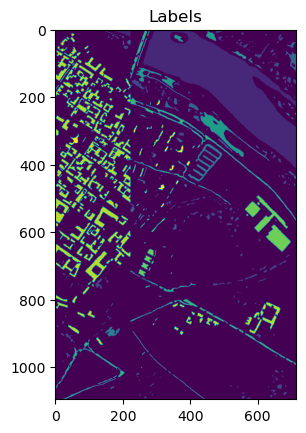

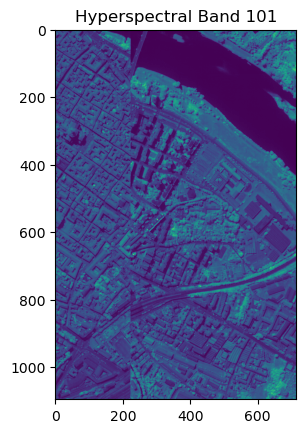

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 5 training sam


 -- Test set created with: 
	148062 samples
	shape (148062, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(45, 5, 5, 102)
(45, 5, 5, 102)
(148062, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1793, PSNR: 1.2976


	 Training Batch [200/1852], Loss: 0.0842, PSNR: 7.5707


	 Training Batch [400/1852], Loss: 0.0459, PSNR: 8.9660


	 Training Batch [600/1852], Loss: 0.0255, PSNR: 13.0718


	 Training Batch [800/1852], Loss: 0.0147, PSNR: 15.3899


	 Training Batch [1000/1852], Loss: 0.0145, PSNR: 16.2443


	 Training Batch [1200/1852], Loss: 0.0095, PSNR: 16.2595


	 Training Batch [1400/1852], Loss: 0.0077, PSNR: 17.2601


	 Training Batch [1600/1852], Loss: 0.0069, PSNR: 17.2318


	 Training Batch [1800/1852], Loss: 0.0056, PSNR: 19.5168


Epoch [1/50] Training Loss: 0.0321, PSNR: 13.6576
	[Val]   Batch [1/463] Loss: 0.0055, PSNR: 17.8311
	[Val]   Batch [10/463] Loss: 0.0052, PSNR: 18.9682
	[Val]   Batch [20/463] Loss: 0.0052, PSNR: 17.9449
	[Val]   Batch [30/463] Loss: 0.0062, PSNR: 18.5761
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.6599
	[Val]   Batch [50/463] Loss: 0.0052, PSNR: 17.8672


	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9139
	[Val]   Batch [70/463] Loss: 0.0069, PSNR: 18.3057
	[Val]   Batch [80/463] Loss: 0.0062, PSNR: 20.1827
	[Val]   Batch [90/463] Loss: 0.0060, PSNR: 19.2819
	[Val]   Batch [100/463] Loss: 0.0061, PSNR: 19.0021
	[Val]   Batch [110/463] Loss: 0.0071, PSNR: 18.3977
	[Val]   Batch [120/463] Loss: 0.0048, PSNR: 17.9138


	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3128
	[Val]   Batch [140/463] Loss: 0.0065, PSNR: 18.9197
	[Val]   Batch [150/463] Loss: 0.0075, PSNR: 18.9030
	[Val]   Batch [160/463] Loss: 0.0060, PSNR: 19.1768
	[Val]   Batch [170/463] Loss: 0.0077, PSNR: 18.1329
	[Val]   Batch [180/463] Loss: 0.0056, PSNR: 18.9015
	[Val]   Batch [190/463] Loss: 0.0061, PSNR: 19.2158


	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.5794
	[Val]   Batch [210/463] Loss: 0.0058, PSNR: 18.2586
	[Val]   Batch [220/463] Loss: 0.0058, PSNR: 19.4785
	[Val]   Batch [230/463] Loss: 0.0069, PSNR: 19.2500
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0403
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.2917
	[Val]   Batch [260/463] Loss: 0.0058, PSNR: 18.2881


	[Val]   Batch [270/463] Loss: 0.0045, PSNR: 17.3895
	[Val]   Batch [280/463] Loss: 0.0055, PSNR: 20.1282
	[Val]   Batch [290/463] Loss: 0.0061, PSNR: 17.1399
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.3693
	[Val]   Batch [310/463] Loss: 0.0057, PSNR: 19.2823
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1388
	[Val]   Batch [330/463] Loss: 0.0067, PSNR: 18.5444


	[Val]   Batch [340/463] Loss: 0.0055, PSNR: 19.4852
	[Val]   Batch [350/463] Loss: 0.0071, PSNR: 19.4538
	[Val]   Batch [360/463] Loss: 0.0048, PSNR: 20.3632
	[Val]   Batch [370/463] Loss: 0.0070, PSNR: 18.5047
	[Val]   Batch [380/463] Loss: 0.0069, PSNR: 18.6238
	[Val]   Batch [390/463] Loss: 0.0064, PSNR: 18.4444
	[Val]   Batch [400/463] Loss: 0.0056, PSNR: 17.5114


	[Val]   Batch [410/463] Loss: 0.0055, PSNR: 19.8116
	[Val]   Batch [420/463] Loss: 0.0057, PSNR: 18.6060
	[Val]   Batch [430/463] Loss: 0.0055, PSNR: 18.0810
	[Val]   Batch [440/463] Loss: 0.0055, PSNR: 19.0065
	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.3896
	[Val]   Batch [460/463] Loss: 0.0060, PSNR: 17.7516
Epoch [1/50] Validation Loss: 0.0059, PSNR: 18.5852

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0082, PSNR: 20.8638


	 Training Batch [200/1852], Loss: 0.0059, PSNR: 18.0475


	 Training Batch [400/1852], Loss: 0.0053, PSNR: 18.6861


	 Training Batch [600/1852], Loss: 0.0043, PSNR: 20.3699


	 Training Batch [800/1852], Loss: 0.0065, PSNR: 18.8763


	 Training Batch [1000/1852], Loss: 0.0044, PSNR: 20.4667


	 Training Batch [1200/1852], Loss: 0.0043, PSNR: 20.5474


	 Training Batch [1400/1852], Loss: 0.0037, PSNR: 19.9684


	 Training Batch [1600/1852], Loss: 0.0036, PSNR: 20.3786


	 Training Batch [1800/1852], Loss: 0.0032, PSNR: 21.5408


Epoch [2/50] Training Loss: 0.0045, PSNR: 19.8903
	[Val]   Batch [1/463] Loss: 0.0029, PSNR: 20.5925
	[Val]   Batch [10/463] Loss: 0.0027, PSNR: 21.8650
	[Val]   Batch [20/463] Loss: 0.0026, PSNR: 20.9495
	[Val]   Batch [30/463] Loss: 0.0035, PSNR: 21.1054
	[Val]   Batch [40/463] Loss: 0.0025, PSNR: 20.6143
	[Val]   Batch [50/463] Loss: 0.0027, PSNR: 20.7728


	[Val]   Batch [60/463] Loss: 0.0025, PSNR: 20.8460
	[Val]   Batch [70/463] Loss: 0.0039, PSNR: 20.7676
	[Val]   Batch [80/463] Loss: 0.0035, PSNR: 22.7312
	[Val]   Batch [90/463] Loss: 0.0032, PSNR: 21.9958
	[Val]   Batch [100/463] Loss: 0.0035, PSNR: 21.4332
	[Val]   Batch [110/463] Loss: 0.0039, PSNR: 20.9171
	[Val]   Batch [120/463] Loss: 0.0024, PSNR: 20.8826
	[Val]   Batch [130/463] Loss: 0.0030, PSNR: 22.0792


	[Val]   Batch [140/463] Loss: 0.0036, PSNR: 21.4614
	[Val]   Batch [150/463] Loss: 0.0042, PSNR: 21.4432
	[Val]   Batch [160/463] Loss: 0.0033, PSNR: 21.7537
	[Val]   Batch [170/463] Loss: 0.0044, PSNR: 20.5207
	[Val]   Batch [180/463] Loss: 0.0032, PSNR: 21.3340
	[Val]   Batch [190/463] Loss: 0.0033, PSNR: 21.9435


	[Val]   Batch [200/463] Loss: 0.0033, PSNR: 21.2598
	[Val]   Batch [210/463] Loss: 0.0033, PSNR: 20.6962
	[Val]   Batch [220/463] Loss: 0.0032, PSNR: 22.0903
	[Val]   Batch [230/463] Loss: 0.0039, PSNR: 21.7781
	[Val]   Batch [240/463] Loss: 0.0028, PSNR: 20.8040
	[Val]   Batch [250/463] Loss: 0.0037, PSNR: 19.8189
	[Val]   Batch [260/463] Loss: 0.0032, PSNR: 20.8873


	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.6269
	[Val]   Batch [280/463] Loss: 0.0029, PSNR: 22.9372
	[Val]   Batch [290/463] Loss: 0.0033, PSNR: 19.8647
	[Val]   Batch [300/463] Loss: 0.0033, PSNR: 22.0481
	[Val]   Batch [310/463] Loss: 0.0031, PSNR: 21.9392
	[Val]   Batch [320/463] Loss: 0.0031, PSNR: 21.8000
	[Val]   Batch [330/463] Loss: 0.0036, PSNR: 21.2515


	[Val]   Batch [340/463] Loss: 0.0029, PSNR: 22.2133
	[Val]   Batch [350/463] Loss: 0.0042, PSNR: 21.7769
	[Val]   Batch [360/463] Loss: 0.0026, PSNR: 23.0853
	[Val]   Batch [370/463] Loss: 0.0039, PSNR: 21.0756
	[Val]   Batch [380/463] Loss: 0.0037, PSNR: 21.3544
	[Val]   Batch [390/463] Loss: 0.0034, PSNR: 21.1256
	[Val]   Batch [400/463] Loss: 0.0031, PSNR: 20.1308


	[Val]   Batch [410/463] Loss: 0.0028, PSNR: 22.6760
	[Val]   Batch [420/463] Loss: 0.0030, PSNR: 21.3635
	[Val]   Batch [430/463] Loss: 0.0030, PSNR: 20.7457
	[Val]   Batch [440/463] Loss: 0.0030, PSNR: 21.6168
	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.4876
	[Val]   Batch [460/463] Loss: 0.0031, PSNR: 20.5587
Epoch [2/50] Validation Loss: 0.0032, PSNR: 21.3037

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0030, PSNR: 21.3606


	 Training Batch [200/1852], Loss: 0.0033, PSNR: 21.4668


	 Training Batch [400/1852], Loss: 0.0026, PSNR: 21.6136


	 Training Batch [600/1852], Loss: 0.0024, PSNR: 22.1884


	 Training Batch [800/1852], Loss: 0.0029, PSNR: 22.9965


	 Training Batch [1000/1852], Loss: 0.0021, PSNR: 21.1309


	 Training Batch [1200/1852], Loss: 0.0020, PSNR: 24.4953


	 Training Batch [1400/1852], Loss: 0.0023, PSNR: 22.1127


	 Training Batch [1600/1852], Loss: 0.0019, PSNR: 23.5024


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 23.0194


Epoch [3/50] Training Loss: 0.0025, PSNR: 22.5013
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.5050
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.7087
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.8779
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.4333
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0147
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.3762
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.3635


	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.1327
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.9247
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.0035
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.5012
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.2795
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.2885
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.3666


	[Val]   Batch [140/463] Loss: 0.0017, PSNR: 24.6554
	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.1752
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.3379
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.6412
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.0714
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.0962
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.4609


	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.3363
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7773
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.7040
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.6589
	[Val]   Batch [250/463] Loss: 0.0019, PSNR: 22.6879
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6671
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.9166


	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.7386
	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.9161
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8447
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.2532
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.6662
	[Val]   Batch [330/463] Loss: 0.0016, PSNR: 24.6513
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.0053


	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.8267
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8475
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.5283
	[Val]   Batch [380/463] Loss: 0.0015, PSNR: 25.1770
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.6736
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.6663
	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.6030


	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.4475
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1851
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.2187
	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.3638
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4709
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.2590

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0017, PSNR: 22.3391


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 24.8283


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 23.9578


	 Training Batch [600/1852], Loss: 0.0019, PSNR: 23.9871


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 24.0698


	 Training Batch [1000/1852], Loss: 0.0021, PSNR: 24.1908


	 Training Batch [1200/1852], Loss: 0.0016, PSNR: 26.4480


	 Training Batch [1400/1852], Loss: 0.0015, PSNR: 24.3616


	 Training Batch [1600/1852], Loss: 0.0014, PSNR: 23.6113


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 25.4099


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3605
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.6752
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.0278
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.2276
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.6609
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.2011
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.6598
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.5753


	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.3887
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.4540
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.2925
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.7971
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6401
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5727
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.6740


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9585
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5923
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5357
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.7598
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.3200
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.4172
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 25.9837
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.5217


	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9578
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.1336
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.9858
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8229
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.7951
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.3359
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.0319
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.1597


	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.0664
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.5342
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 26.0131
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 25.9937
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.3277
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.0757
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.8451


	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.7509
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.6315
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0624
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8067
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.9473
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.7279
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.3275


	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.4370
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.6491
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.7198
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.5591

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0014, PSNR: 24.1772


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 26.4008


	 Training Batch [400/1852], Loss: 0.0017, PSNR: 24.6831


	 Training Batch [600/1852], Loss: 0.0012, PSNR: 25.1033


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 25.5403


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 25.0520


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 24.7978


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 25.2806


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 25.1280


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 25.1147


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.4041
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.7066
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0358
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.2638
	[Val]   Batch [30/463] Loss: 0.0010, PSNR: 26.6880
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.1632
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.6852
	[Val]   Batch [60/463] Loss: 0.0009, PSNR: 25.5562


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.4506
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.7005
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.3565
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.8958
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.7684
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.5973
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7484
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 27.0448


	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.7529
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.4526
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7221
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3388
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4488
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.1409
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.4965


	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.9249
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.3631
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0865
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.8091
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.7135
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.4315
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.0761


	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.2546
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.9911
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.4870
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.1457
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.0939
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.4187
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.0700


	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.5708
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.8772
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.8771
	[Val]   Batch [390/463] Loss: 0.0009, PSNR: 27.1831
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.7677
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9854


	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.7558
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.2205
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.4124
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.5991
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.7032
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.6136

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 26.3805


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 26.6209


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 26.2006


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 27.3970


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 24.8271


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 27.1948


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 25.7405


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 28.2263


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 26.5982


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.9168


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2310
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6035
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0048
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.2709
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.5702
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.0550
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.7205
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4734


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.3843
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.8743
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3401
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8726
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7689
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.5416
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.7046


	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0179
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.7906
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.3489
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.5732
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2537
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.3967
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.2185
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.3803


	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.7863
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3731
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 27.0995
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.7167
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.5952
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.5394
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.0400
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.2072


	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.7867
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4565
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1911
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.0694
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.4224
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.9553
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.2266


	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.8352
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 28.9791
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.1812
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6523
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.9417
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.6978
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0783


	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.2994
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.5317
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.6376
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.5844

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 27.0748


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 26.5175


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.3293


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 27.4511


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 28.3293


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 27.9064


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 27.8699


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 28.2302


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 27.3188


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.1318


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.8813
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.1984
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.6073
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 27.8866
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 28.1589
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.6752
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.3976


	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.0635
	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 27.9759
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.5819
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.0016
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.5158
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.4822
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 27.1473


	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 29.3153
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.6233
	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.4924
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 28.0107
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.2642
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 27.8849
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 28.9837


	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.8650
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0423
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.3387
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 29.9737
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.7309
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.3839
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2641


	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 27.2181
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.6830
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 26.9125
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.3088
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.0782
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 28.8872
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.7094


	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.0806
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.5683
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.6150
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.5303
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.6322
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.8008
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.2507
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.5432


	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.2780
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.7428
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 27.8918
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 25.1697
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.3070
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.2219

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 26.8680


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.9693


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 27.3417


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.1916


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.0531


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 26.4040


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.6841


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.4255


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.1032


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 28.8351


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4882
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0123
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.5609
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.7770
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 29.0286
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.4604
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.3295
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.8660


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.9536
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.6248
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.9504
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.4352
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.5068
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0755


	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1714
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.5320
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.5347
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 28.9216
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.1375
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.8541
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.8150


	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.7841
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.0252
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.2201
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.9255
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5966
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.2748
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.1766


	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.2128
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.5807
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.8484
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 29.0609
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.9919
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.8455
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.6276


	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.0005
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.4746
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2313
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4090
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.5814
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.7996
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1166
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.3908


	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.1750
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.6029
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.7593
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 26.0603
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.1991
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.1442

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.0478


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.5205


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.5159


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 28.1863


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 27.3227


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.1350


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.8475


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.9908


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.6047


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.0743


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.0467
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.5584
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.1074
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.3850
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.5693
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 28.0333
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.9785
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.4178


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.4238
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.1047
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.5060
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.0208
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.0188
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.6194
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.6838


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.9728
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.1652
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.5708
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.7488
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.3683
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.3596
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.2681
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.6292


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.7012
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.4174
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.1773
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.8946
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.9025
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.7845
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.1458
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.4684


	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5111
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.5216
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4503
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.1674
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.5804
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.0358
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.5655


	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.9907
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.1801
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.3459
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.6099
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.9522
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.7144
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.2095
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.2451


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6476
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.8263
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6991

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.8183


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.2911


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.0476


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.3968


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 27.6691


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 30.4665


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 30.0806


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.2905


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.9673


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.5335


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4733
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.0888
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.7807
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.9987
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.2419
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6190
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.6659


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.0275
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.1455
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.8341
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.1541
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.6983
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7075
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.1508


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.2964
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.5626
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.8683
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.2157
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.3588
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.0405
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.8973
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.9917


	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.3023
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.2389
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.1510
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.8156
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.4578
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.5434


	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.4590
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.7348
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.1428
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.0135
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.1673
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.1239


	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.8359
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.2512
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.6842
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9206
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.6019
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8832
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 31.0401


	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.1150
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.4928
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.3447
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.8134
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.7430
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.2494
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.4853
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.3374

LOG: Epoch [11/50]


	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.9316


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 28.1127


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 27.8055


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 29.3134


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 27.6053


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.2431


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 30.2818


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.0674


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.2431


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.9324


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8321
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.4396
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.1721
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.3994
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.6625
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.9983
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.0965
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.4494


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.5451
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.2741
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.5631
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.1175
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.1300
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.5183
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.6667
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.9053


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3365
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.6970
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.8086
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4962
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2782
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.3538
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.7547
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.5677


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.4887
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.2688
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.8946
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.0271
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.8950
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1122
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.5928
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.5048


	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5683
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.5279
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.2098
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.6588
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.0822
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.1689
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.9916


	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.3387
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.3909
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.4992
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8171
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.7052
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.1965
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.1411


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.6237
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.9029
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.7356

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.8383


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.6134


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.4455


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 29.6914


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.2709


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.9665


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 29.1677


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.3823


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.4575


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.0622


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1520
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8123
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6441
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.8267
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.1347
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3505
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.5772
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.8941


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.0803
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.8559
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0635
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6060
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7138
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8898
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.1252


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4588
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.9992
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.2091
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.3173
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 30.9518


	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7031
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8119
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.2854
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9999
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.0567
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.7227
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.3821


	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.5338
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2745
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.5345
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.1156
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.8655
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9939
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.0230


	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7417
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.1109
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6076
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4018
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.5180
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9208
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.9704


	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.9060
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.2518
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.1522
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6176
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5320
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0871
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.3258
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.2206

LOG: Epoch [13/50]


	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.7638


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.7978


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.5039


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 26.9056


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.6194


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 30.4664


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.7806


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.4430


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.1564


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.0182


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3882
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.0213
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.7895
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0560
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3008
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5905
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.7983
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0611


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.2749
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.8853
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.1934
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6953
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7466
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0470
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.2999


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.5365
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.0922
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3908
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5591
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0875
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.8336
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9675


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.4276
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.0998
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.1961
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.8947
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.5790
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7380
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.3748


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.5931
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.2360
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0506
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1152
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.1683
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8424
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2413


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.7419
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5031
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.7172
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.1333
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.0344
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.0616
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3158


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.3497
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.8078
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5641
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.2564
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.5652
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.3628
Early stopping triggered at epoch 13. No improvement for 3 epochs.


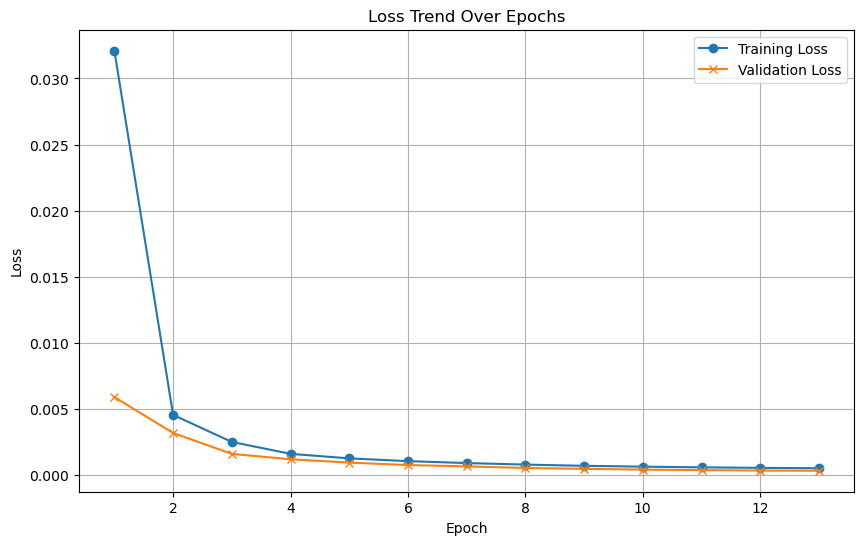

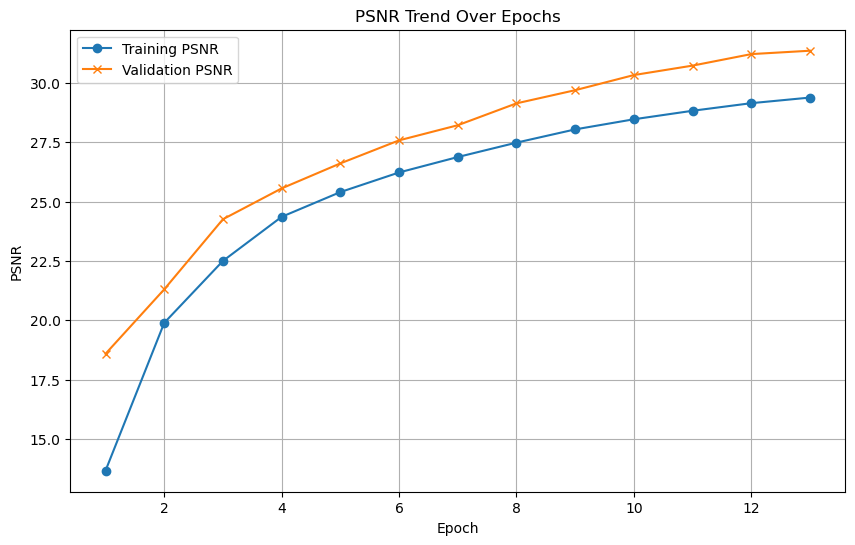

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2043
    Validation Batch [1/1], Loss: 2.2037
Validation Loss: 2.2037, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2037. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1457
    Validation Batch [1/1], Loss: 2.2037
Validation Loss: 2.2037, Validation Accuracy: 11.11%
Validation loss improved from 2.2037 to 2.2037. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1329
    Validation Batch [1/1], Loss: 2.2037
Validation Loss: 2.2037, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0980
    Validation Batch [1/1], Loss: 2.2038
Validation Loss: 2.2038, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] co

    Validation Batch [1/1], Loss: 2.2040
Validation Loss: 2.2040, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 1.9805
    Validation Batch [1/1], Loss: 2.2041
Validation Loss: 2.2041, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9612
    Validation Batch [1/1], Loss: 2.2040
Validation Loss: 2.2040, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9288
    Validation Batch [1/1], Loss: 2.2040
Validation Loss: 2.2040, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 1.9143
    Validation Batch [1/1], Loss: 2.2039
Validation Loss: 2.2039, Vali

    Validation Batch [1/1], Loss: 2.0171
Validation Loss: 2.0171, Validation Accuracy: 28.89%
Validation loss improved from 2.0364 to 2.0171. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.4957
    Validation Batch [1/1], Loss: 1.9988
Validation Loss: 1.9988, Validation Accuracy: 31.11%
Validation loss improved from 2.0171 to 1.9988. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.5816
    Validation Batch [1/1], Loss: 1.9801
Validation Loss: 1.9801, Validation Accuracy: 42.22%
Validation loss improved from 1.9988 to 1.9801. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.5733
    Validation Batch [1/1], Loss: 1.9617
Validation Loss: 1.9617, Validation Accuracy: 46.67%
Validation loss improved from 1.9801 to 1.9617. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.5487
    Vali

Epoch [74/1000] completed, Average Training Loss: 1.2629
    Validation Batch [1/1], Loss: 1.4493
Validation Loss: 1.4493, Validation Accuracy: 77.78%
Validation loss improved from 1.4625 to 1.4493. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.2755
    Validation Batch [1/1], Loss: 1.4369
Validation Loss: 1.4369, Validation Accuracy: 77.78%
Validation loss improved from 1.4493 to 1.4369. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.2775
    Validation Batch [1/1], Loss: 1.4231
Validation Loss: 1.4231, Validation Accuracy: 80.00%
Validation loss improved from 1.4369 to 1.4231. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.2604
    Validation Batch [1/1], Loss: 1.4126
Validation Loss: 1.4126, Validation Accuracy: 80.00%
Validation loss improved from 1.4231 to 1.4126. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [7

Epoch [104/1000] completed, Average Training Loss: 1.0934
    Validation Batch [1/1], Loss: 1.2170
Validation Loss: 1.2170, Validation Accuracy: 86.67%
Validation loss improved from 1.2257 to 1.2170. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 0.9897
    Validation Batch [1/1], Loss: 1.2119
Validation Loss: 1.2119, Validation Accuracy: 88.89%
Validation loss improved from 1.2170 to 1.2119. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.0816
    Validation Batch [1/1], Loss: 1.2083
Validation Loss: 1.2083, Validation Accuracy: 86.67%
Validation loss improved from 1.2119 to 1.2083. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.0644
    Validation Batch [1/1], Loss: 1.2029
Validation Loss: 1.2029, Validation Accuracy: 86.67%
Validation loss improved from 1.2083 to 1.2029. Saving model...

LOG: Epoch [108/1000] - Training


    Validation Batch [1/1], Loss: 1.0081
Validation Loss: 1.0081, Validation Accuracy: 88.89%
Validation loss improved from 1.0173 to 1.0081. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.8640
    Validation Batch [1/1], Loss: 1.0042
Validation Loss: 1.0042, Validation Accuracy: 88.89%
Validation loss improved from 1.0081 to 1.0042. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.7893
    Validation Batch [1/1], Loss: 1.0007
Validation Loss: 1.0007, Validation Accuracy: 88.89%
Validation loss improved from 1.0042 to 1.0007. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.8088
    Validation Batch [1/1], Loss: 1.0010
Validation Loss: 1.0010, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.8484
    Validation 

Epoch [171/1000] completed, Average Training Loss: 0.6210
    Validation Batch [1/1], Loss: 0.8162
Validation Loss: 0.8162, Validation Accuracy: 88.89%
Validation loss improved from 0.8193 to 0.8162. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.6164
    Validation Batch [1/1], Loss: 0.8123
Validation Loss: 0.8123, Validation Accuracy: 88.89%
Validation loss improved from 0.8162 to 0.8123. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.5615
    Validation Batch [1/1], Loss: 0.8097
Validation Loss: 0.8097, Validation Accuracy: 88.89%
Validation loss improved from 0.8123 to 0.8097. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.5538
    Validation Batch [1/1], Loss: 0.8070
Validation Loss: 0.8070, Validation Accuracy: 88.89%
Validation loss improved from 0.8097 to 0.8070. Saving model...

LOG: Epoch [175/1000] - Training


Epoch [205/1000] completed, Average Training Loss: 0.4924
    Validation Batch [1/1], Loss: 0.6779
Validation Loss: 0.6779, Validation Accuracy: 88.89%
Validation loss improved from 0.6806 to 0.6779. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.4330
    Validation Batch [1/1], Loss: 0.6779
Validation Loss: 0.6779, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.3835
    Validation Batch [1/1], Loss: 0.6765
Validation Loss: 0.6765, Validation Accuracy: 88.89%
Validation loss improved from 0.6779 to 0.6765. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.4337
    Validation Batch [1/1], Loss: 0.6723
Validation Loss: 0.6723, Validation Accuracy: 88.89%
Validation loss improved from 0.6765 to 0.6723. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000

    Validation Batch [1/1], Loss: 0.5809
Validation Loss: 0.5809, Validation Accuracy: 88.89%
Validation loss improved from 0.5898 to 0.5809. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.3328
    Validation Batch [1/1], Loss: 0.5738
Validation Loss: 0.5738, Validation Accuracy: 88.89%
Validation loss improved from 0.5809 to 0.5738. Saving model...

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.3580
    Validation Batch [1/1], Loss: 0.5719
Validation Loss: 0.5719, Validation Accuracy: 88.89%
Validation loss improved from 0.5738 to 0.5719. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.3306
    Validation Batch [1/1], Loss: 0.5713
Validation Loss: 0.5713, Validation Accuracy: 88.89%
Validation loss improved from 0.5719 to 0.5713. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.3167


    Validation Batch [1/1], Loss: 0.5146
Validation Loss: 0.5146, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.2803
    Validation Batch [1/1], Loss: 0.5168
Validation Loss: 0.5168, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.2765
    Validation Batch [1/1], Loss: 0.5170
Validation Loss: 0.5170, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.2024
    Validation Batch [1/1], Loss: 0.5121
Validation Loss: 0.5121, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.2390
    Validation Batch [1/1], Loss: 0.5072
Validation Loss: 0.

Epoch [300/1000] completed, Average Training Loss: 0.1958
    Validation Batch [1/1], Loss: 0.4607
Validation Loss: 0.4607, Validation Accuracy: 88.89%
Validation loss improved from 0.4644 to 0.4607. Saving model...

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.1751
    Validation Batch [1/1], Loss: 0.4582
Validation Loss: 0.4582, Validation Accuracy: 86.67%
Validation loss improved from 0.4607 to 0.4582. Saving model...

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.1743
    Validation Batch [1/1], Loss: 0.4573
Validation Loss: 0.4573, Validation Accuracy: 88.89%
Validation loss improved from 0.4582 to 0.4573. Saving model...

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.2036
    Validation Batch [1/1], Loss: 0.4589
Validation Loss: 0.4589, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000

Epoch [331/1000] completed, Average Training Loss: 0.1472
    Validation Batch [1/1], Loss: 0.4285
Validation Loss: 0.4285, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.1351
    Validation Batch [1/1], Loss: 0.4247
Validation Loss: 0.4247, Validation Accuracy: 88.89%
Validation loss improved from 0.4252 to 0.4247. Saving model...

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1542
    Validation Batch [1/1], Loss: 0.4224
Validation Loss: 0.4224, Validation Accuracy: 88.89%
Validation loss improved from 0.4247 to 0.4224. Saving model...

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.2118
    Validation Batch [1/1], Loss: 0.4231
Validation Loss: 0.4231, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Av

    Validation Batch [1/1], Loss: 0.4108
Validation Loss: 0.4108, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.1281
    Validation Batch [1/1], Loss: 0.4125
Validation Loss: 0.4125, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.1036
    Validation Batch [1/1], Loss: 0.4144
Validation Loss: 0.4144, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1041
    Validation Batch [1/1], Loss: 0.4118
Validation Loss: 0.4118, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1068
    Validation Batch [1/1], Loss: 0.4077
Validation Loss: 0.

Epoch [396/1000] completed, Average Training Loss: 0.1177
    Validation Batch [1/1], Loss: 0.4028
Validation Loss: 0.4028, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.0729
    Validation Batch [1/1], Loss: 0.4047
Validation Loss: 0.4047, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1145
    Validation Batch [1/1], Loss: 0.4003
Validation Loss: 0.4003, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0976
    Validation Batch [1/1], Loss: 0.3951
Validation Loss: 0.3951, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1245
 

    Validation Batch [1/1], Loss: 0.3907
Validation Loss: 0.3907, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.0770
    Validation Batch [1/1], Loss: 0.3888
Validation Loss: 0.3888, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.3858
Validation Loss: 0.3858, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0898
    Validation Batch [1/1], Loss: 0.3818
Validation Loss: 0.3818, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.3776
Validation Loss

Epoch [457/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.3631
Validation Loss: 0.3631, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.3663
Validation Loss: 0.3663, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0711
    Validation Batch [1/1], Loss: 0.3650
Validation Loss: 0.3650, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0573
    Validation Batch [1/1], Loss: 0.3639
Validation Loss: 0.3639, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.090

Epoch [491/1000] completed, Average Training Loss: 0.0603
    Validation Batch [1/1], Loss: 0.3994
Validation Loss: 0.3994, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.3845
Validation Loss: 0.3845, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.3714
Validation Loss: 0.3714, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0775
    Validation Batch [1/1], Loss: 0.3651
Validation Loss: 0.3651, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0477

Epoch [525/1000] completed, Average Training Loss: 0.0469
    Validation Batch [1/1], Loss: 0.3606
Validation Loss: 0.3606, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.3580
Validation Loss: 0.3580, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0563
    Validation Batch [1/1], Loss: 0.3565
Validation Loss: 0.3565, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.3558
Validation Loss: 0.3558, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.050

    Validation Batch [1/1], Loss: 0.3534
Validation Loss: 0.3534, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0665
    Validation Batch [1/1], Loss: 0.3507
Validation Loss: 0.3507, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.3497
Validation Loss: 0.3497, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.3514
Validation Loss: 0.3514, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.3546
Validation Loss

    Validation Batch [1/1], Loss: 0.3731
Validation Loss: 0.3731, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.3736
Validation Loss: 0.3736, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.3743
Validation Loss: 0.3743, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.3755
Validation Loss: 0.3755, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.3782
Validation Loss

Epoch [622/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.3460
Validation Loss: 0.3460, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0252
    Validation Batch [1/1], Loss: 0.3432
Validation Loss: 0.3432, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0265
    Validation Batch [1/1], Loss: 0.3373
Validation Loss: 0.3373, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.3313
Validation Loss: 0.3313, Validation Accuracy: 91.11%
Validation loss improved from 0.3327 to 0.3313. Saving model...

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Traini

Epoch [655/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.3570
Validation Loss: 0.3570, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.3531
Validation Loss: 0.3531, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.3501
Validation Loss: 0.3501, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0212
    Validation Batch [1/1], Loss: 0.3485
Validation Loss: 0.3485, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.026

    Validation Batch [1/1], Loss: 0.3706
Validation Loss: 0.3706, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.3820
Validation Loss: 0.3820, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.3828
Validation Loss: 0.3828, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.3764
Validation Loss: 0.3764, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [690/1000] - Training
Epoch [690/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.3667
Validation Loss

Epoch [718/1000] completed, Average Training Loss: 0.0212
    Validation Batch [1/1], Loss: 0.3630
Validation Loss: 0.3630, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0.0187
    Validation Batch [1/1], Loss: 0.3660
Validation Loss: 0.3660, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.3580
Validation Loss: 0.3580, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.3482
Validation Loss: 0.3482, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.029

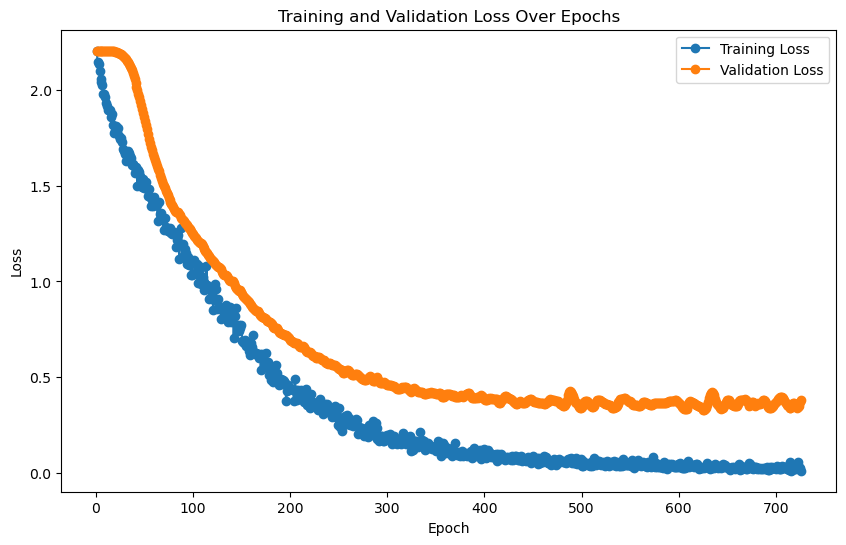

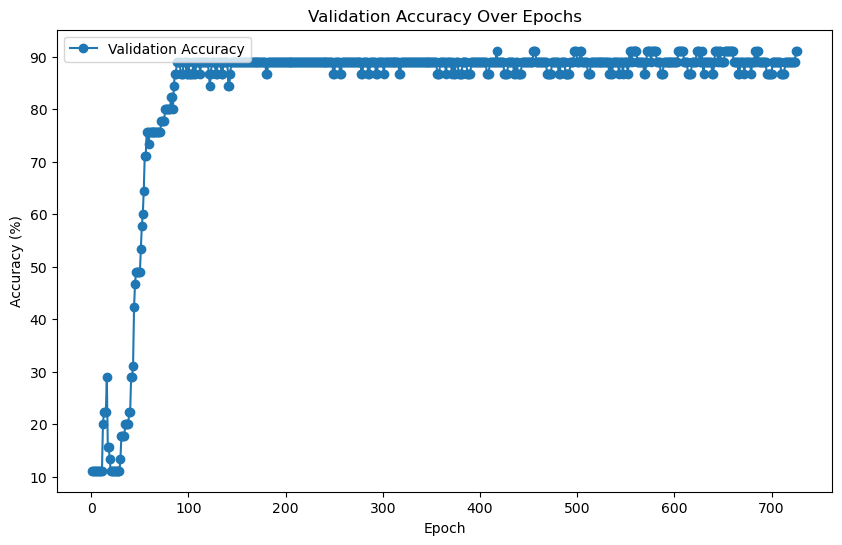


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.3642



Final Test Loss: 0.1799, Test Accuracy: 95.59%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.


  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.


  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.


  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148062, 64), Test labels shape: (148062,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.40      0.57         5
           3       0.71      1.00      0.83         5
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148062, 64)
Test labels shape: (148062,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7512  |  Val Loss: 2.5312
Validation loss improved from inf to 2.5312.


[Epoch 2/1000] Train Loss: 2.5206  |  Val Loss: 2.3586
Validation loss improved from 2.5312 to 2.3586.
[Epoch 3/1000] Train Loss: 2.3402  |  Val Loss: 2.2310
Validation loss improved from 2.3586 to 2.2310.
[Epoch 4/1000] Train Loss: 2.2149  |  Val Loss: 2.1539
Validation loss improved from 2.2310 to 2.1539.
[Epoch 5/1000] Train Loss: 2.1357  |  Val Loss: 2.1049
Validation loss improved from 2.1539 to 2.1049.
[Epoch 6/1000] Train Loss: 2.0787  |  Val Loss: 2.0621
Validation loss improved from 2.1049 to 2.0621.
[Epoch 7/1000] Train Loss: 2.0314  |  Val Loss: 2.0268
Validation loss improved from 2.0621 to 2.0268.
[Epoch 8/1000] Train Loss: 1.9924  |  Val Loss: 1.9988
Validation loss improved from 2.0268 to 1.9988.
[Epoch 9/1000] Train Loss: 1.9628  |  Val Loss: 1.9761
Validation loss improved from 1.9988 to 1.9761.
[Epoch 10/1000] Train Loss: 1.9362  |  Val Loss: 1.9555
Validation loss improved from 1.9761 to 1.9555.
[Epoch 11/1000] Train Loss: 1.9093  |  Val Loss: 1.9367
Validation loss 

[Epoch 76/1000] Train Loss: 0.4210  |  Val Loss: 0.6981
Validation loss improved from 0.7087 to 0.6981.
[Epoch 77/1000] Train Loss: 0.4061  |  Val Loss: 0.6888
Validation loss improved from 0.6981 to 0.6888.
[Epoch 78/1000] Train Loss: 0.3924  |  Val Loss: 0.6804
Validation loss improved from 0.6888 to 0.6804.
[Epoch 79/1000] Train Loss: 0.3791  |  Val Loss: 0.6720
Validation loss improved from 0.6804 to 0.6720.
[Epoch 80/1000] Train Loss: 0.3657  |  Val Loss: 0.6621
Validation loss improved from 0.6720 to 0.6621.
[Epoch 81/1000] Train Loss: 0.3526  |  Val Loss: 0.6505
Validation loss improved from 0.6621 to 0.6505.
[Epoch 82/1000] Train Loss: 0.3399  |  Val Loss: 0.6370
Validation loss improved from 0.6505 to 0.6370.
[Epoch 83/1000] Train Loss: 0.3274  |  Val Loss: 0.6238
Validation loss improved from 0.6370 to 0.6238.
[Epoch 84/1000] Train Loss: 0.3161  |  Val Loss: 0.6130
Validation loss improved from 0.6238 to 0.6130.
[Epoch 85/1000] Train Loss: 0.3053  |  Val Loss: 0.6047
Validati

[Epoch 149/1000] Train Loss: 0.0483  |  Val Loss: 0.4696
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 150/1000] Train Loss: 0.0471  |  Val Loss: 0.4696
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 151/1000] Train Loss: 0.0460  |  Val Loss: 0.4710
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 152/1000] Train Loss: 0.0450  |  Val Loss: 0.4726
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 153/1000] Train Loss: 0.0439  |  Val Loss: 0.4737
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 154/1000] Train Loss: 0.0429  |  Val Loss: 0.4744
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 155/1000] Train Loss: 0.0419  |  Val Loss: 0.4765
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 156/1000] Train Loss: 0.0410  |  Val Loss: 0.4797
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 157/1000] Train Loss: 0.0400  |  Val Loss: 0.4826
!! Validation loss did NOT improve !! Patience:

[Epoch 226/1000] Train Loss: 0.0112  |  Val Loss: 0.5780
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 227/1000] Train Loss: 0.0110  |  Val Loss: 0.5802
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 228/1000] Train Loss: 0.0108  |  Val Loss: 0.5815
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 228 !!
No improvement for 100 epochs.


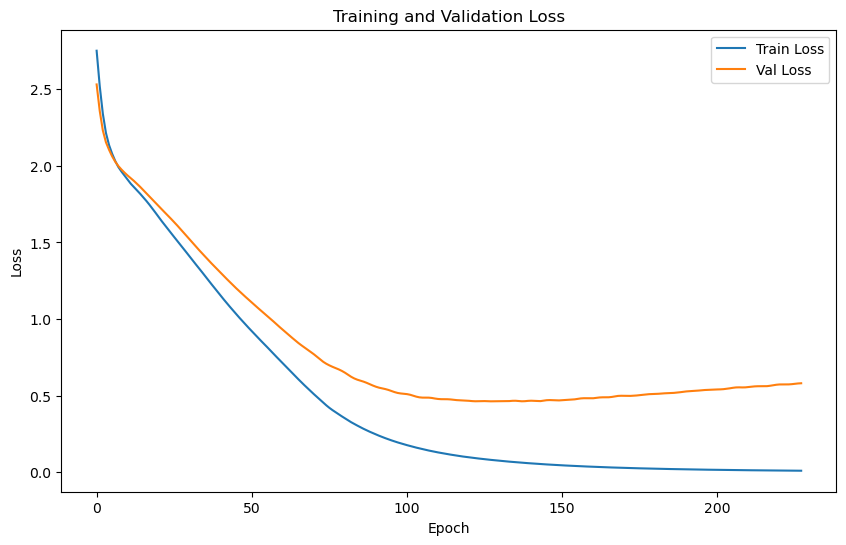

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.3058 | Test Accuracy: 92.14%


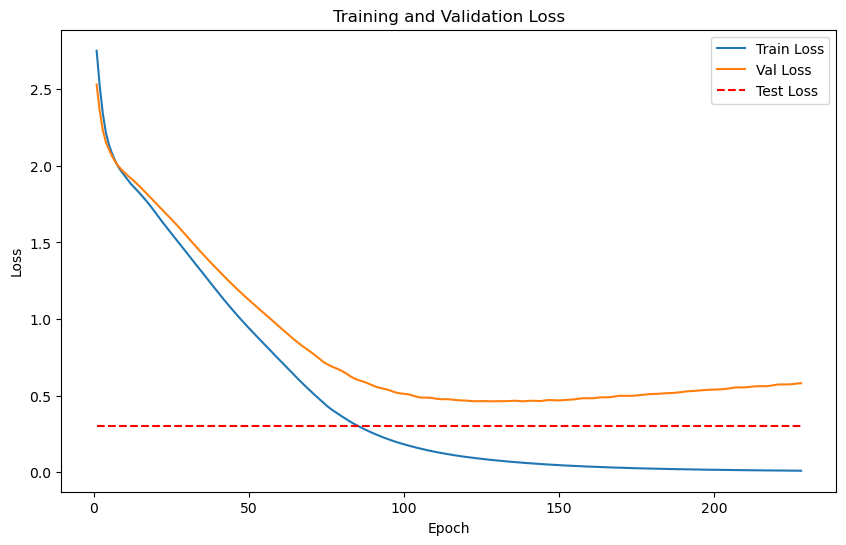

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.1335
Epoch [1/2000], Avg Train Loss: 8.1335
Epoch [1/2000], Avg Val Loss: 3.6326
Validation loss improved from inf to 3.6326. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.8213
Epoch [2/2000], Avg Train Loss: 7.8213
Epoch [2/2000], Avg Val Loss: 3.6024
Validation loss improved from 3.6326 to 3.6024. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.5818
Epoch [3/2000], Avg Train Loss: 8.5818
Epoch [3/2000], Avg Val Loss: 3.5729
Validation loss improved from 3.6024 to 3.5729. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.1520
Epoch [4/2000], Avg Train Loss: 8.1520
Epoch [4/2000], Avg Val Loss: 3.5439
Validation loss improved from 3.5729 to 3.5439. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2892
Epoch [5/2000], Avg Train Loss: 8.2892
Epoch [5/2000], Avg Val Loss: 3.5160
Validation loss improved from 3.5439 to 3.5160. Saving mode

Epoch [10/2000], Avg Val Loss: 3.3899
Validation loss improved from 3.4136 to 3.3899. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 7.8327
Epoch [11/2000], Avg Train Loss: 7.8327
Epoch [11/2000], Avg Val Loss: 3.3670
Validation loss improved from 3.3899 to 3.3670. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.6557
Epoch [12/2000], Avg Train Loss: 7.6557
Epoch [12/2000], Avg Val Loss: 3.3449
Validation loss improved from 3.3670 to 3.3449. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.7992
Epoch [13/2000], Avg Train Loss: 7.7992
Epoch [13/2000], Avg Val Loss: 3.3234
Validation loss improved from 3.3449 to 3.3234. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.5188
Epoch [14/2000], Avg Train Loss: 7.5188
Epoch [14/2000], Avg Val Loss: 3.3026
Validation loss improved from 3.3234 to 3.3026. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.6255
Epoch [47/2000], Avg Train Loss: 5.6255
Epoch [47/2000], Avg Val Loss: 2.9036
Validation loss improved from 2.9098 to 2.9036. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.9744
Epoch [48/2000], Avg Train Loss: 5.9744
Epoch [48/2000], Avg Val Loss: 2.8976
Validation loss improved from 2.9036 to 2.8976. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.2896
Epoch [49/2000], Avg Train Loss: 5.2896
Epoch [49/2000], Avg Val Loss: 2.8919
Validation loss improved from 2.8976 to 2.8919. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.4916
Epoch [50/2000], Avg Train Loss: 5.4916
Epoch [50/2000], Avg Val Loss: 2.8863
Validation loss improved from 2.8919 to 2.8863. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.4827
Epoch [51/2000], Avg Train Loss: 5.4827
Epoch [51/2000], Avg Val Loss: 2.8808
Validation loss improved from 2.8863 to 2.

    Batch [1/1], Train Loss: 5.3946
Epoch [55/2000], Avg Train Loss: 5.3946
Epoch [55/2000], Avg Val Loss: 2.8609
Validation loss improved from 2.8656 to 2.8609. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.4601
Epoch [56/2000], Avg Train Loss: 5.4601
Epoch [56/2000], Avg Val Loss: 2.8564
Validation loss improved from 2.8609 to 2.8564. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.1200
Epoch [57/2000], Avg Train Loss: 5.1200
Epoch [57/2000], Avg Val Loss: 2.8520
Validation loss improved from 2.8564 to 2.8520. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.4352
Epoch [58/2000], Avg Train Loss: 5.4352
Epoch [58/2000], Avg Val Loss: 2.8478
Validation loss improved from 2.8520 to 2.8478. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.2604
Epoch [59/2000], Avg Train Loss: 5.2604
Epoch [59/2000], Avg Val Loss: 2.8438
Validation loss improved from 2.8478 to 2.

    Batch [1/1], Train Loss: 4.1310
Epoch [98/2000], Avg Train Loss: 4.1310
Epoch [98/2000], Avg Val Loss: 2.7645
Validation loss improved from 2.7655 to 2.7645. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.4431
Epoch [99/2000], Avg Train Loss: 4.4431
Epoch [99/2000], Avg Val Loss: 2.7637
Validation loss improved from 2.7645 to 2.7637. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.3265
Epoch [100/2000], Avg Train Loss: 4.3265
Epoch [100/2000], Avg Val Loss: 2.7629
Validation loss improved from 2.7637 to 2.7629. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.1534
Epoch [101/2000], Avg Train Loss: 4.1534
Epoch [101/2000], Avg Val Loss: 2.7621
Validation loss improved from 2.7629 to 2.7621. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.1355
Epoch [102/2000], Avg Train Loss: 4.1355
Epoch [102/2000], Avg Val Loss: 2.7614
Validation loss improved from 2.7

    Batch [1/1], Train Loss: 4.2025
Epoch [105/2000], Avg Train Loss: 4.2025
Epoch [105/2000], Avg Val Loss: 2.7594
Validation loss improved from 2.7600 to 2.7594. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.1255
Epoch [106/2000], Avg Train Loss: 4.1255
Epoch [106/2000], Avg Val Loss: 2.7587
Validation loss improved from 2.7594 to 2.7587. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.1474
Epoch [107/2000], Avg Train Loss: 4.1474
Epoch [107/2000], Avg Val Loss: 2.7581
Validation loss improved from 2.7587 to 2.7581. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.3357
Epoch [108/2000], Avg Train Loss: 4.3357
Epoch [108/2000], Avg Val Loss: 2.7575
Validation loss improved from 2.7581 to 2.7575. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.1535
Epoch [109/2000], Avg Train Loss: 4.1535
Epoch [109/2000], Avg Val Loss: 2.7568
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7438
Epoch [146/2000], Avg Train Loss: 3.7438
Epoch [146/2000], Avg Val Loss: 2.7436
Validation loss improved from 2.7438 to 2.7436. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 3.7806
Epoch [147/2000], Avg Train Loss: 3.7806
Epoch [147/2000], Avg Val Loss: 2.7434
Validation loss improved from 2.7436 to 2.7434. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 3.8294
Epoch [148/2000], Avg Train Loss: 3.8294
Epoch [148/2000], Avg Val Loss: 2.7431
Validation loss improved from 2.7434 to 2.7431. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 3.6277
Epoch [149/2000], Avg Train Loss: 3.6277
Epoch [149/2000], Avg Val Loss: 2.7429
Validation loss improved from 2.7431 to 2.7429. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 3.7467
Epoch [150/2000], Avg Train Loss: 3.7467
Epoch [150/2000], Avg Val Loss: 2.7426
Validation loss improved fro

Epoch [192/2000], Avg Val Loss: 2.7312
Validation loss improved from 2.7315 to 2.7312. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 3.3985
Epoch [193/2000], Avg Train Loss: 3.3985
Epoch [193/2000], Avg Val Loss: 2.7309
Validation loss improved from 2.7312 to 2.7309. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.4734
Epoch [194/2000], Avg Train Loss: 3.4734
Epoch [194/2000], Avg Val Loss: 2.7306
Validation loss improved from 2.7309 to 2.7306. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 3.3937
Epoch [195/2000], Avg Train Loss: 3.3937
Epoch [195/2000], Avg Val Loss: 2.7303
Validation loss improved from 2.7306 to 2.7303. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.2520
Epoch [196/2000], Avg Train Loss: 3.2520
Epoch [196/2000], Avg Val Loss: 2.7300
Validation loss improved from 2.7303 to 2.7300. Saving model...

LOG: Epoch [197/2000] - Training
    Bat

Epoch [240/2000], Avg Val Loss: 2.7143
Validation loss improved from 2.7147 to 2.7143. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 3.2669
Epoch [241/2000], Avg Train Loss: 3.2669
Epoch [241/2000], Avg Val Loss: 2.7138
Validation loss improved from 2.7143 to 2.7138. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 3.2131
Epoch [242/2000], Avg Train Loss: 3.2131
Epoch [242/2000], Avg Val Loss: 2.7134
Validation loss improved from 2.7138 to 2.7134. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 3.1846
Epoch [243/2000], Avg Train Loss: 3.1846
Epoch [243/2000], Avg Val Loss: 2.7130
Validation loss improved from 2.7134 to 2.7130. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 3.2439
Epoch [244/2000], Avg Train Loss: 3.2439
Epoch [244/2000], Avg Val Loss: 2.7125
Validation loss improved from 2.7130 to 2.7125. Saving model...

LOG: Epoch [245/2000] - Training
    Bat

Epoch [295/2000], Avg Val Loss: 2.6890
Validation loss improved from 2.6895 to 2.6890. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 3.1358
Epoch [296/2000], Avg Train Loss: 3.1358
Epoch [296/2000], Avg Val Loss: 2.6885
Validation loss improved from 2.6890 to 2.6885. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 3.1331
Epoch [297/2000], Avg Train Loss: 3.1331
Epoch [297/2000], Avg Val Loss: 2.6880
Validation loss improved from 2.6885 to 2.6880. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 2.9644
Epoch [298/2000], Avg Train Loss: 2.9644
Epoch [298/2000], Avg Val Loss: 2.6875
Validation loss improved from 2.6880 to 2.6875. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.0726
Epoch [299/2000], Avg Train Loss: 3.0726
Epoch [299/2000], Avg Val Loss: 2.6870
Validation loss improved from 2.6875 to 2.6870. Saving model...

LOG: Epoch [300/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9578
Epoch [348/2000], Avg Train Loss: 2.9578
Epoch [348/2000], Avg Val Loss: 2.6585
Validation loss improved from 2.6591 to 2.6585. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.1259
Epoch [349/2000], Avg Train Loss: 3.1259
Epoch [349/2000], Avg Val Loss: 2.6579
Validation loss improved from 2.6585 to 2.6579. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.0721
Epoch [350/2000], Avg Train Loss: 3.0721
Epoch [350/2000], Avg Val Loss: 2.6573
Validation loss improved from 2.6579 to 2.6573. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 2.9973
Epoch [351/2000], Avg Train Loss: 2.9973
Epoch [351/2000], Avg Val Loss: 2.6568
Validation loss improved from 2.6573 to 2.6568. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 2.9665
Epoch [352/2000], Avg Train Loss: 2.9665
Epoch [352/2000], Avg Val Loss: 2.6562
Validation loss improved fro

Epoch [396/2000], Avg Val Loss: 2.6316
Validation loss improved from 2.6322 to 2.6316. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 2.9258
Epoch [397/2000], Avg Train Loss: 2.9258
Epoch [397/2000], Avg Val Loss: 2.6311
Validation loss improved from 2.6316 to 2.6311. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 2.9316
Epoch [398/2000], Avg Train Loss: 2.9316
Epoch [398/2000], Avg Val Loss: 2.6305
Validation loss improved from 2.6311 to 2.6305. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 2.8603
Epoch [399/2000], Avg Train Loss: 2.8603
Epoch [399/2000], Avg Val Loss: 2.6299
Validation loss improved from 2.6305 to 2.6299. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 2.7884
Epoch [400/2000], Avg Train Loss: 2.7884
Epoch [400/2000], Avg Val Loss: 2.6293
Validation loss improved from 2.6299 to 2.6293. Saving model...

LOG: Epoch [401/2000] - Training
    Bat

Epoch [447/2000], Avg Val Loss: 2.6027
Validation loss improved from 2.6032 to 2.6027. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 2.8813
Epoch [448/2000], Avg Train Loss: 2.8813
Epoch [448/2000], Avg Val Loss: 2.6022
Validation loss improved from 2.6027 to 2.6022. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 2.8461
Epoch [449/2000], Avg Train Loss: 2.8461
Epoch [449/2000], Avg Val Loss: 2.6016
Validation loss improved from 2.6022 to 2.6016. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 2.8078
Epoch [450/2000], Avg Train Loss: 2.8078
Epoch [450/2000], Avg Val Loss: 2.6010
Validation loss improved from 2.6016 to 2.6010. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 2.8508
Epoch [451/2000], Avg Train Loss: 2.8508
Epoch [451/2000], Avg Val Loss: 2.6005
Validation loss improved from 2.6010 to 2.6005. Saving model...

LOG: Epoch [452/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7903
Epoch [499/2000], Avg Train Loss: 2.7903
Epoch [499/2000], Avg Val Loss: 2.5736
Validation loss improved from 2.5742 to 2.5736. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 2.6960
Epoch [500/2000], Avg Train Loss: 2.6960
Epoch [500/2000], Avg Val Loss: 2.5729
Validation loss improved from 2.5736 to 2.5729. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 2.7955
Epoch [501/2000], Avg Train Loss: 2.7955
Epoch [501/2000], Avg Val Loss: 2.5723
Validation loss improved from 2.5729 to 2.5723. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 2.8364
Epoch [502/2000], Avg Train Loss: 2.8364
Epoch [502/2000], Avg Val Loss: 2.5717
Validation loss improved from 2.5723 to 2.5717. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 2.7127
Epoch [503/2000], Avg Train Loss: 2.7127
Epoch [503/2000], Avg Val Loss: 2.5711
Validation loss improved fro

Epoch [548/2000], Avg Val Loss: 2.5465
Validation loss improved from 2.5470 to 2.5465. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 2.7840
Epoch [549/2000], Avg Train Loss: 2.7840
Epoch [549/2000], Avg Val Loss: 2.5460
Validation loss improved from 2.5465 to 2.5460. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 2.7945
Epoch [550/2000], Avg Train Loss: 2.7945
Epoch [550/2000], Avg Val Loss: 2.5455
Validation loss improved from 2.5460 to 2.5455. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 2.7737
Epoch [551/2000], Avg Train Loss: 2.7737
Epoch [551/2000], Avg Val Loss: 2.5450
Validation loss improved from 2.5455 to 2.5450. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 2.7385
Epoch [552/2000], Avg Train Loss: 2.7385
Epoch [552/2000], Avg Val Loss: 2.5445
Validation loss improved from 2.5450 to 2.5445. Saving model...

LOG: Epoch [553/2000] - Training
    Bat

Epoch [599/2000], Avg Val Loss: 2.5219
Validation loss improved from 2.5224 to 2.5219. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 2.7113
Epoch [600/2000], Avg Train Loss: 2.7113
Epoch [600/2000], Avg Val Loss: 2.5214
Validation loss improved from 2.5219 to 2.5214. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 2.6430
Epoch [601/2000], Avg Train Loss: 2.6430
Epoch [601/2000], Avg Val Loss: 2.5210
Validation loss improved from 2.5214 to 2.5210. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 2.6638
Epoch [602/2000], Avg Train Loss: 2.6638
Epoch [602/2000], Avg Val Loss: 2.5205
Validation loss improved from 2.5210 to 2.5205. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 2.6525
Epoch [603/2000], Avg Train Loss: 2.6525
Epoch [603/2000], Avg Val Loss: 2.5201
Validation loss improved from 2.5205 to 2.5201. Saving model...

LOG: Epoch [604/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6635
Epoch [650/2000], Avg Train Loss: 2.6635
Epoch [650/2000], Avg Val Loss: 2.4978
Validation loss improved from 2.4983 to 2.4978. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 2.5521
Epoch [651/2000], Avg Train Loss: 2.5521
Epoch [651/2000], Avg Val Loss: 2.4973
Validation loss improved from 2.4978 to 2.4973. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 2.6148
Epoch [652/2000], Avg Train Loss: 2.6148
Epoch [652/2000], Avg Val Loss: 2.4968
Validation loss improved from 2.4973 to 2.4968. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 2.6534
Epoch [653/2000], Avg Train Loss: 2.6534
Epoch [653/2000], Avg Val Loss: 2.4963
Validation loss improved from 2.4968 to 2.4963. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 2.6895
Epoch [654/2000], Avg Train Loss: 2.6895
Epoch [654/2000], Avg Val Loss: 2.4958
Validation loss improved fro

Epoch [697/2000], Avg Val Loss: 2.4777
Validation loss improved from 2.4781 to 2.4777. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 2.5846
Epoch [698/2000], Avg Train Loss: 2.5846
Epoch [698/2000], Avg Val Loss: 2.4773
Validation loss improved from 2.4777 to 2.4773. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 2.5365
Epoch [699/2000], Avg Train Loss: 2.5365
Epoch [699/2000], Avg Val Loss: 2.4769
Validation loss improved from 2.4773 to 2.4769. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 2.6018
Epoch [700/2000], Avg Train Loss: 2.6018
Epoch [700/2000], Avg Val Loss: 2.4766
Validation loss improved from 2.4769 to 2.4766. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 2.5395
Epoch [701/2000], Avg Train Loss: 2.5395
Epoch [701/2000], Avg Val Loss: 2.4762
Validation loss improved from 2.4766 to 2.4762. Saving model...

LOG: Epoch [702/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.4489
Epoch [743/2000], Avg Train Loss: 2.4489
Epoch [743/2000], Avg Val Loss: 2.4582
Validation loss improved from 2.4586 to 2.4582. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 2.6010
Epoch [744/2000], Avg Train Loss: 2.6010
Epoch [744/2000], Avg Val Loss: 2.4578
Validation loss improved from 2.4582 to 2.4578. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 2.6126
Epoch [745/2000], Avg Train Loss: 2.6126
Epoch [745/2000], Avg Val Loss: 2.4575
Validation loss improved from 2.4578 to 2.4575. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 2.4687
Epoch [746/2000], Avg Train Loss: 2.4687
Epoch [746/2000], Avg Val Loss: 2.4571
Validation loss improved from 2.4575 to 2.4571. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 2.6084
Epoch [747/2000], Avg Train Loss: 2.6084
Epoch [747/2000], Avg Val Loss: 2.4568
Validation loss improved fro

Epoch [791/2000], Avg Val Loss: 2.4452
Validation loss improved from 2.4454 to 2.4452. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 2.5169
Epoch [792/2000], Avg Train Loss: 2.5169
Epoch [792/2000], Avg Val Loss: 2.4449
Validation loss improved from 2.4452 to 2.4449. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 2.4453
Epoch [793/2000], Avg Train Loss: 2.4453
Epoch [793/2000], Avg Val Loss: 2.4447
Validation loss improved from 2.4449 to 2.4447. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 2.4886
Epoch [794/2000], Avg Train Loss: 2.4886
Epoch [794/2000], Avg Val Loss: 2.4445
Validation loss improved from 2.4447 to 2.4445. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 2.4527
Epoch [795/2000], Avg Train Loss: 2.4527
Epoch [795/2000], Avg Val Loss: 2.4443
Validation loss improved from 2.4445 to 2.4443. Saving model...

LOG: Epoch [796/2000] - Training
    Bat

Epoch [841/2000], Avg Val Loss: 2.4343
Validation loss improved from 2.4345 to 2.4343. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 2.5058
Epoch [842/2000], Avg Train Loss: 2.5058
Epoch [842/2000], Avg Val Loss: 2.4342
Validation loss improved from 2.4343 to 2.4342. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 2.4147
Epoch [843/2000], Avg Train Loss: 2.4147
Epoch [843/2000], Avg Val Loss: 2.4340
Validation loss improved from 2.4342 to 2.4340. Saving model...

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 2.5185
Epoch [844/2000], Avg Train Loss: 2.5185
Epoch [844/2000], Avg Val Loss: 2.4339
Validation loss improved from 2.4340 to 2.4339. Saving model...

LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 2.3908
Epoch [845/2000], Avg Train Loss: 2.3908
Epoch [845/2000], Avg Val Loss: 2.4338
Validation loss improved from 2.4339 to 2.4338. Saving model...

LOG: Epoch [846/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.4784
Epoch [891/2000], Avg Train Loss: 2.4784
Epoch [891/2000], Avg Val Loss: 2.4283
Validation loss improved from 2.4285 to 2.4283. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 2.4155
Epoch [892/2000], Avg Train Loss: 2.4155
Epoch [892/2000], Avg Val Loss: 2.4282
Validation loss improved from 2.4283 to 2.4282. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 2.3606
Epoch [893/2000], Avg Train Loss: 2.3606
Epoch [893/2000], Avg Val Loss: 2.4281
Validation loss improved from 2.4282 to 2.4281. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 2.4681
Epoch [894/2000], Avg Train Loss: 2.4681
Epoch [894/2000], Avg Val Loss: 2.4280
Validation loss improved from 2.4281 to 2.4280. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 2.3926
Epoch [895/2000], Avg Train Loss: 2.3926
Epoch [895/2000], Avg Val Loss: 2.4279
Validation loss improved fro

Epoch [932/2000], Avg Val Loss: 2.4211
Validation loss improved from 2.4213 to 2.4211. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 2.3695
Epoch [933/2000], Avg Train Loss: 2.3695
Epoch [933/2000], Avg Val Loss: 2.4208
Validation loss improved from 2.4211 to 2.4208. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 2.3995
Epoch [934/2000], Avg Train Loss: 2.3995
Epoch [934/2000], Avg Val Loss: 2.4206
Validation loss improved from 2.4208 to 2.4206. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 2.3122
Epoch [935/2000], Avg Train Loss: 2.3122
Epoch [935/2000], Avg Val Loss: 2.4203
Validation loss improved from 2.4206 to 2.4203. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 2.3698
Epoch [936/2000], Avg Train Loss: 2.3698
Epoch [936/2000], Avg Val Loss: 2.4201
Validation loss improved from 2.4203 to 2.4201. Saving model...

LOG: Epoch [937/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.3878
Epoch [983/2000], Avg Train Loss: 2.3878
Epoch [983/2000], Avg Val Loss: 2.4132
Validation loss improved from 2.4134 to 2.4132. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 2.3235
Epoch [984/2000], Avg Train Loss: 2.3235
Epoch [984/2000], Avg Val Loss: 2.4130
Validation loss improved from 2.4132 to 2.4130. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 2.3639
Epoch [985/2000], Avg Train Loss: 2.3639
Epoch [985/2000], Avg Val Loss: 2.4128
Validation loss improved from 2.4130 to 2.4128. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 2.3740
Epoch [986/2000], Avg Train Loss: 2.3740
Epoch [986/2000], Avg Val Loss: 2.4126
Validation loss improved from 2.4128 to 2.4126. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 2.3267
Epoch [987/2000], Avg Train Loss: 2.3267
Epoch [987/2000], Avg Val Loss: 2.4124
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3251
Epoch [1032/2000], Avg Train Loss: 2.3251
Epoch [1032/2000], Avg Val Loss: 2.4067
Validation loss improved from 2.4068 to 2.4067. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 2.3089
Epoch [1033/2000], Avg Train Loss: 2.3089
Epoch [1033/2000], Avg Val Loss: 2.4066
Validation loss improved from 2.4067 to 2.4066. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 2.3076
Epoch [1034/2000], Avg Train Loss: 2.3076
Epoch [1034/2000], Avg Val Loss: 2.4066
Validation loss improved from 2.4066 to 2.4066. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 2.3316
Epoch [1035/2000], Avg Train Loss: 2.3316
Epoch [1035/2000], Avg Val Loss: 2.4065
Validation loss improved from 2.4066 to 2.4065. Saving model...

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 2.2779
Epoch [1036/2000], Avg Train Loss: 2.2779
Epoch [1036/2000], Avg Val Loss: 2.4065
Validation los

    Batch [1/1], Train Loss: 2.2984
Epoch [1079/2000], Avg Train Loss: 2.2984
Epoch [1079/2000], Avg Val Loss: 2.4061
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 2.2283
Epoch [1080/2000], Avg Train Loss: 2.2283
Epoch [1080/2000], Avg Val Loss: 2.4062
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 2.2817
Epoch [1081/2000], Avg Train Loss: 2.2817
Epoch [1081/2000], Avg Val Loss: 2.4063
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 2.2866
Epoch [1082/2000], Avg Train Loss: 2.2866
Epoch [1082/2000], Avg Val Loss: 2.4064
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 2.2886
Epoch [1083/2000], Avg Train Loss: 2.2886
Epoch [1083/2000], Avg Val Loss: 2.4065
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1084/20

Epoch [1129/2000], Avg Val Loss: 2.4035
Validation loss improved from 2.4036 to 2.4035. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 2.3244
Epoch [1130/2000], Avg Train Loss: 2.3244
Epoch [1130/2000], Avg Val Loss: 2.4035
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 2.2645
Epoch [1131/2000], Avg Train Loss: 2.2645
Epoch [1131/2000], Avg Val Loss: 2.4035
Validation loss improved from 2.4035 to 2.4035. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 2.3208
Epoch [1132/2000], Avg Train Loss: 2.3208
Epoch [1132/2000], Avg Val Loss: 2.4034
Validation loss improved from 2.4035 to 2.4034. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 2.2577
Epoch [1133/2000], Avg Train Loss: 2.2577
Epoch [1133/2000], Avg Val Loss: 2.4034
Validation loss improved from 2.4034 to 2.4034. Saving model...

LOG: Epoch [1134/2000] - Training
    Batc

Epoch [1172/2000], Avg Val Loss: 2.4016
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 2.1831
Epoch [1173/2000], Avg Train Loss: 2.1831
Epoch [1173/2000], Avg Val Loss: 2.4016
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 2.2425
Epoch [1174/2000], Avg Train Loss: 2.2425
Epoch [1174/2000], Avg Val Loss: 2.4016
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 2.2618
Epoch [1175/2000], Avg Train Loss: 2.2618
Epoch [1175/2000], Avg Val Loss: 2.4016
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 2.2742
Epoch [1176/2000], Avg Train Loss: 2.2742
Epoch [1176/2000], Avg Val Loss: 2.4015
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 2.2573
Epoch [1177/2000], Avg Trai

    Batch [1/1], Train Loss: 2.2471
Epoch [1222/2000], Avg Train Loss: 2.2471
Epoch [1222/2000], Avg Val Loss: 2.4046
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 2.2574
Epoch [1223/2000], Avg Train Loss: 2.2574
Epoch [1223/2000], Avg Val Loss: 2.4048
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 2.2510
Epoch [1224/2000], Avg Train Loss: 2.2510
Epoch [1224/2000], Avg Val Loss: 2.4049
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 2.2569
Epoch [1225/2000], Avg Train Loss: 2.2569
Epoch [1225/2000], Avg Val Loss: 2.4051
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 2.2172
Epoch [1226/2000], Avg Train Loss: 2.2172
Epoch [1226/2000], Avg Val Loss: 2.4052
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1227/20

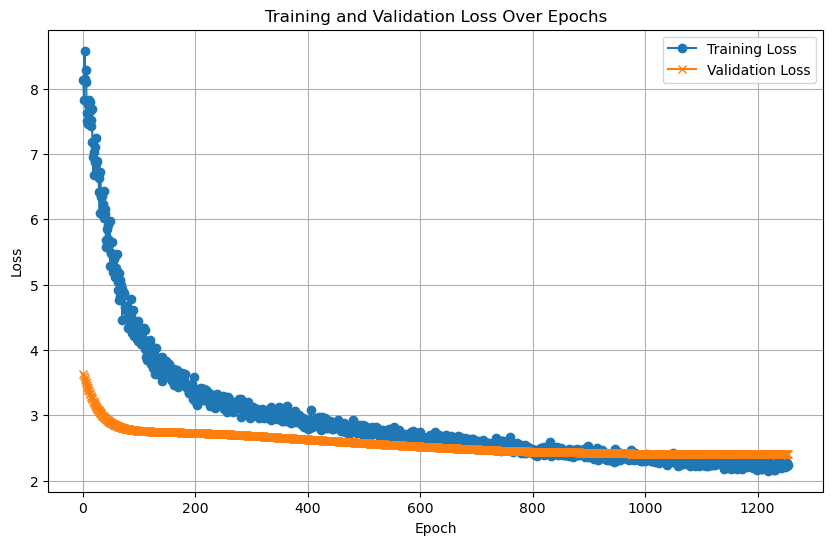

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 5.7481
Test Batch [20/579], Loss: 5.6038
Test Batch [30/579], Loss: 5.6596
Test Batch [40/579], Loss: 5.5612
Test Batch [50/579], Loss: 5.6583
Test Batch [60/579], Loss: 5.5972
Test Batch [70/579], Loss: 5.8170
Test Batch [80/579], Loss: 5.6674
Test Batch [90/579], Loss: 5.9264
Test Batch [100/579], Loss: 5.9601
Test Batch [110/579], Loss: 5.9722
Test Batch [120/579], Loss: 5.7460
Test Batch [130/579], Loss: 5.7642
Test Batch [140/579], Loss: 5.6972
Test Batch [150/579], Loss: 5.6937
Test Batch [160/579], Loss: 5.5926
Test Batch [170/579], Loss: 5.5284


Test Batch [180/579], Loss: 5.6896
Test Batch [190/579], Loss: 5.6142
Test Batch [200/579], Loss: 5.5692
Test Batch [210/579], Loss: 5.5196
Test Batch [220/579], Loss: 5.5046
Test Batch [230/579], Loss: 5.5125
Test Batch [240/579], Loss: 5.4730
Test Batch [250/579], Loss: 5.6421
Test Batch [260/579], Loss: 5.5156
Test Batch [270/579], Loss: 5.6563
Test Batch [280/579], Loss: 5.8512
Test Batch [290/579], Loss: 5.6109
Test Batch [300/579], Loss: 5.6054
Test Batch [310/579], Loss: 5.5149
Test Batch [320/579], Loss: 5.5106


Test Batch [330/579], Loss: 5.5489
Test Batch [340/579], Loss: 5.5376
Test Batch [350/579], Loss: 5.2938
Test Batch [360/579], Loss: 5.5400
Test Batch [370/579], Loss: 5.5483
Test Batch [380/579], Loss: 5.7670
Test Batch [390/579], Loss: 5.2414
Test Batch [400/579], Loss: 5.6036
Test Batch [410/579], Loss: 5.6872
Test Batch [420/579], Loss: 5.4460
Test Batch [430/579], Loss: 5.1201
Test Batch [440/579], Loss: 5.2687
Test Batch [450/579], Loss: 5.2534
Test Batch [460/579], Loss: 5.7465
Test Batch [470/579], Loss: 5.4668
Test Batch [480/579], Loss: 5.7546


Test Batch [490/579], Loss: 5.1540
Test Batch [500/579], Loss: 5.3700
Test Batch [510/579], Loss: 5.4109
Test Batch [520/579], Loss: 4.5524
Test Batch [530/579], Loss: 6.8933
Test Batch [540/579], Loss: 5.7366
Test Batch [550/579], Loss: 5.6484
Test Batch [560/579], Loss: 5.6690
Test Batch [570/579], Loss: 5.5956



Test Loss: 5.6017


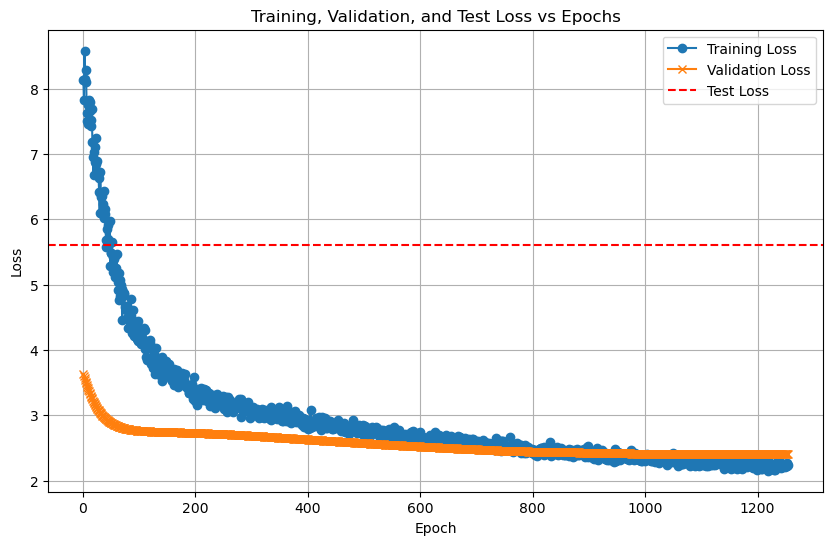

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.


  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.


  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.


  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.


  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.


  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.


  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.


  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.


  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.


  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.60      0.75         5
           3       0.67      0.80      0.73         5
           4       0.80      0.80      0.80         5
           5       1.00      0.80      0.89         5
           6       0.67      0.80      0.73         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.89      0.87      0.87        45
weighted avg       0.89      0.87      0.87        45


LOG: Evaluating on the test set...
Test Accuracy: 93.74%

Test Classifica

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4390  |  Val Loss: 2.3897
Validation loss improved from inf to 2.3897.
[Epoch 2/1000] Train Loss: 2.4219  |  Val Loss: 2.3764
Validation loss improved from 2.3897 to 2.3764.
[Epoch 3/1000] Train Loss: 2.4052  |  Val Loss: 2.3633
Validation loss improved from 2.3764 to 2.3633.
[Epoch 4/1000] Train Loss: 2.3889  |  Val Loss: 2.3506
Validation loss improved from 2.3633 to 2.3506.
[Epoch 5/1000] Train Loss: 2.3729  |  Val Loss: 2.3383
Validation loss improved from 2.3506 to 2.3383.
[Epoch 6/1000] Train Loss: 2.3570  |  Val Loss: 2.3262
Validation loss improved from 2.3383 to 2.3262.
[Epoch 7/1000] Train Loss: 2.3415  |  Val Loss: 2.3141
Validation loss improved from 2.3262 to 2.3141.
[Epoch 8/1000] Train Loss: 2.3262  |  Val Loss: 2.3020
Validation loss improved from 2.3141 to 2.3020.
[Epoch 9/1000] Train Loss: 2.3112  |  Val Loss: 2.2900
Validation loss improved from 2.3020 to 2.2900.
[Epoch 10/1000] Train Loss: 2.2967  |  Val Loss: 2.2781
Validation loss impr

[Epoch 62/1000] Train Loss: 1.7984  |  Val Loss: 1.8797
Validation loss improved from 1.8860 to 1.8797.
[Epoch 63/1000] Train Loss: 1.7904  |  Val Loss: 1.8735
Validation loss improved from 1.8797 to 1.8735.
[Epoch 64/1000] Train Loss: 1.7825  |  Val Loss: 1.8672
Validation loss improved from 1.8735 to 1.8672.
[Epoch 65/1000] Train Loss: 1.7745  |  Val Loss: 1.8609
Validation loss improved from 1.8672 to 1.8609.
[Epoch 66/1000] Train Loss: 1.7667  |  Val Loss: 1.8547
Validation loss improved from 1.8609 to 1.8547.
[Epoch 67/1000] Train Loss: 1.7587  |  Val Loss: 1.8485
Validation loss improved from 1.8547 to 1.8485.
[Epoch 68/1000] Train Loss: 1.7508  |  Val Loss: 1.8421
Validation loss improved from 1.8485 to 1.8421.
[Epoch 69/1000] Train Loss: 1.7430  |  Val Loss: 1.8357
Validation loss improved from 1.8421 to 1.8357.
[Epoch 70/1000] Train Loss: 1.7351  |  Val Loss: 1.8293
Validation loss improved from 1.8357 to 1.8293.
[Epoch 71/1000] Train Loss: 1.7273  |  Val Loss: 1.8229
Validati

[Epoch 80/1000] Train Loss: 1.6587  |  Val Loss: 1.7665
Validation loss improved from 1.7726 to 1.7665.
[Epoch 81/1000] Train Loss: 1.6511  |  Val Loss: 1.7604
Validation loss improved from 1.7665 to 1.7604.
[Epoch 82/1000] Train Loss: 1.6435  |  Val Loss: 1.7542
Validation loss improved from 1.7604 to 1.7542.
[Epoch 83/1000] Train Loss: 1.6358  |  Val Loss: 1.7480
Validation loss improved from 1.7542 to 1.7480.
[Epoch 84/1000] Train Loss: 1.6281  |  Val Loss: 1.7419
Validation loss improved from 1.7480 to 1.7419.
[Epoch 85/1000] Train Loss: 1.6204  |  Val Loss: 1.7357
Validation loss improved from 1.7419 to 1.7357.
[Epoch 86/1000] Train Loss: 1.6127  |  Val Loss: 1.7295
Validation loss improved from 1.7357 to 1.7295.
[Epoch 87/1000] Train Loss: 1.6050  |  Val Loss: 1.7233
Validation loss improved from 1.7295 to 1.7233.
[Epoch 88/1000] Train Loss: 1.5973  |  Val Loss: 1.7171
Validation loss improved from 1.7233 to 1.7171.
[Epoch 89/1000] Train Loss: 1.5895  |  Val Loss: 1.7108
Validati

[Epoch 141/1000] Train Loss: 1.1920  |  Val Loss: 1.3759
Validation loss improved from 1.3821 to 1.3759.
[Epoch 142/1000] Train Loss: 1.1844  |  Val Loss: 1.3697
Validation loss improved from 1.3759 to 1.3697.
[Epoch 143/1000] Train Loss: 1.1769  |  Val Loss: 1.3635
Validation loss improved from 1.3697 to 1.3635.
[Epoch 144/1000] Train Loss: 1.1694  |  Val Loss: 1.3573
Validation loss improved from 1.3635 to 1.3573.
[Epoch 145/1000] Train Loss: 1.1619  |  Val Loss: 1.3511
Validation loss improved from 1.3573 to 1.3511.
[Epoch 146/1000] Train Loss: 1.1544  |  Val Loss: 1.3448
Validation loss improved from 1.3511 to 1.3448.
[Epoch 147/1000] Train Loss: 1.1468  |  Val Loss: 1.3386
Validation loss improved from 1.3448 to 1.3386.
[Epoch 148/1000] Train Loss: 1.1393  |  Val Loss: 1.3323
Validation loss improved from 1.3386 to 1.3323.
[Epoch 149/1000] Train Loss: 1.1318  |  Val Loss: 1.3261
Validation loss improved from 1.3323 to 1.3261.
[Epoch 150/1000] Train Loss: 1.1243  |  Val Loss: 1.319

[Epoch 156/1000] Train Loss: 1.0793  |  Val Loss: 1.2823
Validation loss improved from 1.2886 to 1.2823.
[Epoch 157/1000] Train Loss: 1.0719  |  Val Loss: 1.2760
Validation loss improved from 1.2823 to 1.2760.
[Epoch 158/1000] Train Loss: 1.0645  |  Val Loss: 1.2698
Validation loss improved from 1.2760 to 1.2698.
[Epoch 159/1000] Train Loss: 1.0572  |  Val Loss: 1.2636
Validation loss improved from 1.2698 to 1.2636.
[Epoch 160/1000] Train Loss: 1.0499  |  Val Loss: 1.2574
Validation loss improved from 1.2636 to 1.2574.
[Epoch 161/1000] Train Loss: 1.0427  |  Val Loss: 1.2513
Validation loss improved from 1.2574 to 1.2513.
[Epoch 162/1000] Train Loss: 1.0355  |  Val Loss: 1.2451
Validation loss improved from 1.2513 to 1.2451.
[Epoch 163/1000] Train Loss: 1.0283  |  Val Loss: 1.2391
Validation loss improved from 1.2451 to 1.2391.
[Epoch 164/1000] Train Loss: 1.0211  |  Val Loss: 1.2331
Validation loss improved from 1.2391 to 1.2331.
[Epoch 165/1000] Train Loss: 1.0140  |  Val Loss: 1.227

[Epoch 214/1000] Train Loss: 0.6978  |  Val Loss: 0.9639
Validation loss improved from 0.9684 to 0.9639.
[Epoch 215/1000] Train Loss: 0.6924  |  Val Loss: 0.9594
Validation loss improved from 0.9639 to 0.9594.
[Epoch 216/1000] Train Loss: 0.6870  |  Val Loss: 0.9549
Validation loss improved from 0.9594 to 0.9549.
[Epoch 217/1000] Train Loss: 0.6816  |  Val Loss: 0.9505
Validation loss improved from 0.9549 to 0.9505.
[Epoch 218/1000] Train Loss: 0.6762  |  Val Loss: 0.9462
Validation loss improved from 0.9505 to 0.9462.
[Epoch 219/1000] Train Loss: 0.6710  |  Val Loss: 0.9419
Validation loss improved from 0.9462 to 0.9419.
[Epoch 220/1000] Train Loss: 0.6657  |  Val Loss: 0.9376
Validation loss improved from 0.9419 to 0.9376.
[Epoch 221/1000] Train Loss: 0.6606  |  Val Loss: 0.9333
Validation loss improved from 0.9376 to 0.9333.
[Epoch 222/1000] Train Loss: 0.6554  |  Val Loss: 0.9291
Validation loss improved from 0.9333 to 0.9291.
[Epoch 223/1000] Train Loss: 0.6503  |  Val Loss: 0.924

[Epoch 229/1000] Train Loss: 0.6200  |  Val Loss: 0.9001
Validation loss improved from 0.9042 to 0.9001.
[Epoch 230/1000] Train Loss: 0.6150  |  Val Loss: 0.8960
Validation loss improved from 0.9001 to 0.8960.
[Epoch 231/1000] Train Loss: 0.6101  |  Val Loss: 0.8919
Validation loss improved from 0.8960 to 0.8919.
[Epoch 232/1000] Train Loss: 0.6052  |  Val Loss: 0.8878
Validation loss improved from 0.8919 to 0.8878.
[Epoch 233/1000] Train Loss: 0.6005  |  Val Loss: 0.8838
Validation loss improved from 0.8878 to 0.8838.
[Epoch 234/1000] Train Loss: 0.5958  |  Val Loss: 0.8797
Validation loss improved from 0.8838 to 0.8797.
[Epoch 235/1000] Train Loss: 0.5912  |  Val Loss: 0.8757
Validation loss improved from 0.8797 to 0.8757.
[Epoch 236/1000] Train Loss: 0.5867  |  Val Loss: 0.8717
Validation loss improved from 0.8757 to 0.8717.
[Epoch 237/1000] Train Loss: 0.5822  |  Val Loss: 0.8678
Validation loss improved from 0.8717 to 0.8678.
[Epoch 238/1000] Train Loss: 0.5777  |  Val Loss: 0.863

[Epoch 287/1000] Train Loss: 0.3989  |  Val Loss: 0.7142
Validation loss improved from 0.7167 to 0.7142.
[Epoch 288/1000] Train Loss: 0.3959  |  Val Loss: 0.7117
Validation loss improved from 0.7142 to 0.7117.
[Epoch 289/1000] Train Loss: 0.3929  |  Val Loss: 0.7092
Validation loss improved from 0.7117 to 0.7092.
[Epoch 290/1000] Train Loss: 0.3899  |  Val Loss: 0.7067
Validation loss improved from 0.7092 to 0.7067.
[Epoch 291/1000] Train Loss: 0.3870  |  Val Loss: 0.7043
Validation loss improved from 0.7067 to 0.7043.
[Epoch 292/1000] Train Loss: 0.3841  |  Val Loss: 0.7018
Validation loss improved from 0.7043 to 0.7018.
[Epoch 293/1000] Train Loss: 0.3812  |  Val Loss: 0.6994
Validation loss improved from 0.7018 to 0.6994.
[Epoch 294/1000] Train Loss: 0.3783  |  Val Loss: 0.6970
Validation loss improved from 0.6994 to 0.6970.
[Epoch 295/1000] Train Loss: 0.3755  |  Val Loss: 0.6946
Validation loss improved from 0.6970 to 0.6946.
[Epoch 296/1000] Train Loss: 0.3727  |  Val Loss: 0.692

[Epoch 304/1000] Train Loss: 0.3503  |  Val Loss: 0.6738
Validation loss improved from 0.6761 to 0.6738.
[Epoch 305/1000] Train Loss: 0.3475  |  Val Loss: 0.6715
Validation loss improved from 0.6738 to 0.6715.
[Epoch 306/1000] Train Loss: 0.3448  |  Val Loss: 0.6693
Validation loss improved from 0.6715 to 0.6693.
[Epoch 307/1000] Train Loss: 0.3421  |  Val Loss: 0.6670
Validation loss improved from 0.6693 to 0.6670.
[Epoch 308/1000] Train Loss: 0.3395  |  Val Loss: 0.6647
Validation loss improved from 0.6670 to 0.6647.
[Epoch 309/1000] Train Loss: 0.3368  |  Val Loss: 0.6625
Validation loss improved from 0.6647 to 0.6625.
[Epoch 310/1000] Train Loss: 0.3342  |  Val Loss: 0.6602
Validation loss improved from 0.6625 to 0.6602.
[Epoch 311/1000] Train Loss: 0.3316  |  Val Loss: 0.6580
Validation loss improved from 0.6602 to 0.6580.
[Epoch 312/1000] Train Loss: 0.3291  |  Val Loss: 0.6558
Validation loss improved from 0.6580 to 0.6558.
[Epoch 313/1000] Train Loss: 0.3266  |  Val Loss: 0.653

[Epoch 366/1000] Train Loss: 0.2246  |  Val Loss: 0.5637
Validation loss improved from 0.5650 to 0.5637.
[Epoch 367/1000] Train Loss: 0.2232  |  Val Loss: 0.5624
Validation loss improved from 0.5637 to 0.5624.
[Epoch 368/1000] Train Loss: 0.2218  |  Val Loss: 0.5611
Validation loss improved from 0.5624 to 0.5611.
[Epoch 369/1000] Train Loss: 0.2204  |  Val Loss: 0.5599
Validation loss improved from 0.5611 to 0.5599.
[Epoch 370/1000] Train Loss: 0.2191  |  Val Loss: 0.5587
Validation loss improved from 0.5599 to 0.5587.
[Epoch 371/1000] Train Loss: 0.2177  |  Val Loss: 0.5575
Validation loss improved from 0.5587 to 0.5575.
[Epoch 372/1000] Train Loss: 0.2164  |  Val Loss: 0.5563
Validation loss improved from 0.5575 to 0.5563.
[Epoch 373/1000] Train Loss: 0.2150  |  Val Loss: 0.5551
Validation loss improved from 0.5563 to 0.5551.
[Epoch 374/1000] Train Loss: 0.2137  |  Val Loss: 0.5539
Validation loss improved from 0.5551 to 0.5539.
[Epoch 375/1000] Train Loss: 0.2124  |  Val Loss: 0.552

[Epoch 388/1000] Train Loss: 0.1962  |  Val Loss: 0.5379
Validation loss improved from 0.5390 to 0.5379.
[Epoch 389/1000] Train Loss: 0.1951  |  Val Loss: 0.5367
Validation loss improved from 0.5379 to 0.5367.
[Epoch 390/1000] Train Loss: 0.1939  |  Val Loss: 0.5356
Validation loss improved from 0.5367 to 0.5356.
[Epoch 391/1000] Train Loss: 0.1927  |  Val Loss: 0.5344
Validation loss improved from 0.5356 to 0.5344.
[Epoch 392/1000] Train Loss: 0.1916  |  Val Loss: 0.5333
Validation loss improved from 0.5344 to 0.5333.
[Epoch 393/1000] Train Loss: 0.1904  |  Val Loss: 0.5322
Validation loss improved from 0.5333 to 0.5322.
[Epoch 394/1000] Train Loss: 0.1893  |  Val Loss: 0.5311
Validation loss improved from 0.5322 to 0.5311.
[Epoch 395/1000] Train Loss: 0.1882  |  Val Loss: 0.5300
Validation loss improved from 0.5311 to 0.5300.
[Epoch 396/1000] Train Loss: 0.1870  |  Val Loss: 0.5289
Validation loss improved from 0.5300 to 0.5289.
[Epoch 397/1000] Train Loss: 0.1859  |  Val Loss: 0.527

[Epoch 445/1000] Train Loss: 0.1413  |  Val Loss: 0.4885
Validation loss improved from 0.4892 to 0.4885.
[Epoch 446/1000] Train Loss: 0.1406  |  Val Loss: 0.4879
Validation loss improved from 0.4885 to 0.4879.
[Epoch 447/1000] Train Loss: 0.1398  |  Val Loss: 0.4873
Validation loss improved from 0.4879 to 0.4873.
[Epoch 448/1000] Train Loss: 0.1391  |  Val Loss: 0.4867
Validation loss improved from 0.4873 to 0.4867.
[Epoch 449/1000] Train Loss: 0.1384  |  Val Loss: 0.4861
Validation loss improved from 0.4867 to 0.4861.
[Epoch 450/1000] Train Loss: 0.1377  |  Val Loss: 0.4855
Validation loss improved from 0.4861 to 0.4855.
[Epoch 451/1000] Train Loss: 0.1370  |  Val Loss: 0.4850
Validation loss improved from 0.4855 to 0.4850.
[Epoch 452/1000] Train Loss: 0.1363  |  Val Loss: 0.4845
Validation loss improved from 0.4850 to 0.4845.
[Epoch 453/1000] Train Loss: 0.1356  |  Val Loss: 0.4839
Validation loss improved from 0.4845 to 0.4839.
[Epoch 454/1000] Train Loss: 0.1350  |  Val Loss: 0.483

[Epoch 459/1000] Train Loss: 0.1316  |  Val Loss: 0.4806
Validation loss improved from 0.4812 to 0.4806.
[Epoch 460/1000] Train Loss: 0.1310  |  Val Loss: 0.4800
Validation loss improved from 0.4806 to 0.4800.
[Epoch 461/1000] Train Loss: 0.1303  |  Val Loss: 0.4795
Validation loss improved from 0.4800 to 0.4795.
[Epoch 462/1000] Train Loss: 0.1297  |  Val Loss: 0.4789
Validation loss improved from 0.4795 to 0.4789.
[Epoch 463/1000] Train Loss: 0.1291  |  Val Loss: 0.4784
Validation loss improved from 0.4789 to 0.4784.
[Epoch 464/1000] Train Loss: 0.1284  |  Val Loss: 0.4779
Validation loss improved from 0.4784 to 0.4779.
[Epoch 465/1000] Train Loss: 0.1278  |  Val Loss: 0.4773
Validation loss improved from 0.4779 to 0.4773.
[Epoch 466/1000] Train Loss: 0.1272  |  Val Loss: 0.4768
Validation loss improved from 0.4773 to 0.4768.
[Epoch 467/1000] Train Loss: 0.1266  |  Val Loss: 0.4763
Validation loss improved from 0.4768 to 0.4763.
[Epoch 468/1000] Train Loss: 0.1259  |  Val Loss: 0.475

[Epoch 522/1000] Train Loss: 0.0987  |  Val Loss: 0.4534
Validation loss improved from 0.4537 to 0.4534.
[Epoch 523/1000] Train Loss: 0.0982  |  Val Loss: 0.4531
Validation loss improved from 0.4534 to 0.4531.
[Epoch 524/1000] Train Loss: 0.0978  |  Val Loss: 0.4528
Validation loss improved from 0.4531 to 0.4528.
[Epoch 525/1000] Train Loss: 0.0974  |  Val Loss: 0.4525
Validation loss improved from 0.4528 to 0.4525.
[Epoch 526/1000] Train Loss: 0.0969  |  Val Loss: 0.4522
Validation loss improved from 0.4525 to 0.4522.
[Epoch 527/1000] Train Loss: 0.0965  |  Val Loss: 0.4519
Validation loss improved from 0.4522 to 0.4519.
[Epoch 528/1000] Train Loss: 0.0961  |  Val Loss: 0.4516
Validation loss improved from 0.4519 to 0.4516.
[Epoch 529/1000] Train Loss: 0.0956  |  Val Loss: 0.4514
Validation loss improved from 0.4516 to 0.4514.
[Epoch 530/1000] Train Loss: 0.0952  |  Val Loss: 0.4511
Validation loss improved from 0.4514 to 0.4511.
[Epoch 531/1000] Train Loss: 0.0948  |  Val Loss: 0.450

[Epoch 536/1000] Train Loss: 0.0928  |  Val Loss: 0.4495
Validation loss improved from 0.4498 to 0.4495.
[Epoch 537/1000] Train Loss: 0.0924  |  Val Loss: 0.4492
Validation loss improved from 0.4495 to 0.4492.
[Epoch 538/1000] Train Loss: 0.0920  |  Val Loss: 0.4489
Validation loss improved from 0.4492 to 0.4489.
[Epoch 539/1000] Train Loss: 0.0916  |  Val Loss: 0.4487
Validation loss improved from 0.4489 to 0.4487.
[Epoch 540/1000] Train Loss: 0.0912  |  Val Loss: 0.4484
Validation loss improved from 0.4487 to 0.4484.
[Epoch 541/1000] Train Loss: 0.0908  |  Val Loss: 0.4482
Validation loss improved from 0.4484 to 0.4482.
[Epoch 542/1000] Train Loss: 0.0905  |  Val Loss: 0.4480
Validation loss improved from 0.4482 to 0.4480.
[Epoch 543/1000] Train Loss: 0.0901  |  Val Loss: 0.4477
Validation loss improved from 0.4480 to 0.4477.
[Epoch 544/1000] Train Loss: 0.0897  |  Val Loss: 0.4475
Validation loss improved from 0.4477 to 0.4475.
[Epoch 545/1000] Train Loss: 0.0893  |  Val Loss: 0.447

[Epoch 601/1000] Train Loss: 0.0717  |  Val Loss: 0.4349
Validation loss improved from 0.4351 to 0.4349.
[Epoch 602/1000] Train Loss: 0.0715  |  Val Loss: 0.4348
Validation loss improved from 0.4349 to 0.4348.
[Epoch 603/1000] Train Loss: 0.0712  |  Val Loss: 0.4346
Validation loss improved from 0.4348 to 0.4346.
[Epoch 604/1000] Train Loss: 0.0709  |  Val Loss: 0.4345
Validation loss improved from 0.4346 to 0.4345.
[Epoch 605/1000] Train Loss: 0.0707  |  Val Loss: 0.4343
Validation loss improved from 0.4345 to 0.4343.
[Epoch 606/1000] Train Loss: 0.0704  |  Val Loss: 0.4342
Validation loss improved from 0.4343 to 0.4342.
[Epoch 607/1000] Train Loss: 0.0702  |  Val Loss: 0.4341
Validation loss improved from 0.4342 to 0.4341.
[Epoch 608/1000] Train Loss: 0.0699  |  Val Loss: 0.4340
Validation loss improved from 0.4341 to 0.4340.
[Epoch 609/1000] Train Loss: 0.0697  |  Val Loss: 0.4339
Validation loss improved from 0.4340 to 0.4339.
[Epoch 610/1000] Train Loss: 0.0694  |  Val Loss: 0.433

[Epoch 614/1000] Train Loss: 0.0684  |  Val Loss: 0.4332
Validation loss improved from 0.4333 to 0.4332.
[Epoch 615/1000] Train Loss: 0.0682  |  Val Loss: 0.4331
Validation loss improved from 0.4332 to 0.4331.
[Epoch 616/1000] Train Loss: 0.0679  |  Val Loss: 0.4329
Validation loss improved from 0.4331 to 0.4329.
[Epoch 617/1000] Train Loss: 0.0677  |  Val Loss: 0.4328
Validation loss improved from 0.4329 to 0.4328.
[Epoch 618/1000] Train Loss: 0.0675  |  Val Loss: 0.4326
Validation loss improved from 0.4328 to 0.4326.
[Epoch 619/1000] Train Loss: 0.0672  |  Val Loss: 0.4325
Validation loss improved from 0.4326 to 0.4325.
[Epoch 620/1000] Train Loss: 0.0670  |  Val Loss: 0.4324
Validation loss improved from 0.4325 to 0.4324.
[Epoch 621/1000] Train Loss: 0.0668  |  Val Loss: 0.4322
Validation loss improved from 0.4324 to 0.4322.
[Epoch 622/1000] Train Loss: 0.0665  |  Val Loss: 0.4321
Validation loss improved from 0.4322 to 0.4321.
[Epoch 623/1000] Train Loss: 0.0663  |  Val Loss: 0.432

[Epoch 670/1000] Train Loss: 0.0566  |  Val Loss: 0.4283
Validation loss improved from 0.4283 to 0.4283.
[Epoch 671/1000] Train Loss: 0.0565  |  Val Loss: 0.4282
Validation loss improved from 0.4283 to 0.4282.
[Epoch 672/1000] Train Loss: 0.0563  |  Val Loss: 0.4282
Validation loss improved from 0.4282 to 0.4282.
[Epoch 673/1000] Train Loss: 0.0561  |  Val Loss: 0.4281
Validation loss improved from 0.4282 to 0.4281.
[Epoch 674/1000] Train Loss: 0.0559  |  Val Loss: 0.4281
Validation loss improved from 0.4281 to 0.4281.
[Epoch 675/1000] Train Loss: 0.0557  |  Val Loss: 0.4281
Validation loss improved from 0.4281 to 0.4281.
[Epoch 676/1000] Train Loss: 0.0556  |  Val Loss: 0.4281
Validation loss improved from 0.4281 to 0.4281.
[Epoch 677/1000] Train Loss: 0.0554  |  Val Loss: 0.4280
Validation loss improved from 0.4281 to 0.4280.
[Epoch 678/1000] Train Loss: 0.0552  |  Val Loss: 0.4280
Validation loss improved from 0.4280 to 0.4280.
[Epoch 679/1000] Train Loss: 0.0550  |  Val Loss: 0.427

[Epoch 685/1000] Train Loss: 0.0540  |  Val Loss: 0.4277
Validation loss improved from 0.4278 to 0.4277.
[Epoch 686/1000] Train Loss: 0.0538  |  Val Loss: 0.4276
Validation loss improved from 0.4277 to 0.4276.
[Epoch 687/1000] Train Loss: 0.0537  |  Val Loss: 0.4276
Validation loss improved from 0.4276 to 0.4276.
[Epoch 688/1000] Train Loss: 0.0535  |  Val Loss: 0.4276
Validation loss improved from 0.4276 to 0.4276.
[Epoch 689/1000] Train Loss: 0.0533  |  Val Loss: 0.4276
Validation loss improved from 0.4276 to 0.4276.
[Epoch 690/1000] Train Loss: 0.0532  |  Val Loss: 0.4276
Validation loss improved from 0.4276 to 0.4276.
[Epoch 691/1000] Train Loss: 0.0530  |  Val Loss: 0.4275
Validation loss improved from 0.4276 to 0.4275.
[Epoch 692/1000] Train Loss: 0.0528  |  Val Loss: 0.4275
Validation loss improved from 0.4275 to 0.4275.
[Epoch 693/1000] Train Loss: 0.0527  |  Val Loss: 0.4275
Validation loss improved from 0.4275 to 0.4275.
[Epoch 694/1000] Train Loss: 0.0525  |  Val Loss: 0.427

[Epoch 746/1000] Train Loss: 0.0450  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 747/1000] Train Loss: 0.0448  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 748/1000] Train Loss: 0.0447  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 749/1000] Train Loss: 0.0446  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 750/1000] Train Loss: 0.0445  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 751/1000] Train Loss: 0.0443  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 752/1000] Train Loss: 0.0442  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 753/1000] Train Loss: 0.0441  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 754/1000] Train Loss: 0.0440  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience:

[Epoch 764/1000] Train Loss: 0.0427  |  Val Loss: 0.4276
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 765/1000] Train Loss: 0.0426  |  Val Loss: 0.4276
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 766/1000] Train Loss: 0.0425  |  Val Loss: 0.4276
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 767/1000] Train Loss: 0.0424  |  Val Loss: 0.4277
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 768/1000] Train Loss: 0.0423  |  Val Loss: 0.4277
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 769/1000] Train Loss: 0.0421  |  Val Loss: 0.4278
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 770/1000] Train Loss: 0.0420  |  Val Loss: 0.4279
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 771/1000] Train Loss: 0.0419  |  Val Loss: 0.4279
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 772/1000] Train Loss: 0.0418  |  Val Loss: 0.4279
!! Validation loss did NOT improve !! Patience:

[Epoch 829/1000] Train Loss: 0.0358  |  Val Loss: 0.4313
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 830/1000] Train Loss: 0.0357  |  Val Loss: 0.4314
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 831/1000] Train Loss: 0.0356  |  Val Loss: 0.4315
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 832/1000] Train Loss: 0.0356  |  Val Loss: 0.4316
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 833/1000] Train Loss: 0.0355  |  Val Loss: 0.4316
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 833 !!
No improvement for 100 epochs.


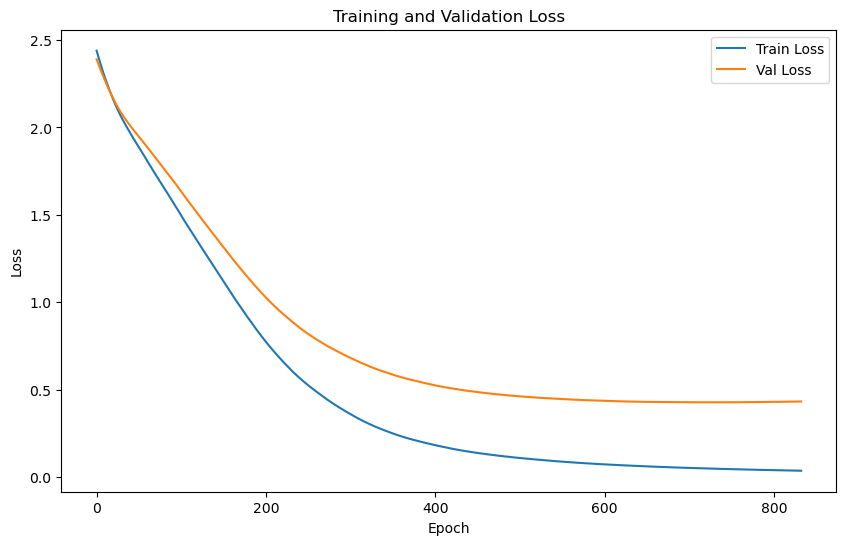

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.2626 | Test Accuracy: 93.05%


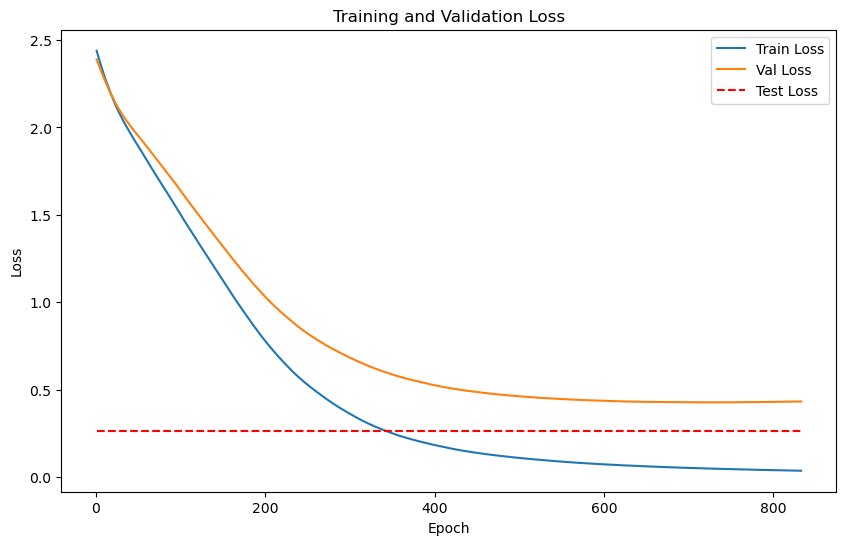

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4068
Epoch [1/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4068

Validation loss improved from inf to 0.4068. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4079
Epoch [2/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4079

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4097
Epoch [3/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4097

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [4/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4107

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4110
Epoch [5/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4110

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4105
Epoch [6/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4105

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.4096
Epoch [7/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4096

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4088
Epoch [8/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4088

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4077
Epoch [9/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4077

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4062
Epoch [10/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.4062

Validation loss improved from 0.4068 to 0.4062. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4051
Epoch [11/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4051

Validation loss improved from 0.4062 to 0.4051. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4041
Epoch [12/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4041

Validation loss improved from 0.4051 to 0.4041. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [13/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4030

Validation loss improved from 0.4041 to 0.4030. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4020
Epoch [14/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.4020

Validation loss improved from 0.4030 to 0.4020. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [15/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4011

Validation loss improved from 0.4020 to 0.4011. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [16/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4002

Validation loss improved from 0.4011 to 0.4002. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3995
Epoch [17/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3995

Validation loss improved from 0.4002 to 0.3995. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.3989
Epoch [18/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3989

Validation loss improved from 0.3995 to 0.3989. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3985
Epoch [19/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3985

Validation loss improved from 0.3989 to 0.3985. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3981
Epoch [20/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3981

Validation loss improved from 0.3985 to 0.3981. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3976
Epoch [21/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3976

Validation loss improved from 0.3981 to 0.3976. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3973
Epoch [22/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.3973

Validation loss improved from 0.3976 to 0.3973. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3970
Epoch [23/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3970

Validation loss improved from 0.3973 to 0.3970. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3968
Epoch [24/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3968

Validation loss improved from 0.3970 to 0.3968. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3965
Epoch [25/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3965

Validation loss improved from 0.3968 to 0.3965. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [26/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3962

Validation loss improved from 0.3965 to 0.3962. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.3959
Epoch [27/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3959

Validation loss improved from 0.3962 to 0.3959. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [28/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3957

Validation loss improved from 0.3959 to 0.3957. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.3954
Epoch [29/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3954

Validation loss improved from 0.3957 to 0.3954. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [30/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3951

Validation loss improved from 0.3954 to 0.3951. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.3948
Epoch [31/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3948

Validation loss improved from 0.3951 to 0.3948. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3945
Epoch [32/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3945

Validation loss improved from 0.3948 to 0.3945. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3942
Epoch [33/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3942

Validation loss improved from 0.3945 to 0.3942. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3938
Epoch [34/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3938

Validation loss improved from 0.3942 to 0.3938. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3935
Epoch [35/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.3935

Validation loss improved from 0.3938 to 0.3935. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3932
Epoch [36/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3932

Validation loss improved from 0.3935 to 0.3932. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [37/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3928

Validation loss improved from 0.3932 to 0.3928. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3924
Epoch [38/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3924

Validation loss improved from 0.3928 to 0.3924. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [39/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.3920

Validation loss improved from 0.3924 to 0.3920. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [40/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.3916

Validation loss improved from 0.3920 to 0.3916. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [41/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3913

Validation loss improved from 0.3916 to 0.3913. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3909
Epoch [42/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3909

Validation loss improved from 0.3913 to 0.3909. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.3905
Epoch [43/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3905

Validation loss improved from 0.3909 to 0.3905. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [44/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3902

Validation loss improved from 0.3905 to 0.3902. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3898
Epoch [45/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.3898

Validation loss improved from 0.3902 to 0.3898. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [46/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3894

Validation loss improved from 0.3898 to 0.3894. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3890
Epoch [47/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.3890

Validation loss improved from 0.3894 to 0.3890. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3886
Epoch [48/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3886

Validation loss improved from 0.3890 to 0.3886. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3882
Epoch [49/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.3882

Validation loss improved from 0.3886 to 0.3882. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [50/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3878

Validation loss improved from 0.3882 to 0.3878. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3874
Epoch [51/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3874

Validation loss improved from 0.3878 to 0.3874. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3870
Epoch [52/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3870

Validation loss improved from 0.3874 to 0.3870. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3866
Epoch [53/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3866

Validation loss improved from 0.3870 to 0.3866. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3862
Epoch [54/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3862

Validation loss improved from 0.3866 to 0.3862. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [55/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3858

Validation loss improved from 0.3862 to 0.3858. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [56/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3855

Validation loss improved from 0.3858 to 0.3855. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [57/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3851

Validation loss improved from 0.3855 to 0.3851. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [58/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3847

Validation loss improved from 0.3851 to 0.3847. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [59/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3844

Validation loss improved from 0.3847 to 0.3844. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.3840
Epoch [60/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3840

Validation loss improved from 0.3844 to 0.3840. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [61/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3836

Validation loss improved from 0.3840 to 0.3836. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3832
Epoch [62/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.3832

Validation loss improved from 0.3836 to 0.3832. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [63/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.3828

Validation loss improved from 0.3832 to 0.3828. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [64/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3824

Validation loss improved from 0.3828 to 0.3824. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [65/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3820

Validation loss improved from 0.3824 to 0.3820. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [66/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3816

Validation loss improved from 0.3820 to 0.3816. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [67/2000] - Validation


    Batch [1/1], Val Loss: 0.3812
Epoch [67/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3812

Validation loss improved from 0.3816 to 0.3812. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3807
Epoch [68/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3807

Validation loss improved from 0.3812 to 0.3807. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [69/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3803

Validation loss improved from 0.3807 to 0.3803. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [70/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3799

Validation loss improved from 0.3803 to 0.3799. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3795
Epoch [71/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3795

Validation loss improved from 0.3799 to 0.3795. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [72/2000] - Validation


    Batch [1/1], Val Loss: 0.3790
Epoch [72/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3790

Validation loss improved from 0.3795 to 0.3790. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [73/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3786

Validation loss improved from 0.3790 to 0.3786. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [74/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3781

Validation loss improved from 0.3786 to 0.3781. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [75/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3777

Validation loss improved from 0.3781 to 0.3777. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [76/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3773

Validation loss improved from 0.3777 to 0.3773. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [77/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3769

Validation loss improved from 0.3773 to 0.3769. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [78/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3765

Validation loss improved from 0.3769 to 0.3765. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [79/2000] - Validation


    Batch [1/1], Val Loss: 0.3760
Epoch [79/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3760

Validation loss improved from 0.3765 to 0.3760. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [80/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.3756

Validation loss improved from 0.3760 to 0.3756. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3752
Epoch [81/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3752

Validation loss improved from 0.3756 to 0.3752. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [82/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3748

Validation loss improved from 0.3752 to 0.3748. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [83/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3744

Validation loss improved from 0.3748 to 0.3744. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [84/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.3739

Validation loss improved from 0.3744 to 0.3739. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [85/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3735

Validation loss improved from 0.3739 to 0.3735. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [86/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.3731

Validation loss improved from 0.3735 to 0.3731. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3726
Epoch [87/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3726

Validation loss improved from 0.3731 to 0.3726. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [88/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3722

Validation loss improved from 0.3726 to 0.3722. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [89/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.3717

Validation loss improved from 0.3722 to 0.3717. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [90/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.3713

Validation loss improved from 0.3717 to 0.3713. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [91/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3709

Validation loss improved from 0.3713 to 0.3709. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [92/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.3704

Validation loss improved from 0.3709 to 0.3704. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [93/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3700

Validation loss improved from 0.3704 to 0.3700. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3696
Epoch [94/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3696

Validation loss improved from 0.3700 to 0.3696. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [95/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3692

Validation loss improved from 0.3696 to 0.3692. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3689
Epoch [96/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.3689

Validation loss improved from 0.3692 to 0.3689. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [97/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3685

Validation loss improved from 0.3689 to 0.3685. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [98/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3681

Validation loss improved from 0.3685 to 0.3681. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.3676
Epoch [99/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3676

Validation loss improved from 0.3681 to 0.3676. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [100/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3672

Validation loss improved from 0.3676 to 0.3672. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3667
Epoch [101/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.3667

Validation loss improved from 0.3672 to 0.3667. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [102/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.3663

Validation loss improved from 0.3667 to 0.3663. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [103/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3659

Validation loss improved from 0.3663 to 0.3659. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [104/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3655

Validation loss improved from 0.3659 to 0.3655. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [105/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3651

Validation loss improved from 0.3655 to 0.3651. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [106/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.3647

Validation loss improved from 0.3651 to 0.3647. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [107/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3644

Validation loss improved from 0.3647 to 0.3644. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3640
Epoch [108/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3640

Validation loss improved from 0.3644 to 0.3640. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [109/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3636

Validation loss improved from 0.3640 to 0.3636. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [110/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3633

Validation loss improved from 0.3636 to 0.3633. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [111/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3629

Validation loss improved from 0.3633 to 0.3629. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [112/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3626

Validation loss improved from 0.3629 to 0.3626. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [113/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3622

Validation loss improved from 0.3626 to 0.3622. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [114/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3619

Validation loss improved from 0.3622 to 0.3619. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [115/2000] - Validation


    Batch [1/1], Val Loss: 0.3615
Epoch [115/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3615

Validation loss improved from 0.3619 to 0.3615. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [116/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3612

Validation loss improved from 0.3615 to 0.3612. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.3609
Epoch [117/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3609

Validation loss improved from 0.3612 to 0.3609. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [118/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3606

Validation loss improved from 0.3609 to 0.3606. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [119/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3603

Validation loss improved from 0.3606 to 0.3603. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [120/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3601

Validation loss improved from 0.3603 to 0.3601. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [121/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.3598

Validation loss improved from 0.3601 to 0.3598. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [122/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3596

Validation loss improved from 0.3598 to 0.3596. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [123/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.3593

Validation loss improved from 0.3596 to 0.3593. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [124/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3591

Validation loss improved from 0.3593 to 0.3591. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [125/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.3588

Validation loss improved from 0.3591 to 0.3588. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [126/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3586

Validation loss improved from 0.3588 to 0.3586. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3583
Epoch [127/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3583

Validation loss improved from 0.3586 to 0.3583. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [128/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3580

Validation loss improved from 0.3583 to 0.3580. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [129/2000] - Validation


    Batch [1/1], Val Loss: 0.3577
Epoch [129/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3577

Validation loss improved from 0.3580 to 0.3577. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3574
Epoch [130/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3574

Validation loss improved from 0.3577 to 0.3574. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [131/2000] - Validation


    Batch [1/1], Val Loss: 0.3571
Epoch [131/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3571

Validation loss improved from 0.3574 to 0.3571. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [132/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3568

Validation loss improved from 0.3571 to 0.3568. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [133/2000] - Validation


    Batch [1/1], Val Loss: 0.3565
Epoch [133/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.3565

Validation loss improved from 0.3568 to 0.3565. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [134/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3562

Validation loss improved from 0.3565 to 0.3562. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [135/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.3558

Validation loss improved from 0.3562 to 0.3558. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [136/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.3554

Validation loss improved from 0.3558 to 0.3554. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3551
Epoch [137/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3551

Validation loss improved from 0.3554 to 0.3551. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [138/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3547

Validation loss improved from 0.3551 to 0.3547. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [139/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.3543

Validation loss improved from 0.3547 to 0.3543. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [140/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3540

Validation loss improved from 0.3543 to 0.3540. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [141/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.3536

Validation loss improved from 0.3540 to 0.3536. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [142/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3533

Validation loss improved from 0.3536 to 0.3533. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [143/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.3529

Validation loss improved from 0.3533 to 0.3529. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3526
Epoch [144/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.3526

Validation loss improved from 0.3529 to 0.3526. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [145/2000] - Validation


    Batch [1/1], Val Loss: 0.3523
Epoch [145/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3523

Validation loss improved from 0.3526 to 0.3523. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [146/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3519

Validation loss improved from 0.3523 to 0.3519. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3516
Epoch [147/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.3516

Validation loss improved from 0.3519 to 0.3516. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [148/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3513

Validation loss improved from 0.3516 to 0.3513. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [149/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.3509

Validation loss improved from 0.3513 to 0.3509. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3506
Epoch [150/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.3506

Validation loss improved from 0.3509 to 0.3506. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [151/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.3503

Validation loss improved from 0.3506 to 0.3503. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.3500
Epoch [152/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.3500

Validation loss improved from 0.3503 to 0.3500. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3497
Epoch [153/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.3497

Validation loss improved from 0.3500 to 0.3497. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [154/2000] - Validation


    Batch [1/1], Val Loss: 0.3494
Epoch [154/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.3494

Validation loss improved from 0.3497 to 0.3494. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3491
Epoch [155/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3491

Validation loss improved from 0.3494 to 0.3491. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [156/2000] - Validation


    Batch [1/1], Val Loss: 0.3488
Epoch [156/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3488

Validation loss improved from 0.3491 to 0.3488. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [157/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3485

Validation loss improved from 0.3488 to 0.3485. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.3482
Epoch [158/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.3482

Validation loss improved from 0.3485 to 0.3482. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [159/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.3480

Validation loss improved from 0.3482 to 0.3480. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.3477
Epoch [160/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.3477

Validation loss improved from 0.3480 to 0.3477. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [161/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3474

Validation loss improved from 0.3477 to 0.3474. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [162/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.3471

Validation loss improved from 0.3474 to 0.3471. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [163/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.3468

Validation loss improved from 0.3471 to 0.3468. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [164/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3466

Validation loss improved from 0.3468 to 0.3466. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [165/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.3463

Validation loss improved from 0.3466 to 0.3463. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [166/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.3461

Validation loss improved from 0.3463 to 0.3461. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3458
Epoch [167/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3458

Validation loss improved from 0.3461 to 0.3458. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3124
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [168/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.3457

Validation loss improved from 0.3458 to 0.3457. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [169/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3455

Validation loss improved from 0.3457 to 0.3455. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [170/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.3453

Validation loss improved from 0.3455 to 0.3453. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3451
Epoch [171/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3451

Validation loss improved from 0.3453 to 0.3451. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.3448
Epoch [172/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3448

Validation loss improved from 0.3451 to 0.3448. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [173/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.3446

Validation loss improved from 0.3448 to 0.3446. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3444
Epoch [174/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.3444

Validation loss improved from 0.3446 to 0.3444. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [175/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3442

Validation loss improved from 0.3444 to 0.3442. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [176/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.3439

Validation loss improved from 0.3442 to 0.3439. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [177/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.3437

Validation loss improved from 0.3439 to 0.3437. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [178/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.3435

Validation loss improved from 0.3437 to 0.3435. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [179/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.3434

Validation loss improved from 0.3435 to 0.3434. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [180/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.3432

Validation loss improved from 0.3434 to 0.3432. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3430
Epoch [181/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3430

Validation loss improved from 0.3432 to 0.3430. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [182/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.3428

Validation loss improved from 0.3430 to 0.3428. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.3426
Epoch [183/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3426

Validation loss improved from 0.3428 to 0.3426. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [184/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.3423

Validation loss improved from 0.3426 to 0.3423. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.3421
Epoch [185/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3421

Validation loss improved from 0.3423 to 0.3421. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [186/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.3419

Validation loss improved from 0.3421 to 0.3419. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [187/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3418

Validation loss improved from 0.3419 to 0.3418. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [188/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3416

Validation loss improved from 0.3418 to 0.3416. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3414
Epoch [189/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3414

Validation loss improved from 0.3416 to 0.3414. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [190/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.3412

Validation loss improved from 0.3414 to 0.3412. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [191/2000] - Validation


    Batch [1/1], Val Loss: 0.3410
Epoch [191/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3410

Validation loss improved from 0.3412 to 0.3410. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [192/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3408

Validation loss improved from 0.3410 to 0.3408. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [193/2000] - Validation


    Batch [1/1], Val Loss: 0.3406
Epoch [193/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3406

Validation loss improved from 0.3408 to 0.3406. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [194/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3404

Validation loss improved from 0.3406 to 0.3404. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [195/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.3402

Validation loss improved from 0.3404 to 0.3402. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [196/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3400

Validation loss improved from 0.3402 to 0.3400. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [197/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.3398

Validation loss improved from 0.3400 to 0.3398. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3396
Epoch [198/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.3396

Validation loss improved from 0.3398 to 0.3396. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [199/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.3394

Validation loss improved from 0.3396 to 0.3394. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.3392
Epoch [200/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.3392

Validation loss improved from 0.3394 to 0.3392. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [201/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3390

Validation loss improved from 0.3392 to 0.3390. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [202/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3388

Validation loss improved from 0.3390 to 0.3388. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [203/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.3387

Validation loss improved from 0.3388 to 0.3387. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [204/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3385

Validation loss improved from 0.3387 to 0.3385. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [205/2000] - Validation


    Batch [1/1], Val Loss: 0.3383
Epoch [205/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.3383

Validation loss improved from 0.3385 to 0.3383. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [206/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.3381

Validation loss improved from 0.3383 to 0.3381. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [207/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3379

Validation loss improved from 0.3381 to 0.3379. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [208/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3377

Validation loss improved from 0.3379 to 0.3377. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [209/2000] - Validation


    Batch [1/1], Val Loss: 0.3375
Epoch [209/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.3375

Validation loss improved from 0.3377 to 0.3375. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [210/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.3373

Validation loss improved from 0.3375 to 0.3373. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [211/2000] - Validation


    Batch [1/1], Val Loss: 0.3371
Epoch [211/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3371

Validation loss improved from 0.3373 to 0.3371. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [212/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3370

Validation loss improved from 0.3371 to 0.3370. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3368
Epoch [213/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.3368

Validation loss improved from 0.3370 to 0.3368. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [214/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3365

Validation loss improved from 0.3368 to 0.3365. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [215/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3363

Validation loss improved from 0.3365 to 0.3363. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [216/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3360

Validation loss improved from 0.3363 to 0.3360. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [217/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3358

Validation loss improved from 0.3360 to 0.3358. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.3356
Epoch [218/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.3356

Validation loss improved from 0.3358 to 0.3356. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [219/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3354

Validation loss improved from 0.3356 to 0.3354. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3352
Epoch [220/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3352

Validation loss improved from 0.3354 to 0.3352. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [221/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3350

Validation loss improved from 0.3352 to 0.3350. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [222/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3348

Validation loss improved from 0.3350 to 0.3348. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.3346
Epoch [223/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3346

Validation loss improved from 0.3348 to 0.3346. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [224/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.3344

Validation loss improved from 0.3346 to 0.3344. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.3341
Epoch [225/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.3341

Validation loss improved from 0.3344 to 0.3341. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [226/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3339

Validation loss improved from 0.3341 to 0.3339. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [227/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.3337

Validation loss improved from 0.3339 to 0.3337. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [228/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.3335

Validation loss improved from 0.3337 to 0.3335. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [229/2000] - Validation


    Batch [1/1], Val Loss: 0.3333
Epoch [229/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [230/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3331

Validation loss improved from 0.3333 to 0.3331. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [231/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3330

Validation loss improved from 0.3331 to 0.3330. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [232/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.3329

Validation loss improved from 0.3330 to 0.3329. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [233/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3327

Validation loss improved from 0.3329 to 0.3327. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [234/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3326

Validation loss improved from 0.3327 to 0.3326. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [235/2000] - Validation


    Batch [1/1], Val Loss: 0.3325
Epoch [235/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3325

Validation loss improved from 0.3326 to 0.3325. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [236/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.3323

Validation loss improved from 0.3325 to 0.3323. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [237/2000] - Validation


    Batch [1/1], Val Loss: 0.3322
Epoch [237/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.3322

Validation loss improved from 0.3323 to 0.3322. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [238/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.3321

Validation loss improved from 0.3322 to 0.3321. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.3319
Epoch [239/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.3319

Validation loss improved from 0.3321 to 0.3319. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [240/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.3317

Validation loss improved from 0.3319 to 0.3317. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.3316
Epoch [241/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3316

Validation loss improved from 0.3317 to 0.3316. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [242/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.3314

Validation loss improved from 0.3316 to 0.3314. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.3313
Epoch [243/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.3313

Validation loss improved from 0.3314 to 0.3313. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3311
Epoch [244/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3311

Validation loss improved from 0.3313 to 0.3311. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3310
Epoch [245/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3310

Validation loss improved from 0.3311 to 0.3310. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [246/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.3308

Validation loss improved from 0.3310 to 0.3308. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.3307
Epoch [247/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3307

Validation loss improved from 0.3308 to 0.3307. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [248/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3306

Validation loss improved from 0.3307 to 0.3306. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [249/2000] - Validation


    Batch [1/1], Val Loss: 0.3304
Epoch [249/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.3304

Validation loss improved from 0.3306 to 0.3304. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [250/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3303

Validation loss improved from 0.3304 to 0.3303. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.3302
Epoch [251/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.3302

Validation loss improved from 0.3303 to 0.3302. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [252/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3300

Validation loss improved from 0.3302 to 0.3300. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3299
Epoch [253/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.3299

Validation loss improved from 0.3300 to 0.3299. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [254/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3297

Validation loss improved from 0.3299 to 0.3297. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3295
Epoch [255/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.3295

Validation loss improved from 0.3297 to 0.3295. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.3293
Epoch [256/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3293

Validation loss improved from 0.3295 to 0.3293. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [257/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.3291

Validation loss improved from 0.3293 to 0.3291. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [258/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3289

Validation loss improved from 0.3291 to 0.3289. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [259/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3287

Validation loss improved from 0.3289 to 0.3287. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [260/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.3284

Validation loss improved from 0.3287 to 0.3284. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [261/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.3282

Validation loss improved from 0.3284 to 0.3282. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3280
Epoch [262/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.3280

Validation loss improved from 0.3282 to 0.3280. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3278
Epoch [263/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3278

Validation loss improved from 0.3280 to 0.3278. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3276
Epoch [264/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.3276

Validation loss improved from 0.3278 to 0.3276. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [265/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.3274

Validation loss improved from 0.3276 to 0.3274. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [266/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.3272

Validation loss improved from 0.3274 to 0.3272. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.3271
Epoch [267/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.3271

Validation loss improved from 0.3272 to 0.3271. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [268/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3269

Validation loss improved from 0.3271 to 0.3269. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [269/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3268

Validation loss improved from 0.3269 to 0.3268. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [270/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.3266

Validation loss improved from 0.3268 to 0.3266. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [271/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3265

Validation loss improved from 0.3266 to 0.3265. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [272/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.3264

Validation loss improved from 0.3265 to 0.3264. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [273/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.3263

Validation loss improved from 0.3264 to 0.3263. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [274/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.3262

Validation loss improved from 0.3263 to 0.3262. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [275/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3260

Validation loss improved from 0.3262 to 0.3260. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [276/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3259

Validation loss improved from 0.3260 to 0.3259. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [277/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.3259

Validation loss improved from 0.3259 to 0.3259. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [278/2000] - Validation


    Batch [1/1], Val Loss: 0.3258
Epoch [278/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.3258

Validation loss improved from 0.3259 to 0.3258. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [279/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3257

Validation loss improved from 0.3258 to 0.3257. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.3256
Epoch [280/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3256

Validation loss improved from 0.3257 to 0.3256. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [281/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3254

Validation loss improved from 0.3256 to 0.3254. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [282/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3253

Validation loss improved from 0.3254 to 0.3253. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [283/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.3252

Validation loss improved from 0.3253 to 0.3252. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [284/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.3250

Validation loss improved from 0.3252 to 0.3250. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [285/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.3249

Validation loss improved from 0.3250 to 0.3249. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3247
Epoch [286/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3247

Validation loss improved from 0.3249 to 0.3247. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [287/2000] - Validation


    Batch [1/1], Val Loss: 0.3245
Epoch [287/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.3245

Validation loss improved from 0.3247 to 0.3245. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [288/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.3244

Validation loss improved from 0.3245 to 0.3244. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [289/2000] - Validation


    Batch [1/1], Val Loss: 0.3242
Epoch [289/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.3242

Validation loss improved from 0.3244 to 0.3242. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [290/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.3240

Validation loss improved from 0.3242 to 0.3240. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.3239
Epoch [291/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.3239

Validation loss improved from 0.3240 to 0.3239. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [292/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.3238

Validation loss improved from 0.3239 to 0.3238. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [293/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3236

Validation loss improved from 0.3238 to 0.3236. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3235
Epoch [294/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.3235

Validation loss improved from 0.3236 to 0.3235. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [295/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3234

Validation loss improved from 0.3235 to 0.3234. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [296/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.3232

Validation loss improved from 0.3234 to 0.3232. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [297/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.3231

Validation loss improved from 0.3232 to 0.3231. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3230
Epoch [298/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.3230

Validation loss improved from 0.3231 to 0.3230. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3228
Epoch [299/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.3228

Validation loss improved from 0.3230 to 0.3228. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [300/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.3227

Validation loss improved from 0.3228 to 0.3227. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [301/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3225

Validation loss improved from 0.3227 to 0.3225. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [302/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.3223

Validation loss improved from 0.3225 to 0.3223. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.3222
Epoch [303/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.3222

Validation loss improved from 0.3223 to 0.3222. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3220
Epoch [304/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.3220

Validation loss improved from 0.3222 to 0.3220. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [305/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3219

Validation loss improved from 0.3220 to 0.3219. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3217
Epoch [306/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3217

Validation loss improved from 0.3219 to 0.3217. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3216
Epoch [307/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3216

Validation loss improved from 0.3217 to 0.3216. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [308/2000] - Validation


    Batch [1/1], Val Loss: 0.3214
Epoch [308/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.3214

Validation loss improved from 0.3216 to 0.3214. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [309/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3212

Validation loss improved from 0.3214 to 0.3212. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [310/2000] - Validation


    Batch [1/1], Val Loss: 0.3211
Epoch [310/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.3211

Validation loss improved from 0.3212 to 0.3211. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [311/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3210

Validation loss improved from 0.3211 to 0.3210. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.3209
Epoch [312/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.3209

Validation loss improved from 0.3210 to 0.3209. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [313/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.3207

Validation loss improved from 0.3209 to 0.3207. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [314/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.3206

Validation loss improved from 0.3207 to 0.3206. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [315/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.3205

Validation loss improved from 0.3206 to 0.3205. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3204
Epoch [316/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.3204

Validation loss improved from 0.3205 to 0.3204. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.3203
Epoch [317/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.3203

Validation loss improved from 0.3204 to 0.3203. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [318/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.3202

Validation loss improved from 0.3203 to 0.3202. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.3201
Epoch [319/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.3201

Validation loss improved from 0.3202 to 0.3201. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [320/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.3200

Validation loss improved from 0.3201 to 0.3200. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [321/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.3200

Validation loss improved from 0.3200 to 0.3200. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2438
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [322/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.3199

Validation loss improved from 0.3200 to 0.3199. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [323/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.3199

Validation loss improved from 0.3199 to 0.3199. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [324/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3198

Validation loss improved from 0.3199 to 0.3198. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [325/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.3197

Validation loss improved from 0.3198 to 0.3197. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.3196
Epoch [326/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.3196

Validation loss improved from 0.3197 to 0.3196. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [327/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3195

Validation loss improved from 0.3196 to 0.3195. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [328/2000] - Validation


    Batch [1/1], Val Loss: 0.3195
Epoch [328/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.3195

Validation loss improved from 0.3195 to 0.3195. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [329/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.3194

Validation loss improved from 0.3195 to 0.3194. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.3193
Epoch [330/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.3193

Validation loss improved from 0.3194 to 0.3193. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3192
Epoch [331/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.3192

Validation loss improved from 0.3193 to 0.3192. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [332/2000] - Validation


    Batch [1/1], Val Loss: 0.3191
Epoch [332/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3191

Validation loss improved from 0.3192 to 0.3191. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3190
Epoch [333/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.3190

Validation loss improved from 0.3191 to 0.3190. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [334/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.3188

Validation loss improved from 0.3190 to 0.3188. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3187
Epoch [335/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.3187

Validation loss improved from 0.3188 to 0.3187. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3186
Epoch [336/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.3186

Validation loss improved from 0.3187 to 0.3186. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [337/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.3185

Validation loss improved from 0.3186 to 0.3185. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.3184
Epoch [338/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.3184

Validation loss improved from 0.3185 to 0.3184. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [339/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.3183

Validation loss improved from 0.3184 to 0.3183. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2395
LOG: Epoch [340/2000] - Validation


    Batch [1/1], Val Loss: 0.3182
Epoch [340/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.3182

Validation loss improved from 0.3183 to 0.3182. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [341/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.3182

Validation loss improved from 0.3182 to 0.3182. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [342/2000] - Validation


    Batch [1/1], Val Loss: 0.3181
Epoch [342/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.3181

Validation loss improved from 0.3182 to 0.3181. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [343/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.3179

Validation loss improved from 0.3181 to 0.3179. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2192
LOG: Epoch [344/2000] - Validation


    Batch [1/1], Val Loss: 0.3178
Epoch [344/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.3178

Validation loss improved from 0.3179 to 0.3178. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2351
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [345/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.3176

Validation loss improved from 0.3178 to 0.3176. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [346/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.3175

Validation loss improved from 0.3176 to 0.3175. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3174
Epoch [347/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3174

Validation loss improved from 0.3175 to 0.3174. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [348/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.3173

Validation loss improved from 0.3174 to 0.3173. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.3172
Epoch [349/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [350/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.3172

Validation loss improved from 0.3172 to 0.3172. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [351/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.3171

Validation loss improved from 0.3172 to 0.3171. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2376
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [352/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.3169

Validation loss improved from 0.3171 to 0.3169. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [353/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.3168

Validation loss improved from 0.3169 to 0.3168. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.3166
Epoch [354/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.3166

Validation loss improved from 0.3168 to 0.3166. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3164
Epoch [355/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.3164

Validation loss improved from 0.3166 to 0.3164. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [356/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.3163

Validation loss improved from 0.3164 to 0.3163. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [357/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3161

Validation loss improved from 0.3163 to 0.3161. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [358/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.3159

Validation loss improved from 0.3161 to 0.3159. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [359/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.3158

Validation loss improved from 0.3159 to 0.3158. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3156
Epoch [360/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3156

Validation loss improved from 0.3158 to 0.3156. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2401
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3155
Epoch [361/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.3155

Validation loss improved from 0.3156 to 0.3155. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [362/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.3154

Validation loss improved from 0.3155 to 0.3154. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [363/2000] - Validation


    Batch [1/1], Val Loss: 0.3154
Epoch [363/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.3154

Validation loss improved from 0.3154 to 0.3154. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [364/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.3153

Validation loss improved from 0.3154 to 0.3153. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.3152
Epoch [365/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.3152

Validation loss improved from 0.3153 to 0.3152. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [366/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3151

Validation loss improved from 0.3152 to 0.3151. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [367/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.3151

Validation loss improved from 0.3151 to 0.3151. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [368/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.3151

Validation loss improved from 0.3151 to 0.3151. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [369/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.3150

Validation loss improved from 0.3151 to 0.3150. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.3150
Epoch [370/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.3150

Validation loss improved from 0.3150 to 0.3150. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [371/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.3149

Validation loss improved from 0.3150 to 0.3149. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3149
Epoch [372/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.3149

Validation loss improved from 0.3149 to 0.3149. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [373/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3148

Validation loss improved from 0.3149 to 0.3148. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3147
Epoch [374/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.3147

Validation loss improved from 0.3148 to 0.3147. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [375/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3146

Validation loss improved from 0.3147 to 0.3146. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [376/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.3146

Validation loss improved from 0.3146 to 0.3146. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [377/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.3145

Validation loss improved from 0.3146 to 0.3145. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [378/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3145

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [379/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [380/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [381/2000] - Validation


    Batch [1/1], Val Loss: 0.3146
Epoch [381/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [382/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [383/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [384/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [385/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [386/2000] - Validation


    Batch [1/1], Val Loss: 0.3146
Epoch [386/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [387/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.3145

Validation loss improved from 0.3145 to 0.3145. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [388/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.3144

Validation loss improved from 0.3145 to 0.3144. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [389/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3142

Validation loss improved from 0.3144 to 0.3142. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [390/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3141

Validation loss improved from 0.3142 to 0.3141. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [391/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.3139

Validation loss improved from 0.3141 to 0.3139. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [392/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.3138

Validation loss improved from 0.3139 to 0.3138. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.3138
Epoch [393/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.3138

Validation loss improved from 0.3138 to 0.3138. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [394/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3137

Validation loss improved from 0.3138 to 0.3137. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3136
Epoch [395/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.3136

Validation loss improved from 0.3137 to 0.3136. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2203
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [396/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.3136

Validation loss improved from 0.3136 to 0.3136. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [397/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.3135

Validation loss improved from 0.3136 to 0.3135. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [398/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3133

Validation loss improved from 0.3135 to 0.3133. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [399/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.3132

Validation loss improved from 0.3133 to 0.3132. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [400/2000] - Validation


    Batch [1/1], Val Loss: 0.3130
Epoch [400/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.3130

Validation loss improved from 0.3132 to 0.3130. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [401/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.3128

Validation loss improved from 0.3130 to 0.3128. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.3126
Epoch [402/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.3126

Validation loss improved from 0.3128 to 0.3126. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [403/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.3124

Validation loss improved from 0.3126 to 0.3124. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [404/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3122

Validation loss improved from 0.3124 to 0.3122. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3120
Epoch [405/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.3120

Validation loss improved from 0.3122 to 0.3120. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3118
Epoch [406/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3118

Validation loss improved from 0.3120 to 0.3118. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [407/2000] - Validation


    Batch [1/1], Val Loss: 0.3117
Epoch [407/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3117

Validation loss improved from 0.3118 to 0.3117. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [408/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3116

Validation loss improved from 0.3117 to 0.3116. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [409/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3116

Validation loss improved from 0.3116 to 0.3116. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [410/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.3115

Validation loss improved from 0.3116 to 0.3115. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [411/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.3115

Validation loss improved from 0.3115 to 0.3115. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [412/2000] - Validation


    Batch [1/1], Val Loss: 0.3115
Epoch [412/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.3115

Validation loss improved from 0.3115 to 0.3115. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [413/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [414/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [415/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3114

Validation loss improved from 0.3115 to 0.3114. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [416/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [417/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [418/2000] - Validation


    Batch [1/1], Val Loss: 0.3115
Epoch [418/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [419/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.3116

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [420/2000] - Validation


    Batch [1/1], Val Loss: 0.3116
Epoch [420/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.3116

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [421/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3116

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.3116
Epoch [422/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.3116

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [423/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3116

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [424/2000] - Validation


    Batch [1/1], Val Loss: 0.3116
Epoch [424/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.3116

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [425/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [426/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.3114

Validation loss improved from 0.3114 to 0.3114. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [427/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.3113

Validation loss improved from 0.3114 to 0.3113. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [428/2000] - Validation


    Batch [1/1], Val Loss: 0.3112
Epoch [428/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.3112

Validation loss improved from 0.3113 to 0.3112. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [429/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3112

Validation loss improved from 0.3112 to 0.3112. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [430/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3111

Validation loss improved from 0.3112 to 0.3111. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [431/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.3111

Validation loss improved from 0.3111 to 0.3111. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [432/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3111

Validation loss improved from 0.3111 to 0.3111. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.3111
Epoch [433/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3111

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [434/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3112

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.3112
Epoch [435/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3112

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [436/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3113

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [437/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.3113

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [438/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3113

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [439/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3112

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [440/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3112

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [441/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3111

Validation loss improved from 0.3111 to 0.3111. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [442/2000] - Validation


    Batch [1/1], Val Loss: 0.3109
Epoch [442/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.3109

Validation loss improved from 0.3111 to 0.3109. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [443/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3107

Validation loss improved from 0.3109 to 0.3107. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3105
Epoch [444/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3105

Validation loss improved from 0.3107 to 0.3105. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [445/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3104

Validation loss improved from 0.3105 to 0.3104. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [446/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.3103

Validation loss improved from 0.3104 to 0.3103. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [447/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3103

Validation loss improved from 0.3103 to 0.3103. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [448/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.3102

Validation loss improved from 0.3103 to 0.3102. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [449/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.3102

Validation loss improved from 0.3102 to 0.3102. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [450/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.3102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [451/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3102

Validation loss improved from 0.3102 to 0.3102. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [452/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3102

Validation loss improved from 0.3102 to 0.3102. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [453/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.3103
Epoch [454/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3103

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [455/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3103

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [456/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3103

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [457/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.3104

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [458/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3104

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [459/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3104

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.3103
Epoch [460/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3103

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [461/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3102

Validation loss improved from 0.3102 to 0.3102. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [462/2000] - Validation


    Batch [1/1], Val Loss: 0.3100
Epoch [462/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.3100

Validation loss improved from 0.3102 to 0.3100. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [463/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.3098

Validation loss improved from 0.3100 to 0.3098. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.3097
Epoch [464/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.3097

Validation loss improved from 0.3098 to 0.3097. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [465/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3097

Validation loss improved from 0.3097 to 0.3097. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [466/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3096

Validation loss improved from 0.3097 to 0.3096. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [467/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.3096

Validation loss improved from 0.3096 to 0.3096. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [468/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [469/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [470/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.3096
Epoch [471/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [472/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [473/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3096

Validation loss improved from 0.3096 to 0.3096. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [474/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [475/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.3096
Epoch [476/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [477/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.3097

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [478/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.3097

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [479/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3097

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [480/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.3097

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.3097
Epoch [481/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.3097

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [482/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [483/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.3095

Validation loss improved from 0.3096 to 0.3095. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3094
Epoch [484/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3094

Validation loss improved from 0.3095 to 0.3094. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [485/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.3092

Validation loss improved from 0.3094 to 0.3092. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [486/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.3091

Validation loss improved from 0.3092 to 0.3091. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [487/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.3089

Validation loss improved from 0.3091 to 0.3089. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [488/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.3088

Validation loss improved from 0.3089 to 0.3088. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [489/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3087

Validation loss improved from 0.3088 to 0.3087. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.1705
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [490/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.3087

Validation loss improved from 0.3087 to 0.3087. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [491/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.3086

Validation loss improved from 0.3087 to 0.3086. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [492/2000] - Validation


    Batch [1/1], Val Loss: 0.3085
Epoch [492/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3085

Validation loss improved from 0.3086 to 0.3085. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3084
Epoch [493/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.3084

Validation loss improved from 0.3085 to 0.3084. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [494/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.3083

Validation loss improved from 0.3084 to 0.3083. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [495/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.3081

Validation loss improved from 0.3083 to 0.3081. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [496/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.3080

Validation loss improved from 0.3081 to 0.3080. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.3078
Epoch [497/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.3078

Validation loss improved from 0.3080 to 0.3078. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [498/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.3077

Validation loss improved from 0.3078 to 0.3077. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.3077
Epoch [499/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.3077

Validation loss improved from 0.3077 to 0.3077. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [500/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.3076

Validation loss improved from 0.3077 to 0.3076. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [501/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.3075

Validation loss improved from 0.3076 to 0.3075. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [502/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.3075

Validation loss improved from 0.3075 to 0.3075. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [503/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [504/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [505/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [506/2000] - Validation


    Batch [1/1], Val Loss: 0.3075
Epoch [506/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [507/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.3076

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [508/2000] - Validation


    Batch [1/1], Val Loss: 0.3076
Epoch [508/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.3076

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [509/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.3076

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.3076
Epoch [510/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.3076

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [511/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.3076

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1720
LOG: Epoch [512/2000] - Validation


    Batch [1/1], Val Loss: 0.3075
Epoch [512/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.3075

Validation loss improved from 0.3075 to 0.3075. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [513/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.3075

Validation loss improved from 0.3075 to 0.3075. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [514/2000] - Validation


    Batch [1/1], Val Loss: 0.3075
Epoch [514/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [515/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.3075

Validation loss improved from 0.3075 to 0.3075. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [516/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [517/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [518/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [519/2000] - Validation


    Batch [1/1], Val Loss: 0.3075
Epoch [519/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [520/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1721
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [521/2000], Avg Train Loss: 0.1721, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [522/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [523/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [524/2000] - Validation


    Batch [1/1], Val Loss: 0.3075
Epoch [524/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.3075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [525/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.3074

Validation loss improved from 0.3075 to 0.3074. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [526/2000] - Validation


    Batch [1/1], Val Loss: 0.3073
Epoch [526/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.3073

Validation loss improved from 0.3074 to 0.3073. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [527/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.3072

Validation loss improved from 0.3073 to 0.3072. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [528/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.3071

Validation loss improved from 0.3072 to 0.3071. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [529/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.3071

Validation loss improved from 0.3071 to 0.3071. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [530/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.3070

Validation loss improved from 0.3071 to 0.3070. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [531/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.3070

Validation loss improved from 0.3070 to 0.3070. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [532/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.3069

Validation loss improved from 0.3070 to 0.3069. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.3068
Epoch [533/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.3068

Validation loss improved from 0.3069 to 0.3068. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [534/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.3068

Validation loss improved from 0.3068 to 0.3068. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [535/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.3067

Validation loss improved from 0.3068 to 0.3067. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [536/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.3066

Validation loss improved from 0.3067 to 0.3066. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [537/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.3066

Validation loss improved from 0.3066 to 0.3066. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.3065
Epoch [538/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.3065

Validation loss improved from 0.3066 to 0.3065. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [539/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.3065

Validation loss improved from 0.3065 to 0.3065. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.3063
Epoch [540/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.3063

Validation loss improved from 0.3065 to 0.3063. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [541/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.3062

Validation loss improved from 0.3063 to 0.3062. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [542/2000] - Validation


    Batch [1/1], Val Loss: 0.3060
Epoch [542/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.3060

Validation loss improved from 0.3062 to 0.3060. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [543/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.3058

Validation loss improved from 0.3060 to 0.3058. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [544/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.3057

Validation loss improved from 0.3058 to 0.3057. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [545/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.3055

Validation loss improved from 0.3057 to 0.3055. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [546/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.3054
Epoch [547/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1673
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [548/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.3053

Validation loss improved from 0.3054 to 0.3053. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.3053
Epoch [549/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [550/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [551/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [552/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.3052

Validation loss improved from 0.3053 to 0.3052. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [553/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.3051

Validation loss improved from 0.3052 to 0.3051. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [554/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.3050

Validation loss improved from 0.3051 to 0.3050. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [555/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.3050

Validation loss improved from 0.3050 to 0.3050. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [556/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3049

Validation loss improved from 0.3050 to 0.3049. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [557/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.3049

Validation loss improved from 0.3049 to 0.3049. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [558/2000] - Validation


    Batch [1/1], Val Loss: 0.3048
Epoch [558/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.3048

Validation loss improved from 0.3049 to 0.3048. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [559/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.3048

Validation loss improved from 0.3048 to 0.3048. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [560/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.3047

Validation loss improved from 0.3048 to 0.3047. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [561/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [562/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [563/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [564/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [565/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [566/2000] - Validation


    Batch [1/1], Val Loss: 0.3048
Epoch [566/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [567/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [568/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [569/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [570/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [571/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [572/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.3048
Epoch [573/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [574/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [575/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.3047

Validation loss improved from 0.3047 to 0.3047. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [576/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.3046

Validation loss improved from 0.3047 to 0.3046. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.1631
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [577/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.3044

Validation loss improved from 0.3046 to 0.3044. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [578/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.3043

Validation loss improved from 0.3044 to 0.3043. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.1574
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [579/2000], Avg Train Loss: 0.1574, Avg Val Loss: 0.3042

Validation loss improved from 0.3043 to 0.3042. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1600
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [580/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [581/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [581/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1601
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [582/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [583/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [584/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1587
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [585/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [586/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.3041

Validation loss improved from 0.3042 to 0.3041. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [587/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.3041

Validation loss improved from 0.3041 to 0.3041. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1659
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [588/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.3040

Validation loss improved from 0.3041 to 0.3040. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [589/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.3040

Validation loss improved from 0.3040 to 0.3040. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [590/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [591/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [592/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [593/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [594/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [595/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [596/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.1494
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [597/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [598/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1554
LOG: Epoch [599/2000] - Validation


    Batch [1/1], Val Loss: 0.3043
Epoch [599/2000], Avg Train Loss: 0.1554, Avg Val Loss: 0.3043

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [600/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3043

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1666
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [601/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.3043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [602/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.3043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1639
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [603/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [604/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [605/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [606/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.3041

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1627
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [607/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [608/2000] - Validation


    Batch [1/1], Val Loss: 0.3039
Epoch [608/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.3039

Validation loss improved from 0.3040 to 0.3039. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [609/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3038

Validation loss improved from 0.3039 to 0.3038. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [610/2000] - Validation


    Batch [1/1], Val Loss: 0.3037
Epoch [610/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.3037

Validation loss improved from 0.3038 to 0.3037. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [611/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.3036

Validation loss improved from 0.3037 to 0.3036. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [612/2000] - Validation


    Batch [1/1], Val Loss: 0.3035
Epoch [612/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.3035

Validation loss improved from 0.3036 to 0.3035. Saving model...
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1575
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [613/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [614/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [615/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [616/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [617/2000] - Validation


    Batch [1/1], Val Loss: 0.3034
Epoch [617/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.3034

Validation loss improved from 0.3035 to 0.3034. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [618/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.3034

Validation loss improved from 0.3034 to 0.3034. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [619/2000] - Validation


    Batch [1/1], Val Loss: 0.3033
Epoch [619/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.3033

Validation loss improved from 0.3034 to 0.3033. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3033
Epoch [620/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.3033

Validation loss improved from 0.3033 to 0.3033. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3032
Epoch [621/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.3032

Validation loss improved from 0.3033 to 0.3032. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3031
Epoch [622/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.3031

Validation loss improved from 0.3032 to 0.3031. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [623/2000] - Validation


    Batch [1/1], Val Loss: 0.3031
Epoch [623/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.3031

Validation loss improved from 0.3031 to 0.3031. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1588
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [624/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.3029

Validation loss improved from 0.3031 to 0.3029. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.3028
Epoch [625/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.3028

Validation loss improved from 0.3029 to 0.3028. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3028
Epoch [626/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.3028

Validation loss improved from 0.3028 to 0.3028. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [627/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.3029

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.1449
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [628/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.3029

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [629/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.3029

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [630/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.3029

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3028
Epoch [631/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.3028

Validation loss improved from 0.3028 to 0.3028. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1447
LOG: Epoch [632/2000] - Validation


    Batch [1/1], Val Loss: 0.3028
Epoch [632/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.3028

Validation loss improved from 0.3028 to 0.3028. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [633/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.3027

Validation loss improved from 0.3028 to 0.3027. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [634/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.3027

Validation loss improved from 0.3027 to 0.3027. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.1390
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [635/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.3027

Validation loss improved from 0.3027 to 0.3027. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [636/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.3026

Validation loss improved from 0.3027 to 0.3026. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [637/2000] - Validation


    Batch [1/1], Val Loss: 0.3026
Epoch [637/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.3026

Validation loss improved from 0.3026 to 0.3026. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [638/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3026

Validation loss improved from 0.3026 to 0.3026. Saving model...
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [639/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.3026

Validation loss improved from 0.3026 to 0.3026. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [640/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.3024

Validation loss improved from 0.3026 to 0.3024. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [641/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.3023

Validation loss improved from 0.3024 to 0.3023. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [642/2000] - Validation


    Batch [1/1], Val Loss: 0.3022
Epoch [642/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.3022

Validation loss improved from 0.3023 to 0.3022. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [643/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.3022

Validation loss improved from 0.3022 to 0.3022. Saving model...
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [644/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.3021

Validation loss improved from 0.3022 to 0.3021. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [645/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.3021

Validation loss improved from 0.3021 to 0.3021. Saving model...
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [646/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.3021

Validation loss improved from 0.3021 to 0.3021. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [647/2000] - Validation


    Batch [1/1], Val Loss: 0.3021
Epoch [647/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.3021

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1575
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [648/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [649/2000] - Validation


    Batch [1/1], Val Loss: 0.3022
Epoch [649/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1421
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [650/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [651/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3021

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [652/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [653/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [654/2000] - Validation


    Batch [1/1], Val Loss: 0.3023
Epoch [654/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [655/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.3024

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.1481
LOG: Epoch [656/2000] - Validation


    Batch [1/1], Val Loss: 0.3024
Epoch [656/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.3024

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [657/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [658/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [659/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [660/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1408
LOG: Epoch [661/2000] - Validation


    Batch [1/1], Val Loss: 0.3022
Epoch [661/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [662/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [663/2000] - Validation


    Batch [1/1], Val Loss: 0.3023
Epoch [663/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [664/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.3024

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [665/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3024

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [666/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3024

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [667/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.3025

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.1335
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [668/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.3025

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [669/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3026

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [670/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3026

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [671/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3025

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1449
LOG: Epoch [672/2000] - Validation


    Batch [1/1], Val Loss: 0.3025
Epoch [672/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.3025

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1419
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [673/2000], Avg Train Loss: 0.1419, Avg Val Loss: 0.3024

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [674/2000] - Validation


    Batch [1/1], Val Loss: 0.3024
Epoch [674/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.3024

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [675/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [676/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.3023

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [677/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [678/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [679/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3021

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [680/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3021

Validation loss improved from 0.3021 to 0.3021. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [681/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.3021

Validation loss improved from 0.3021 to 0.3021. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1353
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [682/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.3020

Validation loss improved from 0.3021 to 0.3020. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [683/2000] - Validation


    Batch [1/1], Val Loss: 0.3020
Epoch [683/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.3020

Validation loss improved from 0.3020 to 0.3020. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.3019
Epoch [684/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3019

Validation loss improved from 0.3020 to 0.3019. Saving model...
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [685/2000] - Validation


    Batch [1/1], Val Loss: 0.3019
Epoch [685/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.3019

Validation loss improved from 0.3019 to 0.3019. Saving model...
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3019
Epoch [686/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.3019

Validation loss improved from 0.3019 to 0.3019. Saving model...
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [687/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.3018

Validation loss improved from 0.3019 to 0.3018. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [688/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.3018

Validation loss improved from 0.3018 to 0.3018. Saving model...
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [689/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.3018

Validation loss improved from 0.3018 to 0.3018. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [690/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.3017

Validation loss improved from 0.3018 to 0.3017. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [691/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.3017

Validation loss improved from 0.3017 to 0.3017. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [692/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.3017

Validation loss improved from 0.3017 to 0.3017. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [693/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.3017

Validation loss improved from 0.3017 to 0.3017. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.1421
LOG: Epoch [694/2000] - Validation


    Batch [1/1], Val Loss: 0.3016
Epoch [694/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.3016

Validation loss improved from 0.3017 to 0.3016. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1404
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [695/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.3016

Validation loss improved from 0.3016 to 0.3016. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [696/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.3016

Validation loss improved from 0.3016 to 0.3016. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1382
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [697/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.3016

Validation loss improved from 0.3016 to 0.3016. Saving model...
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [698/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.3016

Validation loss improved from 0.3016 to 0.3016. Saving model...
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [699/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.3016

Validation loss improved from 0.3016 to 0.3016. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [700/2000] - Validation


    Batch [1/1], Val Loss: 0.3016
Epoch [700/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.3016

Validation loss improved from 0.3016 to 0.3016. Saving model...
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [701/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.3015

Validation loss improved from 0.3016 to 0.3015. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1408
LOG: Epoch [702/2000] - Validation


    Batch [1/1], Val Loss: 0.3015
Epoch [702/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [703/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1327
LOG: Epoch [704/2000] - Validation


    Batch [1/1], Val Loss: 0.3015
Epoch [704/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.3015

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [705/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.3015

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [706/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [707/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [708/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [709/2000] - Validation


    Batch [1/1], Val Loss: 0.3016
Epoch [709/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [710/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1502
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [711/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.1419
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [712/2000], Avg Train Loss: 0.1419, Avg Val Loss: 0.3015

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.1382
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [713/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [714/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [715/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.1369
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [716/2000], Avg Train Loss: 0.1369, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [717/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [718/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.1301
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [719/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1425
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [720/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.3015

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [721/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.3015

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [722/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3015

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1417
LOG: Epoch [723/2000] - Validation


    Batch [1/1], Val Loss: 0.3015
Epoch [723/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [724/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [725/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.1489
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [726/2000], Avg Train Loss: 0.1489, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [727/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1344
LOG: Epoch [728/2000] - Validation


    Batch [1/1], Val Loss: 0.3015
Epoch [728/2000], Avg Train Loss: 0.1344, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [729/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [730/2000] - Validation


    Batch [1/1], Val Loss: 0.3015
Epoch [730/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [731/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [732/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.3015

Validation loss improved from 0.3015 to 0.3015. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [733/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.3014

Validation loss improved from 0.3015 to 0.3014. Saving model...
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1426
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [734/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [735/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [736/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.1382
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [737/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [738/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1408
LOG: Epoch [739/2000] - Validation


    Batch [1/1], Val Loss: 0.3014
Epoch [739/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [740/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [741/2000] - Validation


    Batch [1/1], Val Loss: 0.3014
Epoch [741/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [742/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [743/2000] - Validation


    Batch [1/1], Val Loss: 0.3014
Epoch [743/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [744/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [745/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [746/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.3014

Validation loss improved from 0.3014 to 0.3014. Saving model...
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [747/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.3013

Validation loss improved from 0.3014 to 0.3013. Saving model...
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [748/2000] - Validation


    Batch [1/1], Val Loss: 0.3013
Epoch [748/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [749/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [750/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [751/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [752/2000] - Validation


    Batch [1/1], Val Loss: 0.3013
Epoch [752/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [753/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [754/2000] - Validation


    Batch [1/1], Val Loss: 0.3013
Epoch [754/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1372
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [755/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [756/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [757/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [758/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1367
LOG: Epoch [759/2000] - Validation


    Batch [1/1], Val Loss: 0.3013
Epoch [759/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [760/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.3013

Validation loss improved from 0.3013 to 0.3013. Saving model...
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [761/2000] - Validation


    Batch [1/1], Val Loss: 0.3012
Epoch [761/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.3012

Validation loss improved from 0.3013 to 0.3012. Saving model...
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [762/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [763/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [764/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [765/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1306
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [766/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [767/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [768/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [769/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1359
LOG: Epoch [770/2000] - Validation


    Batch [1/1], Val Loss: 0.3012
Epoch [770/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [771/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [772/2000] - Validation


    Batch [1/1], Val Loss: 0.3012
Epoch [772/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [773/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.3012

Validation loss improved from 0.3012 to 0.3012. Saving model...
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1413
LOG: Epoch [774/2000] - Validation


    Batch [1/1], Val Loss: 0.3011
Epoch [774/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.3011

Validation loss improved from 0.3012 to 0.3011. Saving model...
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [775/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [776/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [777/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1425
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [778/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [779/2000] - Validation


    Batch [1/1], Val Loss: 0.3011
Epoch [779/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.3011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [780/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [781/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1409
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [782/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [783/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [784/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [785/2000] - Validation


    Batch [1/1], Val Loss: 0.3011
Epoch [785/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [786/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [787/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [788/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [789/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [790/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.3010

Validation loss improved from 0.3011 to 0.3010. Saving model...
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1403
LOG: Epoch [791/2000] - Validation


    Batch [1/1], Val Loss: 0.3010
Epoch [791/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.3010

Validation loss improved from 0.3010 to 0.3010. Saving model...
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [792/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.3010

Validation loss improved from 0.3010 to 0.3010. Saving model...
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [793/2000] - Validation


    Batch [1/1], Val Loss: 0.3010
Epoch [793/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.3010

Validation loss improved from 0.3010 to 0.3010. Saving model...
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1329
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [794/2000], Avg Train Loss: 0.1329, Avg Val Loss: 0.3010

Validation loss improved from 0.3010 to 0.3010. Saving model...
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [795/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.3010

Validation loss improved from 0.3010 to 0.3010. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.1408
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [796/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.3010

Validation loss improved from 0.3010 to 0.3010. Saving model...
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [797/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.3009

Validation loss improved from 0.3010 to 0.3009. Saving model...
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [798/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [798/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [799/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [800/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [800/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [801/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1406
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [802/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [803/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.1354
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [804/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [805/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [806/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [807/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.1361
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [808/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.1332
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [809/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.1365
LOG: Epoch [810/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [810/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [811/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [811/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [812/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.1276
LOG: Epoch [813/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [813/2000], Avg Train Loss: 0.1276, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [814/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [815/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [815/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [816/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [817/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [817/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.1352
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [818/2000], Avg Train Loss: 0.1352, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [819/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.1528
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [820/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [821/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [822/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [822/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [823/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [824/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [825/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [826/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [827/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [828/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [829/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [829/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.3009

Validation loss improved from 0.3009 to 0.3009. Saving model...
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1450
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [830/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.3008

Validation loss improved from 0.3009 to 0.3008. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [831/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [832/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [833/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [833/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [834/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [835/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [835/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [836/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [837/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [837/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [838/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [838/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1446
LOG: Epoch [839/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [839/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [840/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.1339
LOG: Epoch [841/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [841/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [842/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.1409
LOG: Epoch [843/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [843/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [844/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [845/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [845/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [846/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [846/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.1379
LOG: Epoch [847/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [847/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [848/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [849/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [849/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [850/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [850/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.1335
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [851/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.1353
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [852/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.1359
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [853/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [854/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [854/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.3008

Validation loss improved from 0.3008 to 0.3008. Saving model...
LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [855/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [855/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [856/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [856/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [857/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [857/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.1413
LOG: Epoch [858/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [858/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [859/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [859/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [860/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [860/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [861/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [861/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.1331
LOG: Epoch [862/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [862/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [863/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [863/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [864/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [864/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [865/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [865/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [866/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [866/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [867/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [867/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.3007

Validation loss improved from 0.3008 to 0.3007. Saving model...
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.1481
LOG: Epoch [868/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [868/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.3007

Validation loss improved from 0.3007 to 0.3007. Saving model...
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.1317
LOG: Epoch [869/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [869/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.3007

Validation loss improved from 0.3007 to 0.3007. Saving model...
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [870/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [870/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.3007

Validation loss improved from 0.3007 to 0.3007. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [871/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [871/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.3007

Validation loss improved from 0.3007 to 0.3007. Saving model...
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [872/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [872/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.3007

Validation loss improved from 0.3007 to 0.3007. Saving model...
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [873/2000] - Validation


    Batch [1/1], Val Loss: 0.3007
Epoch [873/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.3007

Validation loss improved from 0.3007 to 0.3007. Saving model...
LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [874/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [874/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.3006

Validation loss improved from 0.3007 to 0.3006. Saving model...
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [875/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [875/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [876/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [876/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [877/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [877/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [878/2000] - Validation


    Batch [1/1], Val Loss: 0.3006
Epoch [878/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [879/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [879/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [880/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [880/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [881/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [881/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [882/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [882/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [883/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [883/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [884/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [884/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [885/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [885/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [886/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [886/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [887/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [887/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [888/2000] - Validation


    Batch [1/1], Val Loss: 0.3006
Epoch [888/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [889/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [889/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.1332
LOG: Epoch [890/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [890/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [891/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [891/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [892/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [892/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [893/2000] - Validation


    Batch [1/1], Val Loss: 0.3006
Epoch [893/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.1349
LOG: Epoch [894/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [894/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [895/2000] - Validation


    Batch [1/1], Val Loss: 0.3005
Epoch [895/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.3005

Validation loss improved from 0.3006 to 0.3005. Saving model...
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.1359
LOG: Epoch [896/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [896/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 0.1494
LOG: Epoch [897/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [897/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [898/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [898/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [899/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [899/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [900/2000] - Validation


    Batch [1/1], Val Loss: 0.3005
Epoch [900/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.1446
LOG: Epoch [901/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [901/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [902/2000] - Validation


    Batch [1/1], Val Loss: 0.3005
Epoch [902/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [903/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [903/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 0.1306
LOG: Epoch [904/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [904/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [905/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [905/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [906/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [906/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.1379
LOG: Epoch [907/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [907/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [908/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [908/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [909/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [909/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.1441
LOG: Epoch [910/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [910/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [911/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [911/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [912/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [912/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [913/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [913/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [914/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [914/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [915/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [915/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [916/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [916/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [917/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [917/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [918/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [918/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [919/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [919/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.1359
LOG: Epoch [920/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [920/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 0.1408
LOG: Epoch [921/2000] - Validation


    Batch [1/1], Val Loss: 0.3005
Epoch [921/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 0.1307
LOG: Epoch [922/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [922/2000], Avg Train Loss: 0.1307, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.1348
LOG: Epoch [923/2000] - Validation


    Batch [1/1], Val Loss: 0.3005
Epoch [923/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [924/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [924/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [925/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [925/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.3004

Validation loss improved from 0.3005 to 0.3004. Saving model...
LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [926/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [926/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [927/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [927/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [928/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [928/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [929/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [929/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.1383
LOG: Epoch [930/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [930/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [931/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [931/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [932/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [932/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [933/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [933/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.1352
LOG: Epoch [934/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [934/2000], Avg Train Loss: 0.1352, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [935/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [935/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.1349
LOG: Epoch [936/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [936/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [937/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [937/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [938/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [938/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [939/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [939/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [940/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [940/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [941/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [941/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [942/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [942/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [943/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [943/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.1365
LOG: Epoch [944/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [944/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.1382
LOG: Epoch [945/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [945/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [946/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [946/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.1334
LOG: Epoch [947/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [947/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [948/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [948/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [949/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [949/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.1406
LOG: Epoch [950/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [950/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.3003

Validation loss improved from 0.3004 to 0.3003. Saving model...
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [951/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [951/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [952/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [952/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [953/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [953/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [954/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [954/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [955/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [955/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [956/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [956/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [957/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [957/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [958/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [958/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [959/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [959/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.1344
LOG: Epoch [960/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [960/2000], Avg Train Loss: 0.1344, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [961/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [961/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [962/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [962/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [963/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [963/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [964/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [964/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [965/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [965/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [966/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [966/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.1450
LOG: Epoch [967/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [967/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [968/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [968/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [969/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [969/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [970/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [970/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [971/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [971/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [972/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [972/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [973/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [973/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [974/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [974/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [975/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [975/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 0.1329
LOG: Epoch [976/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [976/2000], Avg Train Loss: 0.1329, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [977/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [977/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.1397
LOG: Epoch [978/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [978/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [979/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [979/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [980/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [980/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [981/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [981/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.1425
LOG: Epoch [982/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [982/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [983/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [983/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 0.1449
LOG: Epoch [984/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [984/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [985/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [985/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [986/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [986/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [987/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [987/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [988/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [988/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [989/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [989/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [990/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [990/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [991/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [991/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [992/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [992/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [993/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [993/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [994/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [994/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [995/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [995/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [996/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [996/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 0.1404
LOG: Epoch [997/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [997/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.1405
LOG: Epoch [998/2000] - Validation
    Batch [1/1], Val Loss: 0.3002
Epoch [998/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.3002

Validation loss improved from 0.3003 to 0.3002. Saving model...
LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [999/2000] - Validation
    Batch [1/1], Val Loss: 0.3002
Epoch [999/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3002

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 0.1404
LOG: Epoch [1000/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1000/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [1001/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1001/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [1002/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1002/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 0.1426
LOG: Epoch [1003/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1003/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [1004/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1004/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [1005/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1005/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [1006/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1006/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.1327
LOG: Epoch [1007/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1007/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 0.1379
LOG: Epoch [1008/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1008/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [1009/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1009/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.1327
LOG: Epoch [1010/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1010/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1011/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1011/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [1012/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1012/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [1013/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1013/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.1447
LOG: Epoch [1014/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1014/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [1015/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1015/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1016/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1016/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 0.1424
LOG: Epoch [1017/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1017/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 0.1416
LOG: Epoch [1018/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1018/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [1019/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1019/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [1020/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1020/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.1344
LOG: Epoch [1021/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1021/2000], Avg Train Loss: 0.1344, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.1348
LOG: Epoch [1022/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1022/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [1023/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1023/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 0.1391
LOG: Epoch [1024/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1024/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.1447
LOG: Epoch [1025/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1025/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [1026/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1026/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [1027/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1027/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [1028/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1028/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 0.1426
LOG: Epoch [1029/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1029/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 0.1372
LOG: Epoch [1030/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1030/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [1031/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1031/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.1327
LOG: Epoch [1032/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1032/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 0.1301
LOG: Epoch [1033/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1033/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 0.1439
LOG: Epoch [1034/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1034/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 0.1354
LOG: Epoch [1035/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1035/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [1036/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1036/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.1359
LOG: Epoch [1037/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1037/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 0.1361
LOG: Epoch [1038/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1038/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 0.1352
LOG: Epoch [1039/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1039/2000], Avg Train Loss: 0.1352, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 0.1334
LOG: Epoch [1040/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1040/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [1041/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1041/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [1042/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1042/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 0.1339
LOG: Epoch [1043/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1043/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1044/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1044/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.1347
LOG: Epoch [1045/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1045/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [1046/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1046/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [1047/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1047/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [1048/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1048/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [1049/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1049/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [1050/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1050/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [1051/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1051/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.1386
LOG: Epoch [1052/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1052/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [1053/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1053/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 0.1502
LOG: Epoch [1054/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1054/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1055/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1055/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1056/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1056/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [1057/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1057/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1058/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1058/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [1059/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1059/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [1060/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1060/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [1061/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1061/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [1062/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1062/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [1063/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1063/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [1064/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1064/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 0.1354
LOG: Epoch [1065/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1065/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [1066/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1066/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 0.1441
LOG: Epoch [1067/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1067/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [1068/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1068/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [1069/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1069/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 0.1317
LOG: Epoch [1070/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1070/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [1071/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1071/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 0.1390
LOG: Epoch [1072/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1072/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [1073/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1073/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [1074/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1074/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 0.1353
LOG: Epoch [1075/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1075/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 0.1334
LOG: Epoch [1076/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1076/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 0.1397
LOG: Epoch [1077/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1077/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [1078/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1078/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [1079/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1079/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [1080/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1080/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.1475
LOG: Epoch [1081/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1081/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.1353
LOG: Epoch [1082/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1082/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [1083/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1083/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1084/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1084/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 0.1388
LOG: Epoch [1085/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1085/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 0.1331
LOG: Epoch [1086/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1086/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [1087/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1087/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.1359
LOG: Epoch [1088/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1088/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [1089/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1089/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [1090/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1090/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [1091/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1091/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [1092/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1092/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1093/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1093/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1094/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1094/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [1095/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1095/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [1096/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [1096/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.1349
LOG: Epoch [1097/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1097/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [1098/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [1098/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1098!!
No improvement for 100 epochs


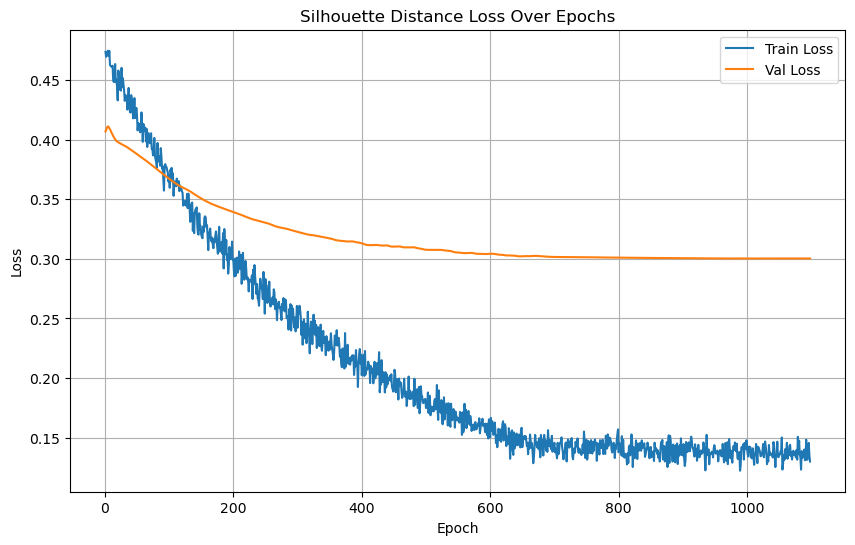

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2314], Loss: 0.1214


Test Batch [20/2314], Loss: 0.1943
Test Batch [30/2314], Loss: 0.5000
Test Batch [40/2314], Loss: 0.1370
Test Batch [50/2314], Loss: 0.5000
Test Batch [60/2314], Loss: 0.5000


Test Batch [70/2314], Loss: 0.5000
Test Batch [80/2314], Loss: 0.1906


Test Batch [90/2314], Loss: 0.5000
Test Batch [100/2314], Loss: 0.0451
Test Batch [110/2314], Loss: 0.5000
Test Batch [120/2314], Loss: 0.1388
Test Batch [130/2314], Loss: 0.5000


Test Batch [140/2314], Loss: 0.5000


Test Batch [150/2314], Loss: 0.5000
Test Batch [160/2314], Loss: 0.1495
Test Batch [170/2314], Loss: 0.5000
Test Batch [180/2314], Loss: 0.5000
Test Batch [190/2314], Loss: 0.5000
Test Batch [200/2314], Loss: 0.1640


Test Batch [210/2314], Loss: 0.5000
Test Batch [220/2314], Loss: 0.5000
Test Batch [230/2314], Loss: 0.1345
Test Batch [240/2314], Loss: 0.0518
Test Batch [250/2314], Loss: 0.1848
Test Batch [260/2314], Loss: 0.5000
Test Batch [270/2314], Loss: 0.5000


Test Batch [280/2314], Loss: 0.5000
Test Batch [290/2314], Loss: 0.1534
Test Batch [300/2314], Loss: 0.1295
Test Batch [310/2314], Loss: 0.5000
Test Batch [320/2314], Loss: 0.1032
Test Batch [330/2314], Loss: 0.5000
Test Batch [340/2314], Loss: 0.5000
Test Batch [350/2314], Loss: 0.2729


Test Batch [360/2314], Loss: 0.1410
Test Batch [370/2314], Loss: 0.2104
Test Batch [380/2314], Loss: 0.0986
Test Batch [390/2314], Loss: 0.5000
Test Batch [400/2314], Loss: 0.5000
Test Batch [410/2314], Loss: 0.0452
Test Batch [420/2314], Loss: 0.0751


Test Batch [430/2314], Loss: 0.1570
Test Batch [440/2314], Loss: 0.5000
Test Batch [450/2314], Loss: 0.0795
Test Batch [460/2314], Loss: 0.5000
Test Batch [470/2314], Loss: 0.1758


Test Batch [480/2314], Loss: 0.5000
Test Batch [490/2314], Loss: 0.1415
Test Batch [500/2314], Loss: 0.0490
Test Batch [510/2314], Loss: 0.1596
Test Batch [520/2314], Loss: 0.0740
Test Batch [530/2314], Loss: 0.5000


Test Batch [540/2314], Loss: 0.0586
Test Batch [550/2314], Loss: 0.0681
Test Batch [560/2314], Loss: 0.5000
Test Batch [570/2314], Loss: 0.5000
Test Batch [580/2314], Loss: 0.1314


Test Batch [590/2314], Loss: 0.0446
Test Batch [600/2314], Loss: 0.5000
Test Batch [610/2314], Loss: 0.5000
Test Batch [620/2314], Loss: 0.1790
Test Batch [630/2314], Loss: 0.0309


Test Batch [640/2314], Loss: 0.1609
Test Batch [650/2314], Loss: 0.0210
Test Batch [660/2314], Loss: 0.0151
Test Batch [670/2314], Loss: 0.1999
Test Batch [680/2314], Loss: 0.5000
Test Batch [690/2314], Loss: 0.0893


Test Batch [700/2314], Loss: 0.2112
Test Batch [710/2314], Loss: 0.5000
Test Batch [720/2314], Loss: 0.5000
Test Batch [730/2314], Loss: 0.5000
Test Batch [740/2314], Loss: 0.0445
Test Batch [750/2314], Loss: 0.1539


Test Batch [760/2314], Loss: 0.0533
Test Batch [770/2314], Loss: 0.5000
Test Batch [780/2314], Loss: 0.0766
Test Batch [790/2314], Loss: 0.1726
Test Batch [800/2314], Loss: 0.1182
Test Batch [810/2314], Loss: 0.5000


Test Batch [820/2314], Loss: 0.1329
Test Batch [830/2314], Loss: 0.1795
Test Batch [840/2314], Loss: 0.5000
Test Batch [850/2314], Loss: 0.2203
Test Batch [860/2314], Loss: 0.5000


Test Batch [870/2314], Loss: 0.1414
Test Batch [880/2314], Loss: 0.1269
Test Batch [890/2314], Loss: 0.5000
Test Batch [900/2314], Loss: 0.5000
Test Batch [910/2314], Loss: 0.0691
Test Batch [920/2314], Loss: 0.5000
Test Batch [930/2314], Loss: 0.1308


Test Batch [940/2314], Loss: 0.1420
Test Batch [950/2314], Loss: 0.0789
Test Batch [960/2314], Loss: 0.0453
Test Batch [970/2314], Loss: 0.5000
Test Batch [980/2314], Loss: 0.5000
Test Batch [990/2314], Loss: 0.1604
Test Batch [1000/2314], Loss: 0.5000


Test Batch [1010/2314], Loss: 0.1754
Test Batch [1020/2314], Loss: 0.0504
Test Batch [1030/2314], Loss: 0.5000
Test Batch [1040/2314], Loss: 0.1630
Test Batch [1050/2314], Loss: 0.0461
Test Batch [1060/2314], Loss: 0.5000


Test Batch [1070/2314], Loss: 0.5000
Test Batch [1080/2314], Loss: 0.5000
Test Batch [1090/2314], Loss: 0.0425
Test Batch [1100/2314], Loss: 0.1121
Test Batch [1110/2314], Loss: 0.1668


Test Batch [1120/2314], Loss: 0.0447
Test Batch [1130/2314], Loss: 0.2028
Test Batch [1140/2314], Loss: 0.1872
Test Batch [1150/2314], Loss: 0.0349
Test Batch [1160/2314], Loss: 0.0420


Test Batch [1170/2314], Loss: 0.0197
Test Batch [1180/2314], Loss: 0.1451
Test Batch [1190/2314], Loss: 0.2995
Test Batch [1200/2314], Loss: 0.0304
Test Batch [1210/2314], Loss: 0.0564


Test Batch [1220/2314], Loss: 0.1809
Test Batch [1230/2314], Loss: 0.5000
Test Batch [1240/2314], Loss: 0.1225
Test Batch [1250/2314], Loss: 0.0176
Test Batch [1260/2314], Loss: 0.2558


Test Batch [1270/2314], Loss: 0.0754
Test Batch [1280/2314], Loss: 0.5000
Test Batch [1290/2314], Loss: 0.1222


Test Batch [1300/2314], Loss: 0.5000
Test Batch [1310/2314], Loss: 0.2531
Test Batch [1320/2314], Loss: 0.2376


Test Batch [1330/2314], Loss: 0.1795
Test Batch [1340/2314], Loss: 0.0303
Test Batch [1350/2314], Loss: 0.1566
Test Batch [1360/2314], Loss: 0.1934


Test Batch [1370/2314], Loss: 0.2073
Test Batch [1380/2314], Loss: 0.1699
Test Batch [1390/2314], Loss: 0.1962


Test Batch [1400/2314], Loss: 0.2103
Test Batch [1410/2314], Loss: 0.2087
Test Batch [1420/2314], Loss: 0.2434


Test Batch [1430/2314], Loss: 0.0134
Test Batch [1440/2314], Loss: 0.1736
Test Batch [1450/2314], Loss: 0.2116
Test Batch [1460/2314], Loss: 0.2229


Test Batch [1470/2314], Loss: 0.2083
Test Batch [1480/2314], Loss: 0.1829
Test Batch [1490/2314], Loss: 0.2411
Test Batch [1500/2314], Loss: 0.1671


Test Batch [1510/2314], Loss: 0.5000
Test Batch [1520/2314], Loss: 0.5000
Test Batch [1530/2314], Loss: 0.1917
Test Batch [1540/2314], Loss: 0.2176


Test Batch [1550/2314], Loss: 0.2062
Test Batch [1560/2314], Loss: 0.2684
Test Batch [1570/2314], Loss: 0.1868
Test Batch [1580/2314], Loss: 0.1542


Test Batch [1590/2314], Loss: 0.2645
Test Batch [1600/2314], Loss: 0.1560
Test Batch [1610/2314], Loss: 0.1644
Test Batch [1620/2314], Loss: 0.5000


Test Batch [1630/2314], Loss: 0.2205
Test Batch [1640/2314], Loss: 0.2453
Test Batch [1650/2314], Loss: 0.0818
Test Batch [1660/2314], Loss: 0.2112


Test Batch [1670/2314], Loss: 0.2132
Test Batch [1680/2314], Loss: 0.2455
Test Batch [1690/2314], Loss: 0.2333
Test Batch [1700/2314], Loss: 0.2113


Test Batch [1710/2314], Loss: 0.1763
Test Batch [1720/2314], Loss: 0.1244
Test Batch [1730/2314], Loss: 0.1586
Test Batch [1740/2314], Loss: 0.5000
Test Batch [1750/2314], Loss: 0.0717
Test Batch [1760/2314], Loss: 0.1593
Test Batch [1770/2314], Loss: 0.1386


Test Batch [1780/2314], Loss: 0.1517
Test Batch [1790/2314], Loss: 0.1387
Test Batch [1800/2314], Loss: 0.1538
Test Batch [1810/2314], Loss: 0.1874
Test Batch [1820/2314], Loss: 0.1973
Test Batch [1830/2314], Loss: 0.0237


Test Batch [1840/2314], Loss: 0.2341
Test Batch [1850/2314], Loss: 0.1215
Test Batch [1860/2314], Loss: 0.1988
Test Batch [1870/2314], Loss: 0.2140
Test Batch [1880/2314], Loss: 0.1772


Test Batch [1890/2314], Loss: 0.1608
Test Batch [1900/2314], Loss: 0.2279
Test Batch [1910/2314], Loss: 0.2066
Test Batch [1920/2314], Loss: 0.2331


Test Batch [1930/2314], Loss: 0.1455
Test Batch [1940/2314], Loss: 0.1903
Test Batch [1950/2314], Loss: 0.5000
Test Batch [1960/2314], Loss: 0.2114
Test Batch [1970/2314], Loss: 0.1937
Test Batch [1980/2314], Loss: 0.1968


Test Batch [1990/2314], Loss: 0.1316
Test Batch [2000/2314], Loss: 0.1733
Test Batch [2010/2314], Loss: 0.1325
Test Batch [2020/2314], Loss: 0.1393
Test Batch [2030/2314], Loss: 0.1249
Test Batch [2040/2314], Loss: 0.1591


Test Batch [2050/2314], Loss: 0.2143
Test Batch [2060/2314], Loss: 0.1769
Test Batch [2070/2314], Loss: 0.1446
Test Batch [2080/2314], Loss: 0.5000
Test Batch [2090/2314], Loss: 0.5000
Test Batch [2100/2314], Loss: 0.5000


Test Batch [2110/2314], Loss: 0.2020
Test Batch [2120/2314], Loss: 0.1960
Test Batch [2130/2314], Loss: 0.0941
Test Batch [2140/2314], Loss: 0.1227
Test Batch [2150/2314], Loss: 0.5000


Test Batch [2160/2314], Loss: 0.5000
Test Batch [2170/2314], Loss: 0.0106
Test Batch [2180/2314], Loss: 0.1972
Test Batch [2190/2314], Loss: 0.0477
Test Batch [2200/2314], Loss: 0.2286
Test Batch [2210/2314], Loss: 0.0357


Test Batch [2220/2314], Loss: 0.5000
Test Batch [2230/2314], Loss: 0.0311
Test Batch [2240/2314], Loss: 0.5000
Test Batch [2250/2314], Loss: 0.5000
Test Batch [2260/2314], Loss: 0.5000
Test Batch [2270/2314], Loss: 0.3069
Test Batch [2280/2314], Loss: 0.1617


Test Batch [2290/2314], Loss: 0.5000
Test Batch [2300/2314], Loss: 0.5000
Test Batch [2310/2314], Loss: 0.1221

Test Loss: 0.2504


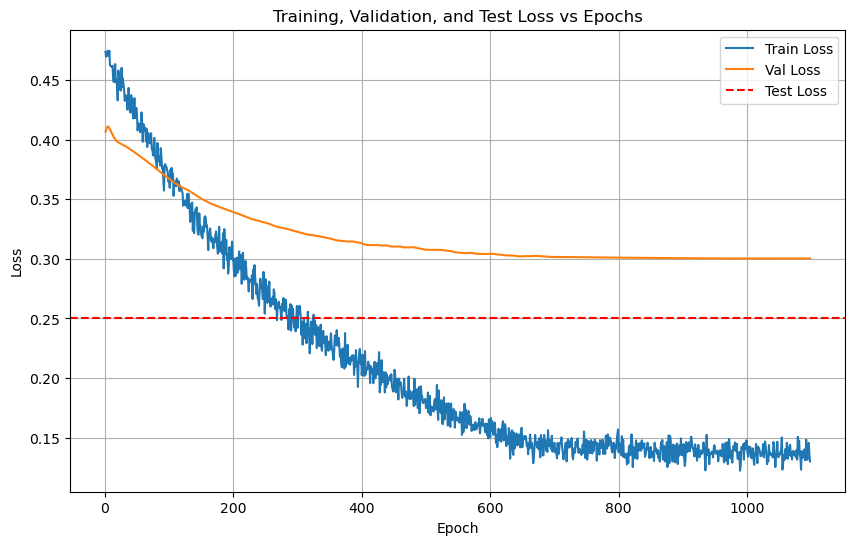

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/2314 for test dataset.
  Processed batch 20/2314 for test dataset.
  Processed batch 30/2314 for test dataset.


  Processed batch 40/2314 for test dataset.


  Processed batch 50/2314 for test dataset.
  Processed batch 60/2314 for test dataset.
  Processed batch 70/2314 for test dataset.


  Processed batch 80/2314 for test dataset.


  Processed batch 90/2314 for test dataset.
  Processed batch 100/2314 for test dataset.
  Processed batch 110/2314 for test dataset.


  Processed batch 120/2314 for test dataset.


  Processed batch 130/2314 for test dataset.
  Processed batch 140/2314 for test dataset.
  Processed batch 150/2314 for test dataset.


  Processed batch 160/2314 for test dataset.
  Processed batch 170/2314 for test dataset.
  Processed batch 180/2314 for test dataset.
  Processed batch 190/2314 for test dataset.


  Processed batch 200/2314 for test dataset.
  Processed batch 210/2314 for test dataset.
  Processed batch 220/2314 for test dataset.
  Processed batch 230/2314 for test dataset.


  Processed batch 240/2314 for test dataset.
  Processed batch 250/2314 for test dataset.
  Processed batch 260/2314 for test dataset.
  Processed batch 270/2314 for test dataset.


  Processed batch 280/2314 for test dataset.
  Processed batch 290/2314 for test dataset.
  Processed batch 300/2314 for test dataset.
  Processed batch 310/2314 for test dataset.


  Processed batch 320/2314 for test dataset.
  Processed batch 330/2314 for test dataset.
  Processed batch 340/2314 for test dataset.
  Processed batch 350/2314 for test dataset.


  Processed batch 360/2314 for test dataset.
  Processed batch 370/2314 for test dataset.
  Processed batch 380/2314 for test dataset.
  Processed batch 390/2314 for test dataset.


  Processed batch 400/2314 for test dataset.
  Processed batch 410/2314 for test dataset.
  Processed batch 420/2314 for test dataset.
  Processed batch 430/2314 for test dataset.


  Processed batch 440/2314 for test dataset.
  Processed batch 450/2314 for test dataset.
  Processed batch 460/2314 for test dataset.


  Processed batch 470/2314 for test dataset.
  Processed batch 480/2314 for test dataset.
  Processed batch 490/2314 for test dataset.
  Processed batch 500/2314 for test dataset.


  Processed batch 510/2314 for test dataset.
  Processed batch 520/2314 for test dataset.
  Processed batch 530/2314 for test dataset.
  Processed batch 540/2314 for test dataset.


  Processed batch 550/2314 for test dataset.
  Processed batch 560/2314 for test dataset.
  Processed batch 570/2314 for test dataset.
  Processed batch 580/2314 for test dataset.


  Processed batch 590/2314 for test dataset.
  Processed batch 600/2314 for test dataset.
  Processed batch 610/2314 for test dataset.
  Processed batch 620/2314 for test dataset.


  Processed batch 630/2314 for test dataset.
  Processed batch 640/2314 for test dataset.
  Processed batch 650/2314 for test dataset.
  Processed batch 660/2314 for test dataset.


  Processed batch 670/2314 for test dataset.
  Processed batch 680/2314 for test dataset.
  Processed batch 690/2314 for test dataset.
  Processed batch 700/2314 for test dataset.


  Processed batch 710/2314 for test dataset.
  Processed batch 720/2314 for test dataset.
  Processed batch 730/2314 for test dataset.
  Processed batch 740/2314 for test dataset.


  Processed batch 750/2314 for test dataset.
  Processed batch 760/2314 for test dataset.
  Processed batch 770/2314 for test dataset.


  Processed batch 780/2314 for test dataset.
  Processed batch 790/2314 for test dataset.
  Processed batch 800/2314 for test dataset.
  Processed batch 810/2314 for test dataset.


  Processed batch 820/2314 for test dataset.
  Processed batch 830/2314 for test dataset.
  Processed batch 840/2314 for test dataset.
  Processed batch 850/2314 for test dataset.


  Processed batch 860/2314 for test dataset.
  Processed batch 870/2314 for test dataset.
  Processed batch 880/2314 for test dataset.
  Processed batch 890/2314 for test dataset.


  Processed batch 900/2314 for test dataset.
  Processed batch 910/2314 for test dataset.
  Processed batch 920/2314 for test dataset.
  Processed batch 930/2314 for test dataset.


  Processed batch 940/2314 for test dataset.
  Processed batch 950/2314 for test dataset.
  Processed batch 960/2314 for test dataset.
  Processed batch 970/2314 for test dataset.


  Processed batch 980/2314 for test dataset.
  Processed batch 990/2314 for test dataset.
  Processed batch 1000/2314 for test dataset.


  Processed batch 1010/2314 for test dataset.
  Processed batch 1020/2314 for test dataset.
  Processed batch 1030/2314 for test dataset.
  Processed batch 1040/2314 for test dataset.


  Processed batch 1050/2314 for test dataset.
  Processed batch 1060/2314 for test dataset.
  Processed batch 1070/2314 for test dataset.
  Processed batch 1080/2314 for test dataset.


  Processed batch 1090/2314 for test dataset.
  Processed batch 1100/2314 for test dataset.
  Processed batch 1110/2314 for test dataset.
  Processed batch 1120/2314 for test dataset.


  Processed batch 1130/2314 for test dataset.
  Processed batch 1140/2314 for test dataset.
  Processed batch 1150/2314 for test dataset.
  Processed batch 1160/2314 for test dataset.


  Processed batch 1170/2314 for test dataset.
  Processed batch 1180/2314 for test dataset.
  Processed batch 1190/2314 for test dataset.
  Processed batch 1200/2314 for test dataset.


  Processed batch 1210/2314 for test dataset.
  Processed batch 1220/2314 for test dataset.
  Processed batch 1230/2314 for test dataset.
  Processed batch 1240/2314 for test dataset.


  Processed batch 1250/2314 for test dataset.
  Processed batch 1260/2314 for test dataset.
  Processed batch 1270/2314 for test dataset.
  Processed batch 1280/2314 for test dataset.


  Processed batch 1290/2314 for test dataset.
  Processed batch 1300/2314 for test dataset.
  Processed batch 1310/2314 for test dataset.
  Processed batch 1320/2314 for test dataset.


  Processed batch 1330/2314 for test dataset.
  Processed batch 1340/2314 for test dataset.
  Processed batch 1350/2314 for test dataset.
  Processed batch 1360/2314 for test dataset.


  Processed batch 1370/2314 for test dataset.
  Processed batch 1380/2314 for test dataset.
  Processed batch 1390/2314 for test dataset.
  Processed batch 1400/2314 for test dataset.


  Processed batch 1410/2314 for test dataset.
  Processed batch 1420/2314 for test dataset.
  Processed batch 1430/2314 for test dataset.
  Processed batch 1440/2314 for test dataset.


  Processed batch 1450/2314 for test dataset.
  Processed batch 1460/2314 for test dataset.
  Processed batch 1470/2314 for test dataset.
  Processed batch 1480/2314 for test dataset.


  Processed batch 1490/2314 for test dataset.
  Processed batch 1500/2314 for test dataset.
  Processed batch 1510/2314 for test dataset.
  Processed batch 1520/2314 for test dataset.


  Processed batch 1530/2314 for test dataset.
  Processed batch 1540/2314 for test dataset.
  Processed batch 1550/2314 for test dataset.


  Processed batch 1560/2314 for test dataset.
  Processed batch 1570/2314 for test dataset.
  Processed batch 1580/2314 for test dataset.
  Processed batch 1590/2314 for test dataset.


  Processed batch 1600/2314 for test dataset.
  Processed batch 1610/2314 for test dataset.
  Processed batch 1620/2314 for test dataset.
  Processed batch 1630/2314 for test dataset.


  Processed batch 1640/2314 for test dataset.
  Processed batch 1650/2314 for test dataset.
  Processed batch 1660/2314 for test dataset.
  Processed batch 1670/2314 for test dataset.


  Processed batch 1680/2314 for test dataset.
  Processed batch 1690/2314 for test dataset.
  Processed batch 1700/2314 for test dataset.
  Processed batch 1710/2314 for test dataset.


  Processed batch 1720/2314 for test dataset.
  Processed batch 1730/2314 for test dataset.
  Processed batch 1740/2314 for test dataset.
  Processed batch 1750/2314 for test dataset.


  Processed batch 1760/2314 for test dataset.
  Processed batch 1770/2314 for test dataset.
  Processed batch 1780/2314 for test dataset.


  Processed batch 1790/2314 for test dataset.
  Processed batch 1800/2314 for test dataset.
  Processed batch 1810/2314 for test dataset.
  Processed batch 1820/2314 for test dataset.


  Processed batch 1830/2314 for test dataset.
  Processed batch 1840/2314 for test dataset.
  Processed batch 1850/2314 for test dataset.
  Processed batch 1860/2314 for test dataset.


  Processed batch 1870/2314 for test dataset.
  Processed batch 1880/2314 for test dataset.
  Processed batch 1890/2314 for test dataset.


  Processed batch 1900/2314 for test dataset.
  Processed batch 1910/2314 for test dataset.
  Processed batch 1920/2314 for test dataset.
  Processed batch 1930/2314 for test dataset.


  Processed batch 1940/2314 for test dataset.
  Processed batch 1950/2314 for test dataset.
  Processed batch 1960/2314 for test dataset.
  Processed batch 1970/2314 for test dataset.


  Processed batch 1980/2314 for test dataset.
  Processed batch 1990/2314 for test dataset.
  Processed batch 2000/2314 for test dataset.
  Processed batch 2010/2314 for test dataset.


  Processed batch 2020/2314 for test dataset.
  Processed batch 2030/2314 for test dataset.
  Processed batch 2040/2314 for test dataset.
  Processed batch 2050/2314 for test dataset.


  Processed batch 2060/2314 for test dataset.
  Processed batch 2070/2314 for test dataset.
  Processed batch 2080/2314 for test dataset.
  Processed batch 2090/2314 for test dataset.


  Processed batch 2100/2314 for test dataset.
  Processed batch 2110/2314 for test dataset.
  Processed batch 2120/2314 for test dataset.
  Processed batch 2130/2314 for test dataset.


  Processed batch 2140/2314 for test dataset.
  Processed batch 2150/2314 for test dataset.
  Processed batch 2160/2314 for test dataset.
  Processed batch 2170/2314 for test dataset.


  Processed batch 2180/2314 for test dataset.
  Processed batch 2190/2314 for test dataset.
  Processed batch 2200/2314 for test dataset.
  Processed batch 2210/2314 for test dataset.


  Processed batch 2220/2314 for test dataset.
  Processed batch 2230/2314 for test dataset.
  Processed batch 2240/2314 for test dataset.
  Processed batch 2250/2314 for test dataset.


  Processed batch 2260/2314 for test dataset.
  Processed batch 2270/2314 for test dataset.
  Processed batch 2280/2314 for test dataset.
  Processed batch 2290/2314 for test dataset.


  Processed batch 2300/2314 for test dataset.
  Processed batch 2310/2314 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.40      0.57         5
           3       0.67      0.80      0.73         5
           4       0.67      0.80      0.73         5
           5       1.00      1.00      1.00         5
           6       0.80      0.80      0.80         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.89      0.87      0.86        45
weighted avg       0.89      0.87      0.86        45


LOG: Evaluating on the test set...
Test Accuracy: 93.57%

Test Classifica

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3610  |  Val Loss: 2.3576
Validation loss improved from inf to 2.3576.
[Epoch 2/1000] Train Loss: 2.3429  |  Val Loss: 2.3435
Validation loss improved from 2.3576 to 2.3435.
[Epoch 3/1000] Train Loss: 2.3250  |  Val Loss: 2.3299
Validation loss improved from 2.3435 to 2.3299.
[Epoch 4/1000] Train Loss: 2.3073  |  Val Loss: 2.3168
Validation loss improved from 2.3299 to 2.3168.
[Epoch 5/1000] Train Loss: 2.2904  |  Val Loss: 2.3042
Validation loss improved from 2.3168 to 2.3042.
[Epoch 6/1000] Train Loss: 2.2742  |  Val Loss: 2.2917
Validation loss improved from 2.3042 to 2.2917.
[Epoch 7/1000] Train Loss: 2.2581  |  Val Loss: 2.2793
Validation loss improved from 2.2917 to 2.2793.
[Epoch 8/1000] Train Loss: 2.2422  |  Val Loss: 2.2671
Validation loss improved from 2.2793 to 2.2671.
[Epoch 9/1000] Train Loss: 2.2265  |  Val Loss: 2.2550
Validation loss improved from 2.2671 to 2.2550.
[Epoch 10/1000] Train Loss: 2.2108  |  Val Loss: 2.2432
Validation loss impr

[Epoch 57/1000] Train Loss: 1.5731  |  Val Loss: 1.7445
Validation loss improved from 1.7544 to 1.7445.
[Epoch 58/1000] Train Loss: 1.5603  |  Val Loss: 1.7346
Validation loss improved from 1.7445 to 1.7346.
[Epoch 59/1000] Train Loss: 1.5476  |  Val Loss: 1.7247
Validation loss improved from 1.7346 to 1.7247.
[Epoch 60/1000] Train Loss: 1.5350  |  Val Loss: 1.7149
Validation loss improved from 1.7247 to 1.7149.
[Epoch 61/1000] Train Loss: 1.5225  |  Val Loss: 1.7052
Validation loss improved from 1.7149 to 1.7052.
[Epoch 62/1000] Train Loss: 1.5100  |  Val Loss: 1.6956
Validation loss improved from 1.7052 to 1.6956.
[Epoch 63/1000] Train Loss: 1.4976  |  Val Loss: 1.6861
Validation loss improved from 1.6956 to 1.6861.
[Epoch 64/1000] Train Loss: 1.4852  |  Val Loss: 1.6766
Validation loss improved from 1.6861 to 1.6766.
[Epoch 65/1000] Train Loss: 1.4729  |  Val Loss: 1.6672
Validation loss improved from 1.6766 to 1.6672.
[Epoch 66/1000] Train Loss: 1.4607  |  Val Loss: 1.6577
Validati

[Epoch 71/1000] Train Loss: 1.4005  |  Val Loss: 1.6108
Validation loss improved from 1.6200 to 1.6108.
[Epoch 72/1000] Train Loss: 1.3886  |  Val Loss: 1.6018
Validation loss improved from 1.6108 to 1.6018.
[Epoch 73/1000] Train Loss: 1.3768  |  Val Loss: 1.5927
Validation loss improved from 1.6018 to 1.5927.
[Epoch 74/1000] Train Loss: 1.3650  |  Val Loss: 1.5837
Validation loss improved from 1.5927 to 1.5837.
[Epoch 75/1000] Train Loss: 1.3533  |  Val Loss: 1.5748
Validation loss improved from 1.5837 to 1.5748.
[Epoch 76/1000] Train Loss: 1.3416  |  Val Loss: 1.5660
Validation loss improved from 1.5748 to 1.5660.
[Epoch 77/1000] Train Loss: 1.3300  |  Val Loss: 1.5571
Validation loss improved from 1.5660 to 1.5571.
[Epoch 78/1000] Train Loss: 1.3184  |  Val Loss: 1.5484
Validation loss improved from 1.5571 to 1.5484.
[Epoch 79/1000] Train Loss: 1.3069  |  Val Loss: 1.5396
Validation loss improved from 1.5484 to 1.5396.
[Epoch 80/1000] Train Loss: 1.2955  |  Val Loss: 1.5308
Validati

[Epoch 127/1000] Train Loss: 0.8458  |  Val Loss: 1.1913
Validation loss improved from 1.1971 to 1.1913.
[Epoch 128/1000] Train Loss: 0.8380  |  Val Loss: 1.1856
Validation loss improved from 1.1913 to 1.1856.
[Epoch 129/1000] Train Loss: 0.8302  |  Val Loss: 1.1799
Validation loss improved from 1.1856 to 1.1799.
[Epoch 130/1000] Train Loss: 0.8226  |  Val Loss: 1.1743
Validation loss improved from 1.1799 to 1.1743.
[Epoch 131/1000] Train Loss: 0.8149  |  Val Loss: 1.1687
Validation loss improved from 1.1743 to 1.1687.
[Epoch 132/1000] Train Loss: 0.8073  |  Val Loss: 1.1631
Validation loss improved from 1.1687 to 1.1631.
[Epoch 133/1000] Train Loss: 0.7998  |  Val Loss: 1.1576
Validation loss improved from 1.1631 to 1.1576.
[Epoch 134/1000] Train Loss: 0.7923  |  Val Loss: 1.1521
Validation loss improved from 1.1576 to 1.1521.
[Epoch 135/1000] Train Loss: 0.7848  |  Val Loss: 1.1467
Validation loss improved from 1.1521 to 1.1467.
[Epoch 136/1000] Train Loss: 0.7774  |  Val Loss: 1.141

[Epoch 142/1000] Train Loss: 0.7343  |  Val Loss: 1.1105
Validation loss improved from 1.1155 to 1.1105.
[Epoch 143/1000] Train Loss: 0.7274  |  Val Loss: 1.1056
Validation loss improved from 1.1105 to 1.1056.
[Epoch 144/1000] Train Loss: 0.7205  |  Val Loss: 1.1007
Validation loss improved from 1.1056 to 1.1007.
[Epoch 145/1000] Train Loss: 0.7136  |  Val Loss: 1.0958
Validation loss improved from 1.1007 to 1.0958.
[Epoch 146/1000] Train Loss: 0.7068  |  Val Loss: 1.0910
Validation loss improved from 1.0958 to 1.0910.
[Epoch 147/1000] Train Loss: 0.7000  |  Val Loss: 1.0862
Validation loss improved from 1.0910 to 1.0862.
[Epoch 148/1000] Train Loss: 0.6933  |  Val Loss: 1.0815
Validation loss improved from 1.0862 to 1.0815.
[Epoch 149/1000] Train Loss: 0.6866  |  Val Loss: 1.0768
Validation loss improved from 1.0815 to 1.0768.
[Epoch 150/1000] Train Loss: 0.6800  |  Val Loss: 1.0721
Validation loss improved from 1.0768 to 1.0721.
[Epoch 151/1000] Train Loss: 0.6734  |  Val Loss: 1.067

[Epoch 197/1000] Train Loss: 0.4109  |  Val Loss: 0.8772
Validation loss improved from 0.8808 to 0.8772.
[Epoch 198/1000] Train Loss: 0.4062  |  Val Loss: 0.8737
Validation loss improved from 0.8772 to 0.8737.
[Epoch 199/1000] Train Loss: 0.4015  |  Val Loss: 0.8701
Validation loss improved from 0.8737 to 0.8701.
[Epoch 200/1000] Train Loss: 0.3970  |  Val Loss: 0.8667
Validation loss improved from 0.8701 to 0.8667.
[Epoch 201/1000] Train Loss: 0.3924  |  Val Loss: 0.8632
Validation loss improved from 0.8667 to 0.8632.
[Epoch 202/1000] Train Loss: 0.3879  |  Val Loss: 0.8597
Validation loss improved from 0.8632 to 0.8597.
[Epoch 203/1000] Train Loss: 0.3835  |  Val Loss: 0.8563
Validation loss improved from 0.8597 to 0.8563.
[Epoch 204/1000] Train Loss: 0.3791  |  Val Loss: 0.8529
Validation loss improved from 0.8563 to 0.8529.
[Epoch 205/1000] Train Loss: 0.3748  |  Val Loss: 0.8496
Validation loss improved from 0.8529 to 0.8496.
[Epoch 206/1000] Train Loss: 0.3704  |  Val Loss: 0.846

[Epoch 213/1000] Train Loss: 0.3416  |  Val Loss: 0.8240
Validation loss improved from 0.8271 to 0.8240.
[Epoch 214/1000] Train Loss: 0.3377  |  Val Loss: 0.8210
Validation loss improved from 0.8240 to 0.8210.
[Epoch 215/1000] Train Loss: 0.3338  |  Val Loss: 0.8181
Validation loss improved from 0.8210 to 0.8181.
[Epoch 216/1000] Train Loss: 0.3299  |  Val Loss: 0.8151
Validation loss improved from 0.8181 to 0.8151.
[Epoch 217/1000] Train Loss: 0.3261  |  Val Loss: 0.8122
Validation loss improved from 0.8151 to 0.8122.
[Epoch 218/1000] Train Loss: 0.3223  |  Val Loss: 0.8093
Validation loss improved from 0.8122 to 0.8093.
[Epoch 219/1000] Train Loss: 0.3186  |  Val Loss: 0.8065
Validation loss improved from 0.8093 to 0.8065.
[Epoch 220/1000] Train Loss: 0.3150  |  Val Loss: 0.8036
Validation loss improved from 0.8065 to 0.8036.
[Epoch 221/1000] Train Loss: 0.3113  |  Val Loss: 0.8008
Validation loss improved from 0.8036 to 0.8008.
[Epoch 222/1000] Train Loss: 0.3078  |  Val Loss: 0.798

[Epoch 275/1000] Train Loss: 0.1714  |  Val Loss: 0.6949
Validation loss improved from 0.6963 to 0.6949.
[Epoch 276/1000] Train Loss: 0.1697  |  Val Loss: 0.6936
Validation loss improved from 0.6949 to 0.6936.
[Epoch 277/1000] Train Loss: 0.1679  |  Val Loss: 0.6923
Validation loss improved from 0.6936 to 0.6923.
[Epoch 278/1000] Train Loss: 0.1662  |  Val Loss: 0.6910
Validation loss improved from 0.6923 to 0.6910.
[Epoch 279/1000] Train Loss: 0.1644  |  Val Loss: 0.6897
Validation loss improved from 0.6910 to 0.6897.
[Epoch 280/1000] Train Loss: 0.1627  |  Val Loss: 0.6884
Validation loss improved from 0.6897 to 0.6884.
[Epoch 281/1000] Train Loss: 0.1611  |  Val Loss: 0.6872
Validation loss improved from 0.6884 to 0.6872.
[Epoch 282/1000] Train Loss: 0.1594  |  Val Loss: 0.6859
Validation loss improved from 0.6872 to 0.6859.
[Epoch 283/1000] Train Loss: 0.1578  |  Val Loss: 0.6847
Validation loss improved from 0.6859 to 0.6847.
[Epoch 284/1000] Train Loss: 0.1562  |  Val Loss: 0.683

[Epoch 346/1000] Train Loss: 0.0878  |  Val Loss: 0.6317
Validation loss improved from 0.6322 to 0.6317.
[Epoch 347/1000] Train Loss: 0.0870  |  Val Loss: 0.6312
Validation loss improved from 0.6317 to 0.6312.
[Epoch 348/1000] Train Loss: 0.0863  |  Val Loss: 0.6308
Validation loss improved from 0.6312 to 0.6308.
[Epoch 349/1000] Train Loss: 0.0856  |  Val Loss: 0.6303
Validation loss improved from 0.6308 to 0.6303.
[Epoch 350/1000] Train Loss: 0.0849  |  Val Loss: 0.6299
Validation loss improved from 0.6303 to 0.6299.
[Epoch 351/1000] Train Loss: 0.0842  |  Val Loss: 0.6295
Validation loss improved from 0.6299 to 0.6295.
[Epoch 352/1000] Train Loss: 0.0835  |  Val Loss: 0.6290
Validation loss improved from 0.6295 to 0.6290.
[Epoch 353/1000] Train Loss: 0.0828  |  Val Loss: 0.6286
Validation loss improved from 0.6290 to 0.6286.
[Epoch 354/1000] Train Loss: 0.0821  |  Val Loss: 0.6282
Validation loss improved from 0.6286 to 0.6282.
[Epoch 355/1000] Train Loss: 0.0815  |  Val Loss: 0.627

[Epoch 421/1000] Train Loss: 0.0500  |  Val Loss: 0.6130
Validation loss improved from 0.6131 to 0.6130.
[Epoch 422/1000] Train Loss: 0.0497  |  Val Loss: 0.6129
Validation loss improved from 0.6130 to 0.6129.
[Epoch 423/1000] Train Loss: 0.0494  |  Val Loss: 0.6129
Validation loss improved from 0.6129 to 0.6129.
[Epoch 424/1000] Train Loss: 0.0490  |  Val Loss: 0.6128
Validation loss improved from 0.6129 to 0.6128.
[Epoch 425/1000] Train Loss: 0.0487  |  Val Loss: 0.6127
Validation loss improved from 0.6128 to 0.6127.
[Epoch 426/1000] Train Loss: 0.0484  |  Val Loss: 0.6127
Validation loss improved from 0.6127 to 0.6127.
[Epoch 427/1000] Train Loss: 0.0481  |  Val Loss: 0.6126
Validation loss improved from 0.6127 to 0.6126.
[Epoch 428/1000] Train Loss: 0.0478  |  Val Loss: 0.6125
Validation loss improved from 0.6126 to 0.6125.
[Epoch 429/1000] Train Loss: 0.0475  |  Val Loss: 0.6125
Validation loss improved from 0.6125 to 0.6125.
[Epoch 430/1000] Train Loss: 0.0472  |  Val Loss: 0.612

[Epoch 494/1000] Train Loss: 0.0323  |  Val Loss: 0.6138
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 495/1000] Train Loss: 0.0321  |  Val Loss: 0.6139
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 496/1000] Train Loss: 0.0319  |  Val Loss: 0.6140
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 497/1000] Train Loss: 0.0317  |  Val Loss: 0.6141
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 498/1000] Train Loss: 0.0316  |  Val Loss: 0.6142
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 499/1000] Train Loss: 0.0314  |  Val Loss: 0.6143
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 500/1000] Train Loss: 0.0312  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 501/1000] Train Loss: 0.0310  |  Val Loss: 0.6146
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 502/1000] Train Loss: 0.0309  |  Val Loss: 0.6147
!! Validation loss did NOT improve !! Patience:

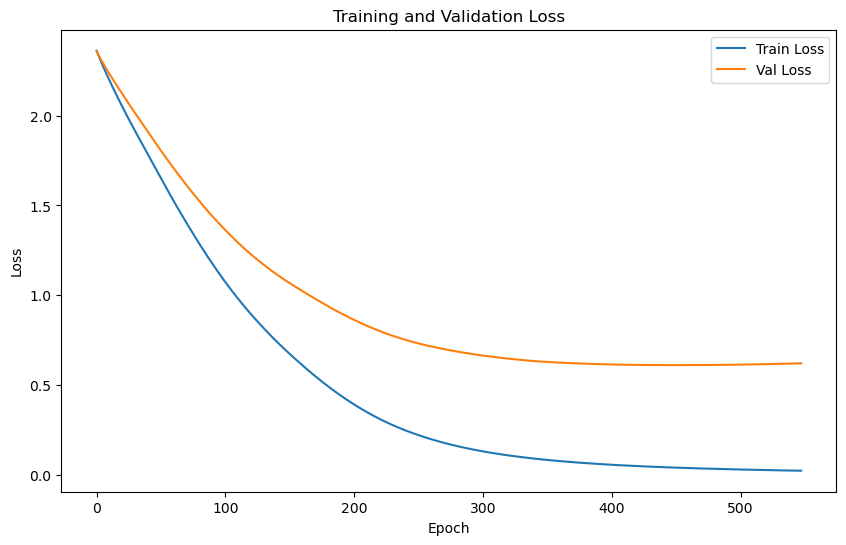

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2492 | Test Accuracy: 93.64%


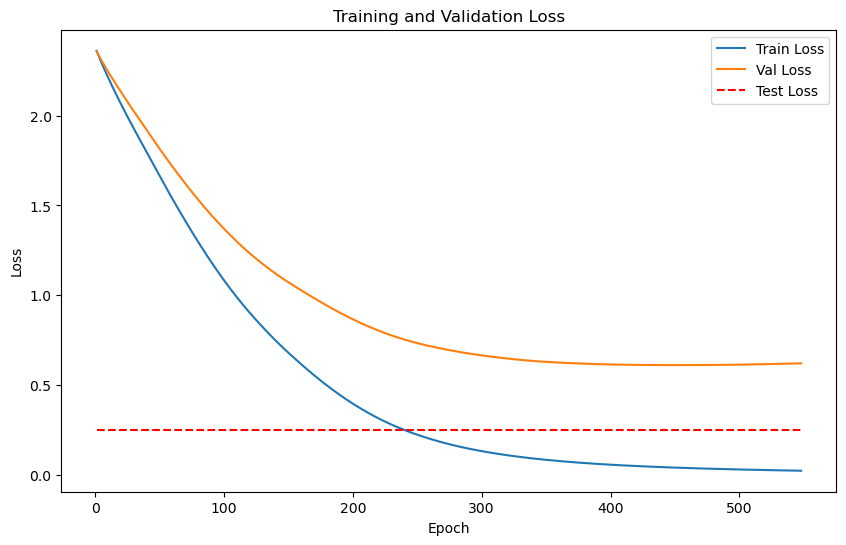

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


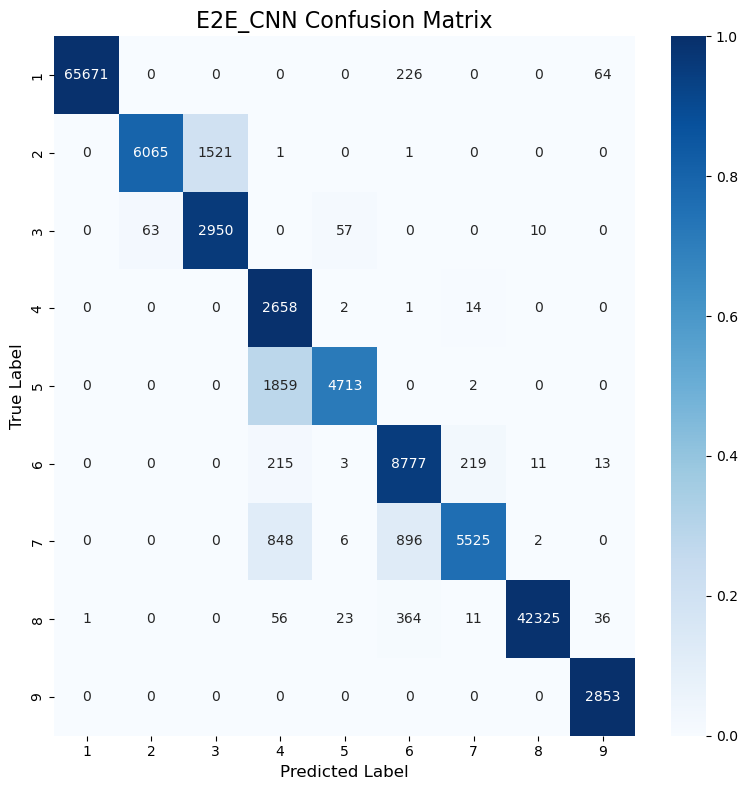

Classification Accuracy: 95.59%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


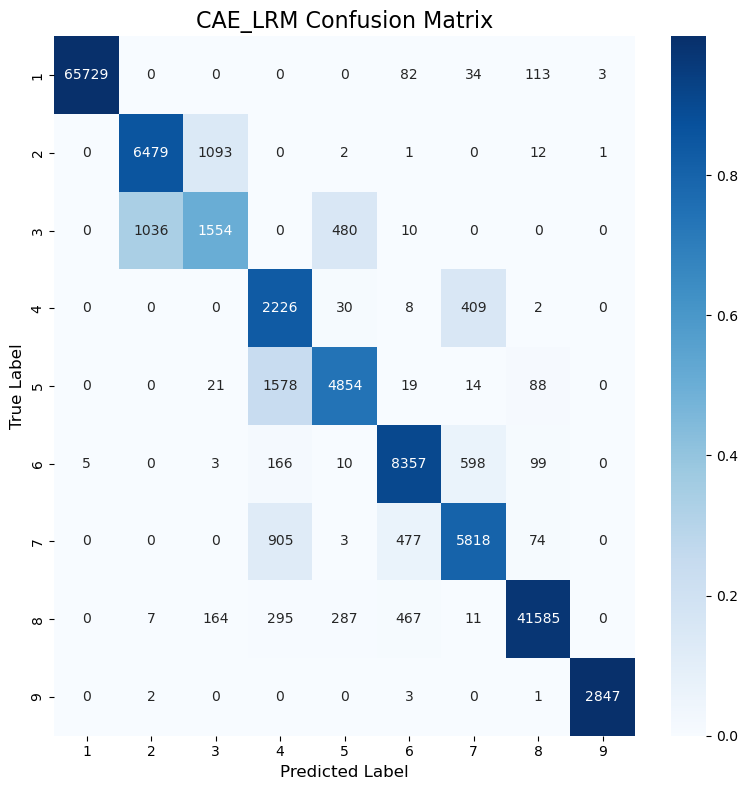

Classification Accuracy: 94.18%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


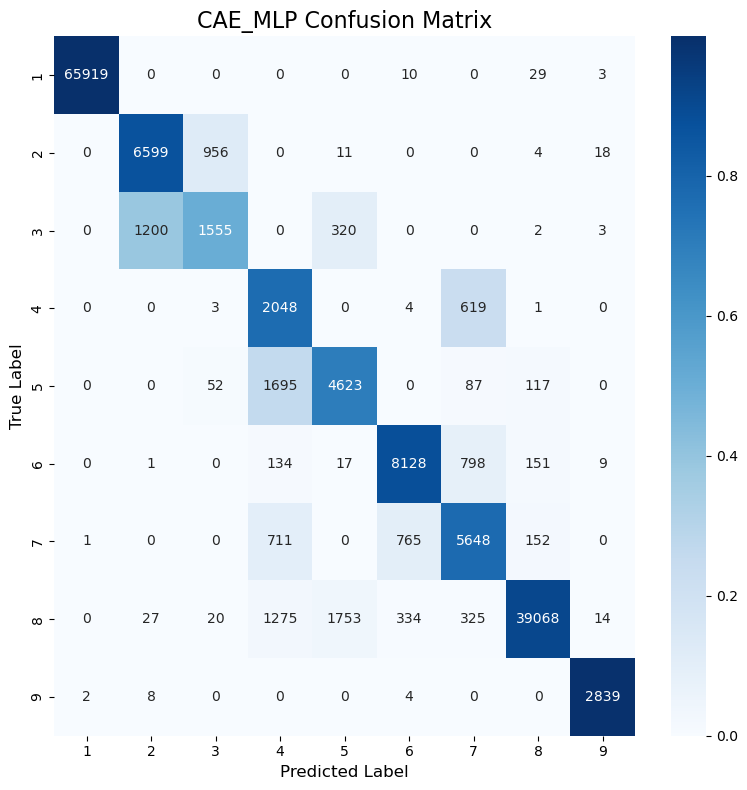

Classification Accuracy: 92.14%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


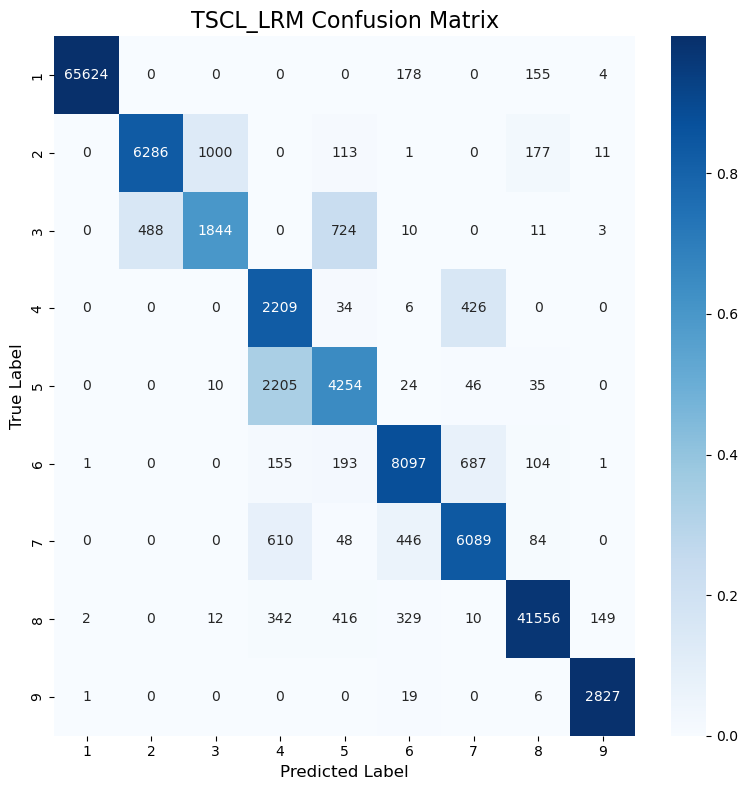

Classification Accuracy: 93.74%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


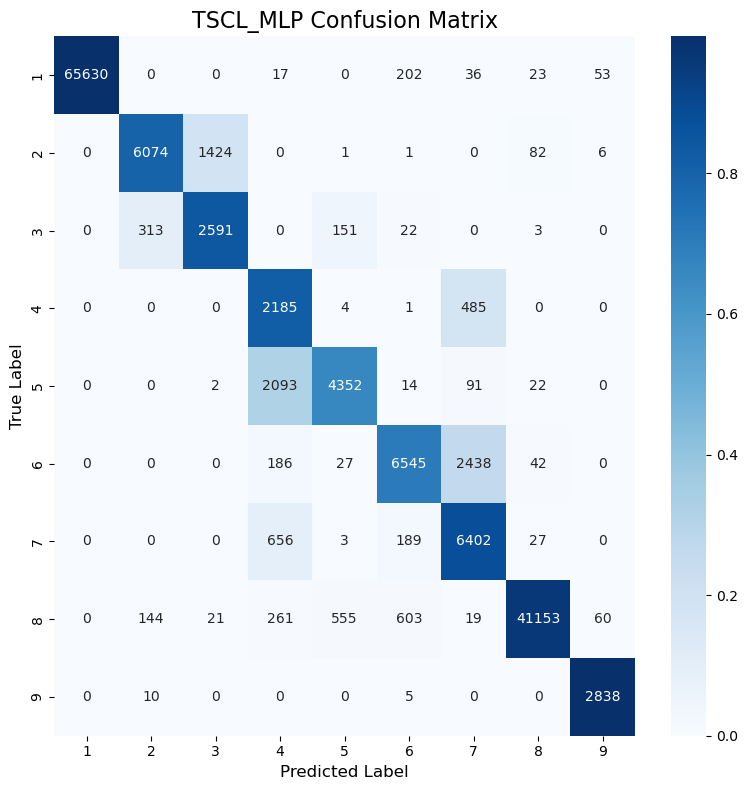

Classification Accuracy: 93.05%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


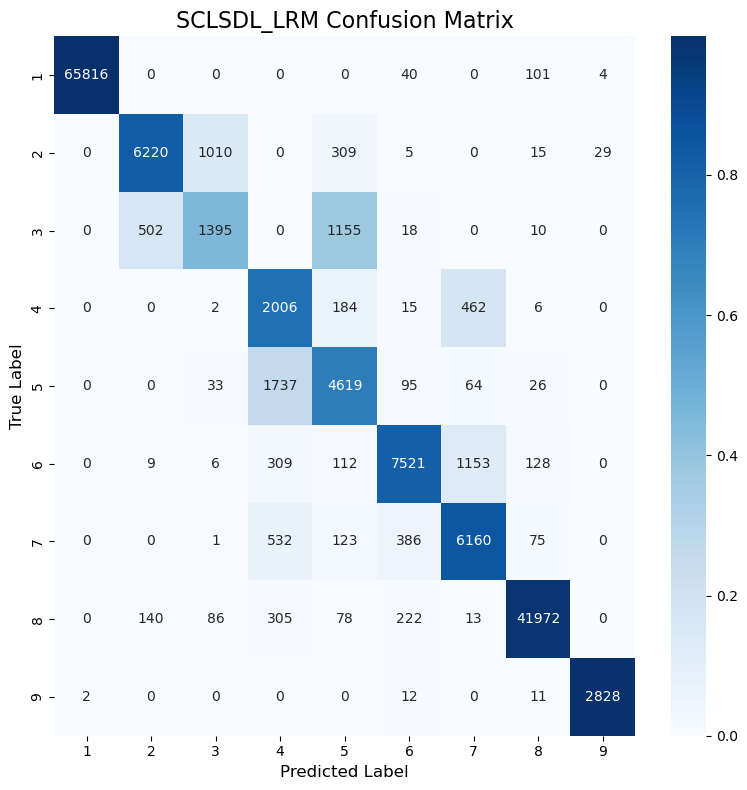

Classification Accuracy: 93.57%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


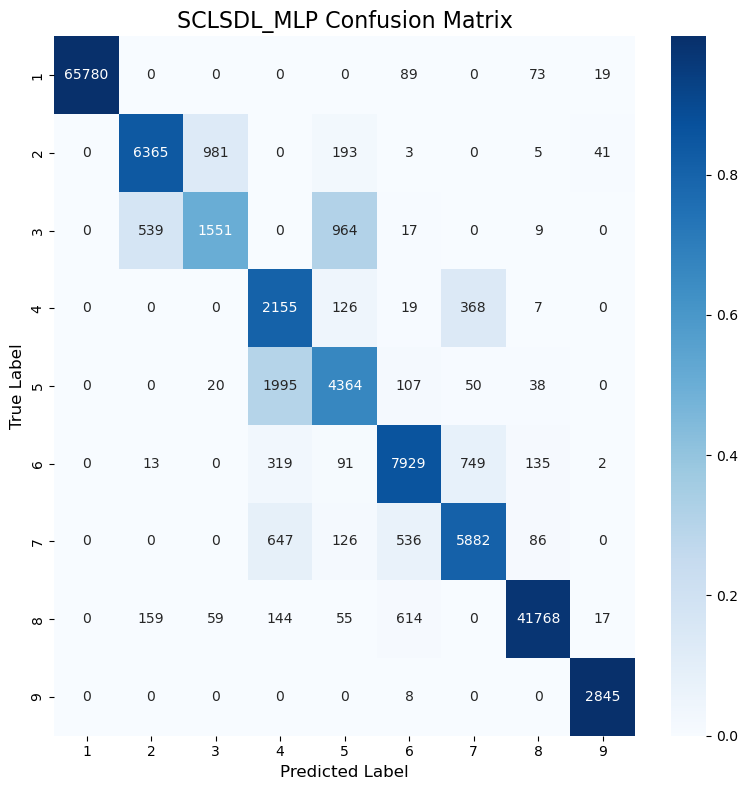

Classification Accuracy: 93.64%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          95.59
1    LRM (CAE)          94.18
2    MLP (CAE)          92.14
3     TSCL LRM          93.74
4     TSCL MLP          93.05
5  SCL_SDL LRM          93.57
6  SCL_SDL MLP          93.64

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          95.59
1    LRM (CAE)          94.18
3     TSCL LRM          93.74
6  SCL_SDL MLP          93.64
5  SCL_SDL LRM          93.57
4     TSCL MLP          93.05
2    MLP (CAE)          92.14
